# Master Thesis Data Science and Society - Customer Churn Prediction in The Aviation Industry

**Name:** Youri Franken <br>
**ANR:** 2106143 <br>
**Date:** 04-12-2023

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Thesis
!cp 'Customer Churn.csv' '/content'

Mounted at /content/drive
/content/drive/MyDrive/Thesis


In [2]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00


In [3]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, yeojohnson, kstest

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K
import keras_tuner
from kerastuner.tuners import RandomSearch

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, auc, precision_score, recall_score, PrecisionRecallDisplay

<ipython-input-3-f8dbf573b407>:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
#Load datset and drop ID column
df = pd.read_csv('Customer Churn.csv', sep=";")
df = df.drop('id', axis = 1)

# Re-order dataset
desired_column_order = [
    'Customer Type', 'Gender', 'Age', 'Type of Travel', 'Class',
    'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient',
    'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
    'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
    'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction'
]

df = df[desired_column_order]

df.head()

Customer Type  Gender  Age   Type of Travel     Class  Flight Distance  \
0     Loyal Customer    Male   13  Personal Travel  Eco Plus              460   
1  disloyal Customer    Male   25  Business travel  Business              235   
2     Loyal Customer  Female   26  Business travel  Business             1142   
3     Loyal Customer  Female   25  Business travel  Business              562   
4     Loyal Customer    Male   61  Business travel  Business              214   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      3                                  4   
1                      3                                  2   
2                      2                                  2   
3                      2                                  5   
4                      3                                  3   

   Ease of Online booking  Gate location  ...  Inflight entertainment  \
0                       3              1  ...                       5   
1                       3              3  ...                       1   
2                       2              2  ...                       5   
3                       5              5  ...                       2   
4                       3              3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  
4                       0.0                satisfied  

[5 rows x 23 columns]

In [5]:
#List-wise deletion on missing values
df = df.dropna(axis = 0)
df.loc[:, 'Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)


<ipython-input-5-aeabb00344dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)
<ipython-input-5-aeabb00344dc>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)


## Exploratory Data Analysis (EDA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Gender                             129487 non-null  object
 1   Customer Type                      129487 non-null  object
 2   Age                                129487 non-null  int64 
 3   Type of Travel                     129487 non-null  object
 4   Class                              129487 non-null  object
 5   Flight Distance                    129487 non-null  int64 
 6   Inflight wifi service              129487 non-null  int64 
 7   Departure/Arrival time convenient  129487 non-null  int64 
 8   Ease of Online booking             129487 non-null  int64 
 9   Gate location                      129487 non-null  int64 
 10  Food and drink                     129487 non-null  int64 
 11  Online boarding                    129487 non-null  

In [ ]:
df.describe()

Age  Flight Distance  Inflight wifi service  \
count  129487.000000    129487.000000          129487.000000   
mean       39.428761      1190.210662               2.728544   
std        15.117597       997.560954               1.329235   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       844.000000               3.000000   
75%        51.000000      1744.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129487.000000           129487.000000   
mean                            3.057349                2.756786   
std                             1.526787                1.401662   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129487.000000   129487.000000    129487.000000  129487.000000   
mean        2.976909        3.204685         3.252720       3.441589   
std         1.278506        1.329905         1.350651       1.319168   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129487.000000     129487.000000     129487.000000   
mean                 3.358067          3.383204          3.351078   
std                  1.334149          1.287032          1.316132   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     129487.000000    129487.000000     129487.000000  129487.000000   
mean           3.631886         3.306239          3.642373       3.286222   
std            1.180082         1.266146          1.176614       1.313624   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               129487.000000             129487.000000  
mean                    14.643385                 15.091129  
std                     37.932867                 38.465650  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

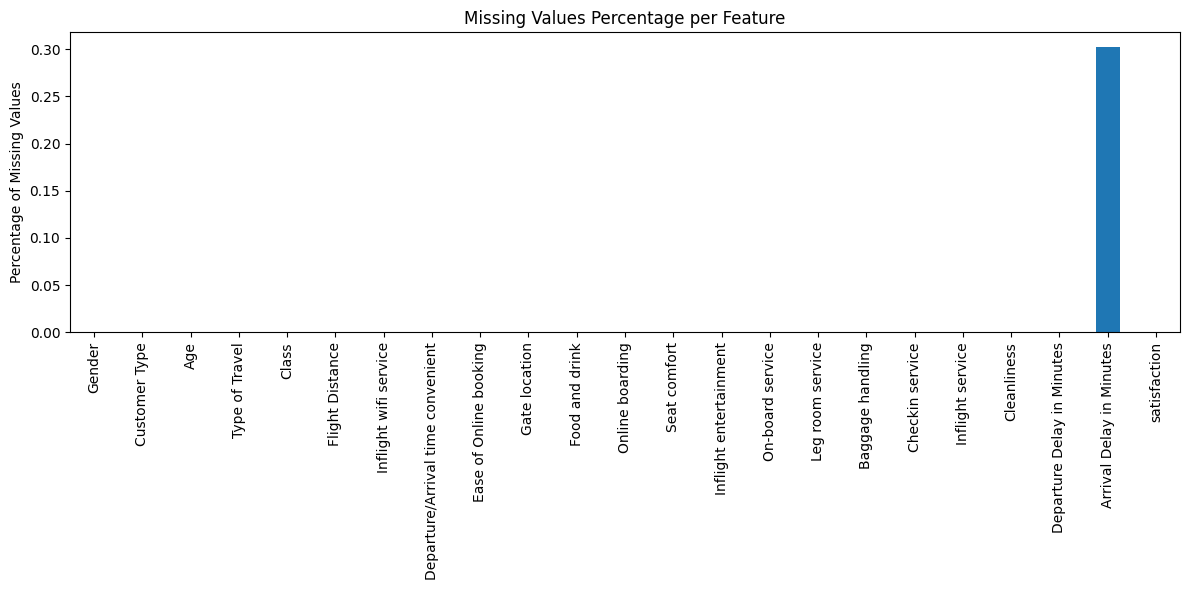

In [ ]:
# Calculate the percentage of missing values
pds = (df[df.columns].isna().sum() / len(df.index)) * 100

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))
pds.plot.bar(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Percentage of Missing Values')
ax.set_title('Missing Values Percentage per Feature')
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/missing_values_plot.png', dpi=300)

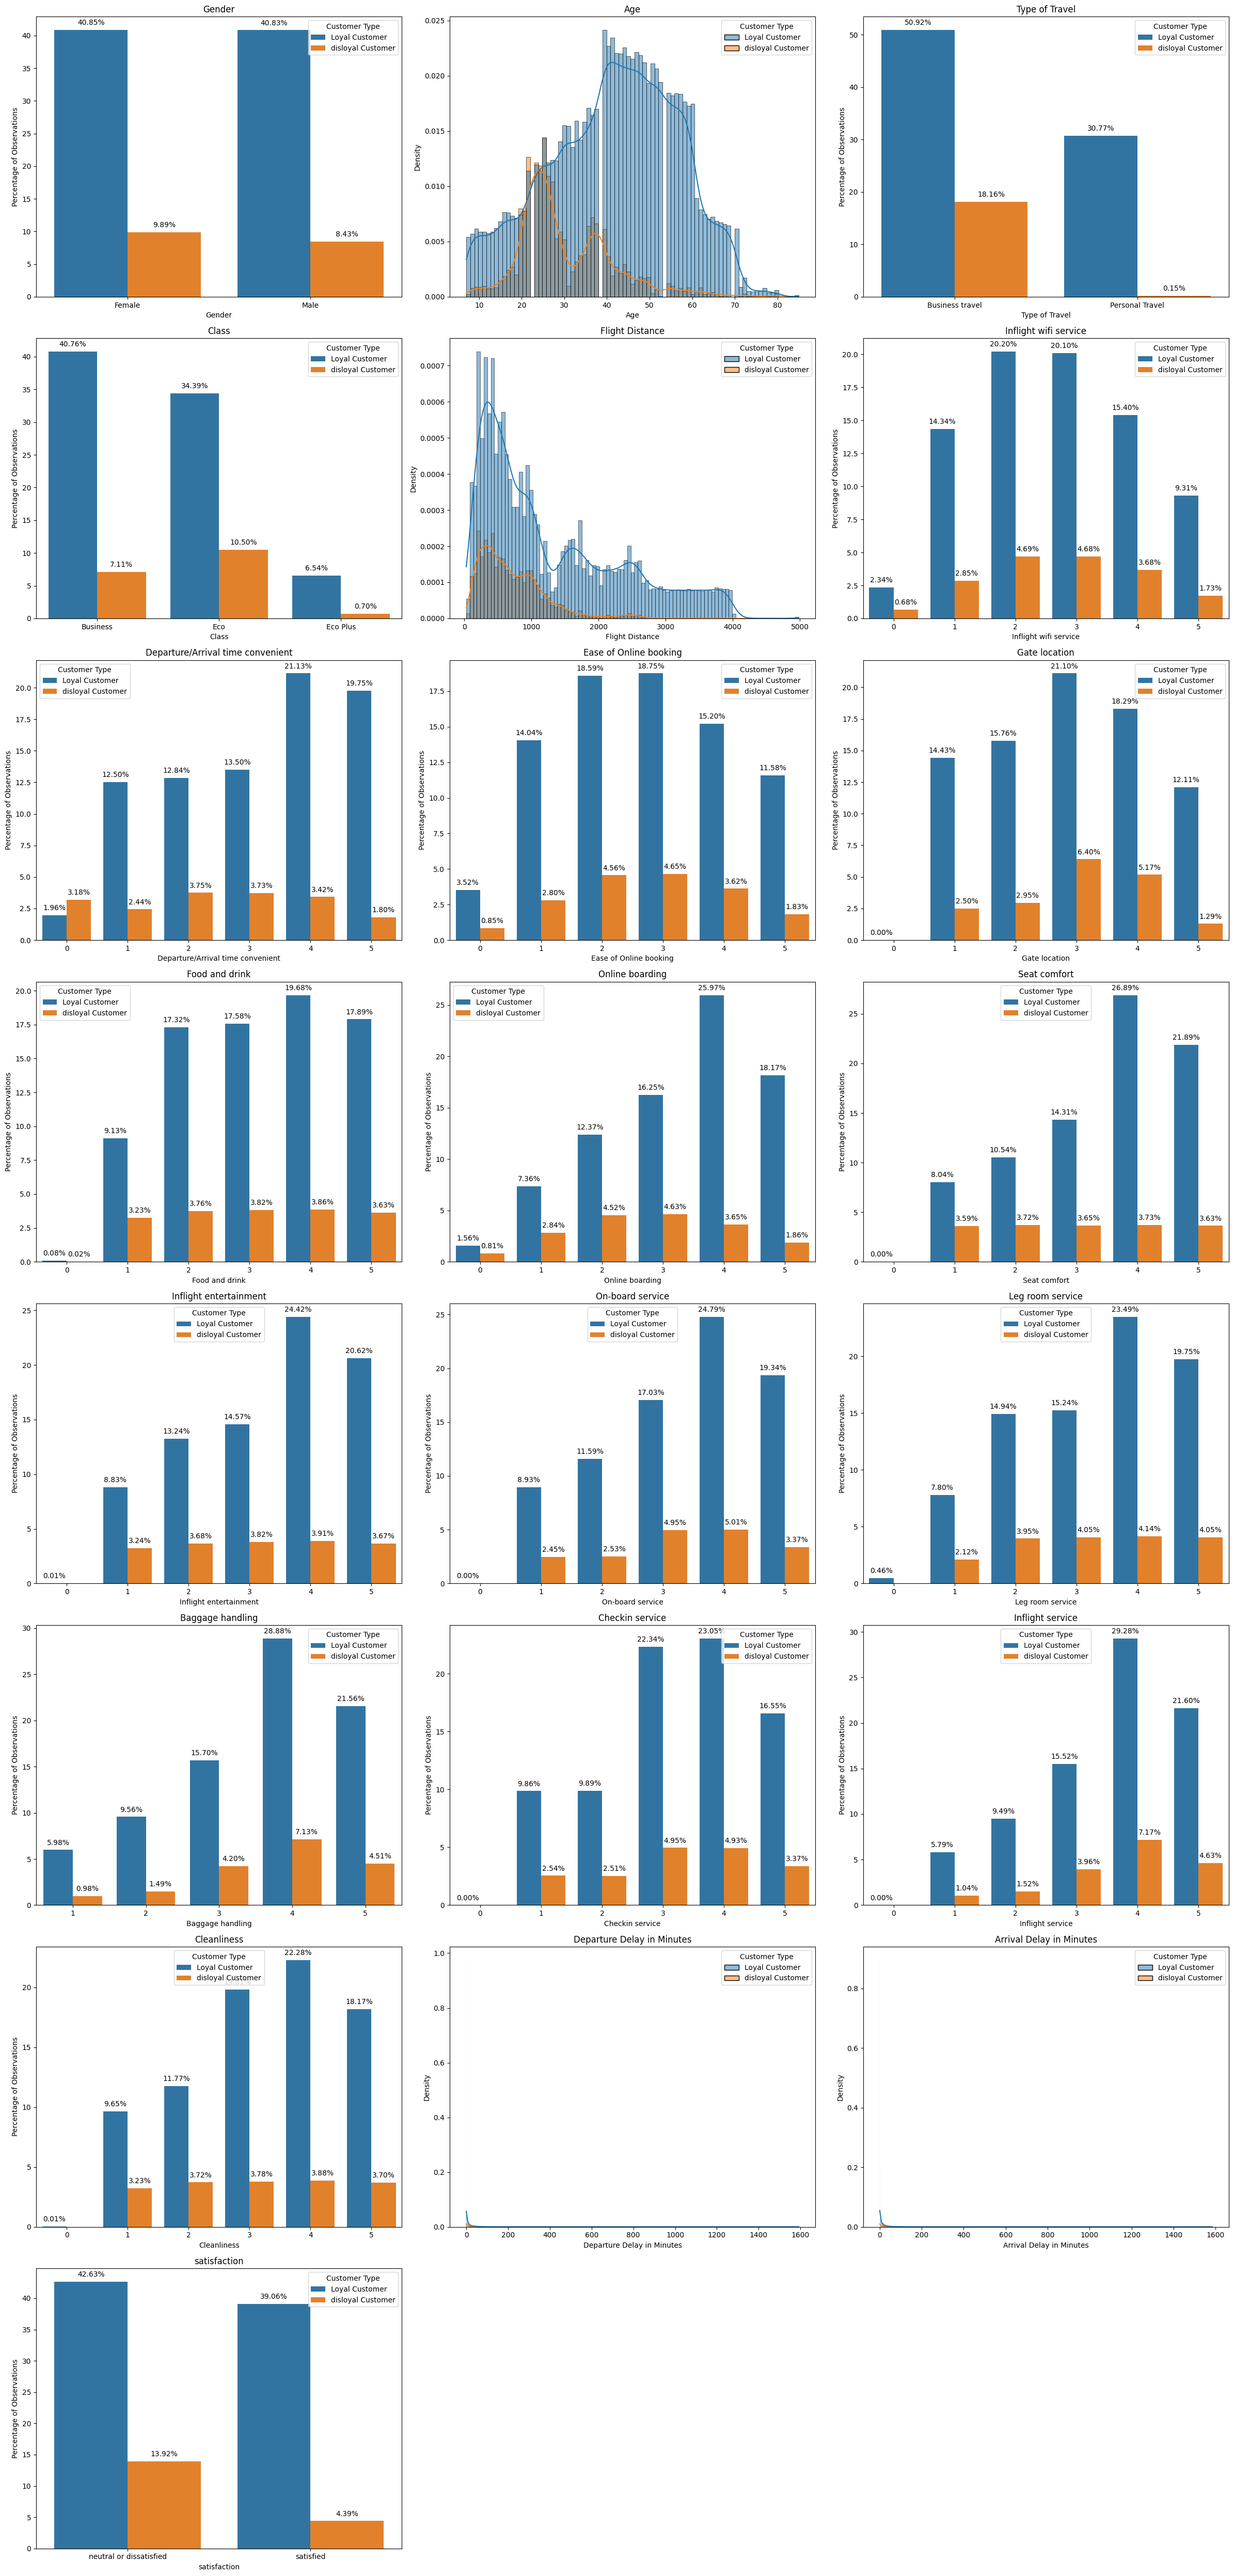

In [ ]:
# List of columns to visualize
columns_to_visualize = [
    'Gender', 'Age', 'Type of Travel', 'Class',
    'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient',
    'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
    'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
    'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction'
]

# Create bar and hist plots of the dataset
fig, axes = plt.subplots(8, 3, figsize=(24, 50))
axes = axes.flatten()

for i, column in enumerate(columns_to_visualize):
    if column == 'Age' or column == 'Flight Distance' or column == 'Departure Delay in Minutes' or column == 'Arrival Delay in Minutes':
        sns.histplot(x=column, hue='Customer Type', kde = True, data=df, stat='density', ax=axes[i])
        axes[i].set_ylabel('Density')
        axes[i].set_title(column)
    else:
        percentages = df.groupby([column, 'Customer Type']).size() / len(df) * 100
        percentages = percentages.reset_index(name='Percentage')
        sns.barplot(x=column, y='Percentage', hue='Customer Type', data=percentages, dodge=True, ax=axes[i])
        axes[i].set_ylabel('Percentage of Observations')
        axes[i].set_title(column)
        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


for j in range(len(columns_to_visualize), len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Barplot-Histplot_EDA.png', dpi=300)


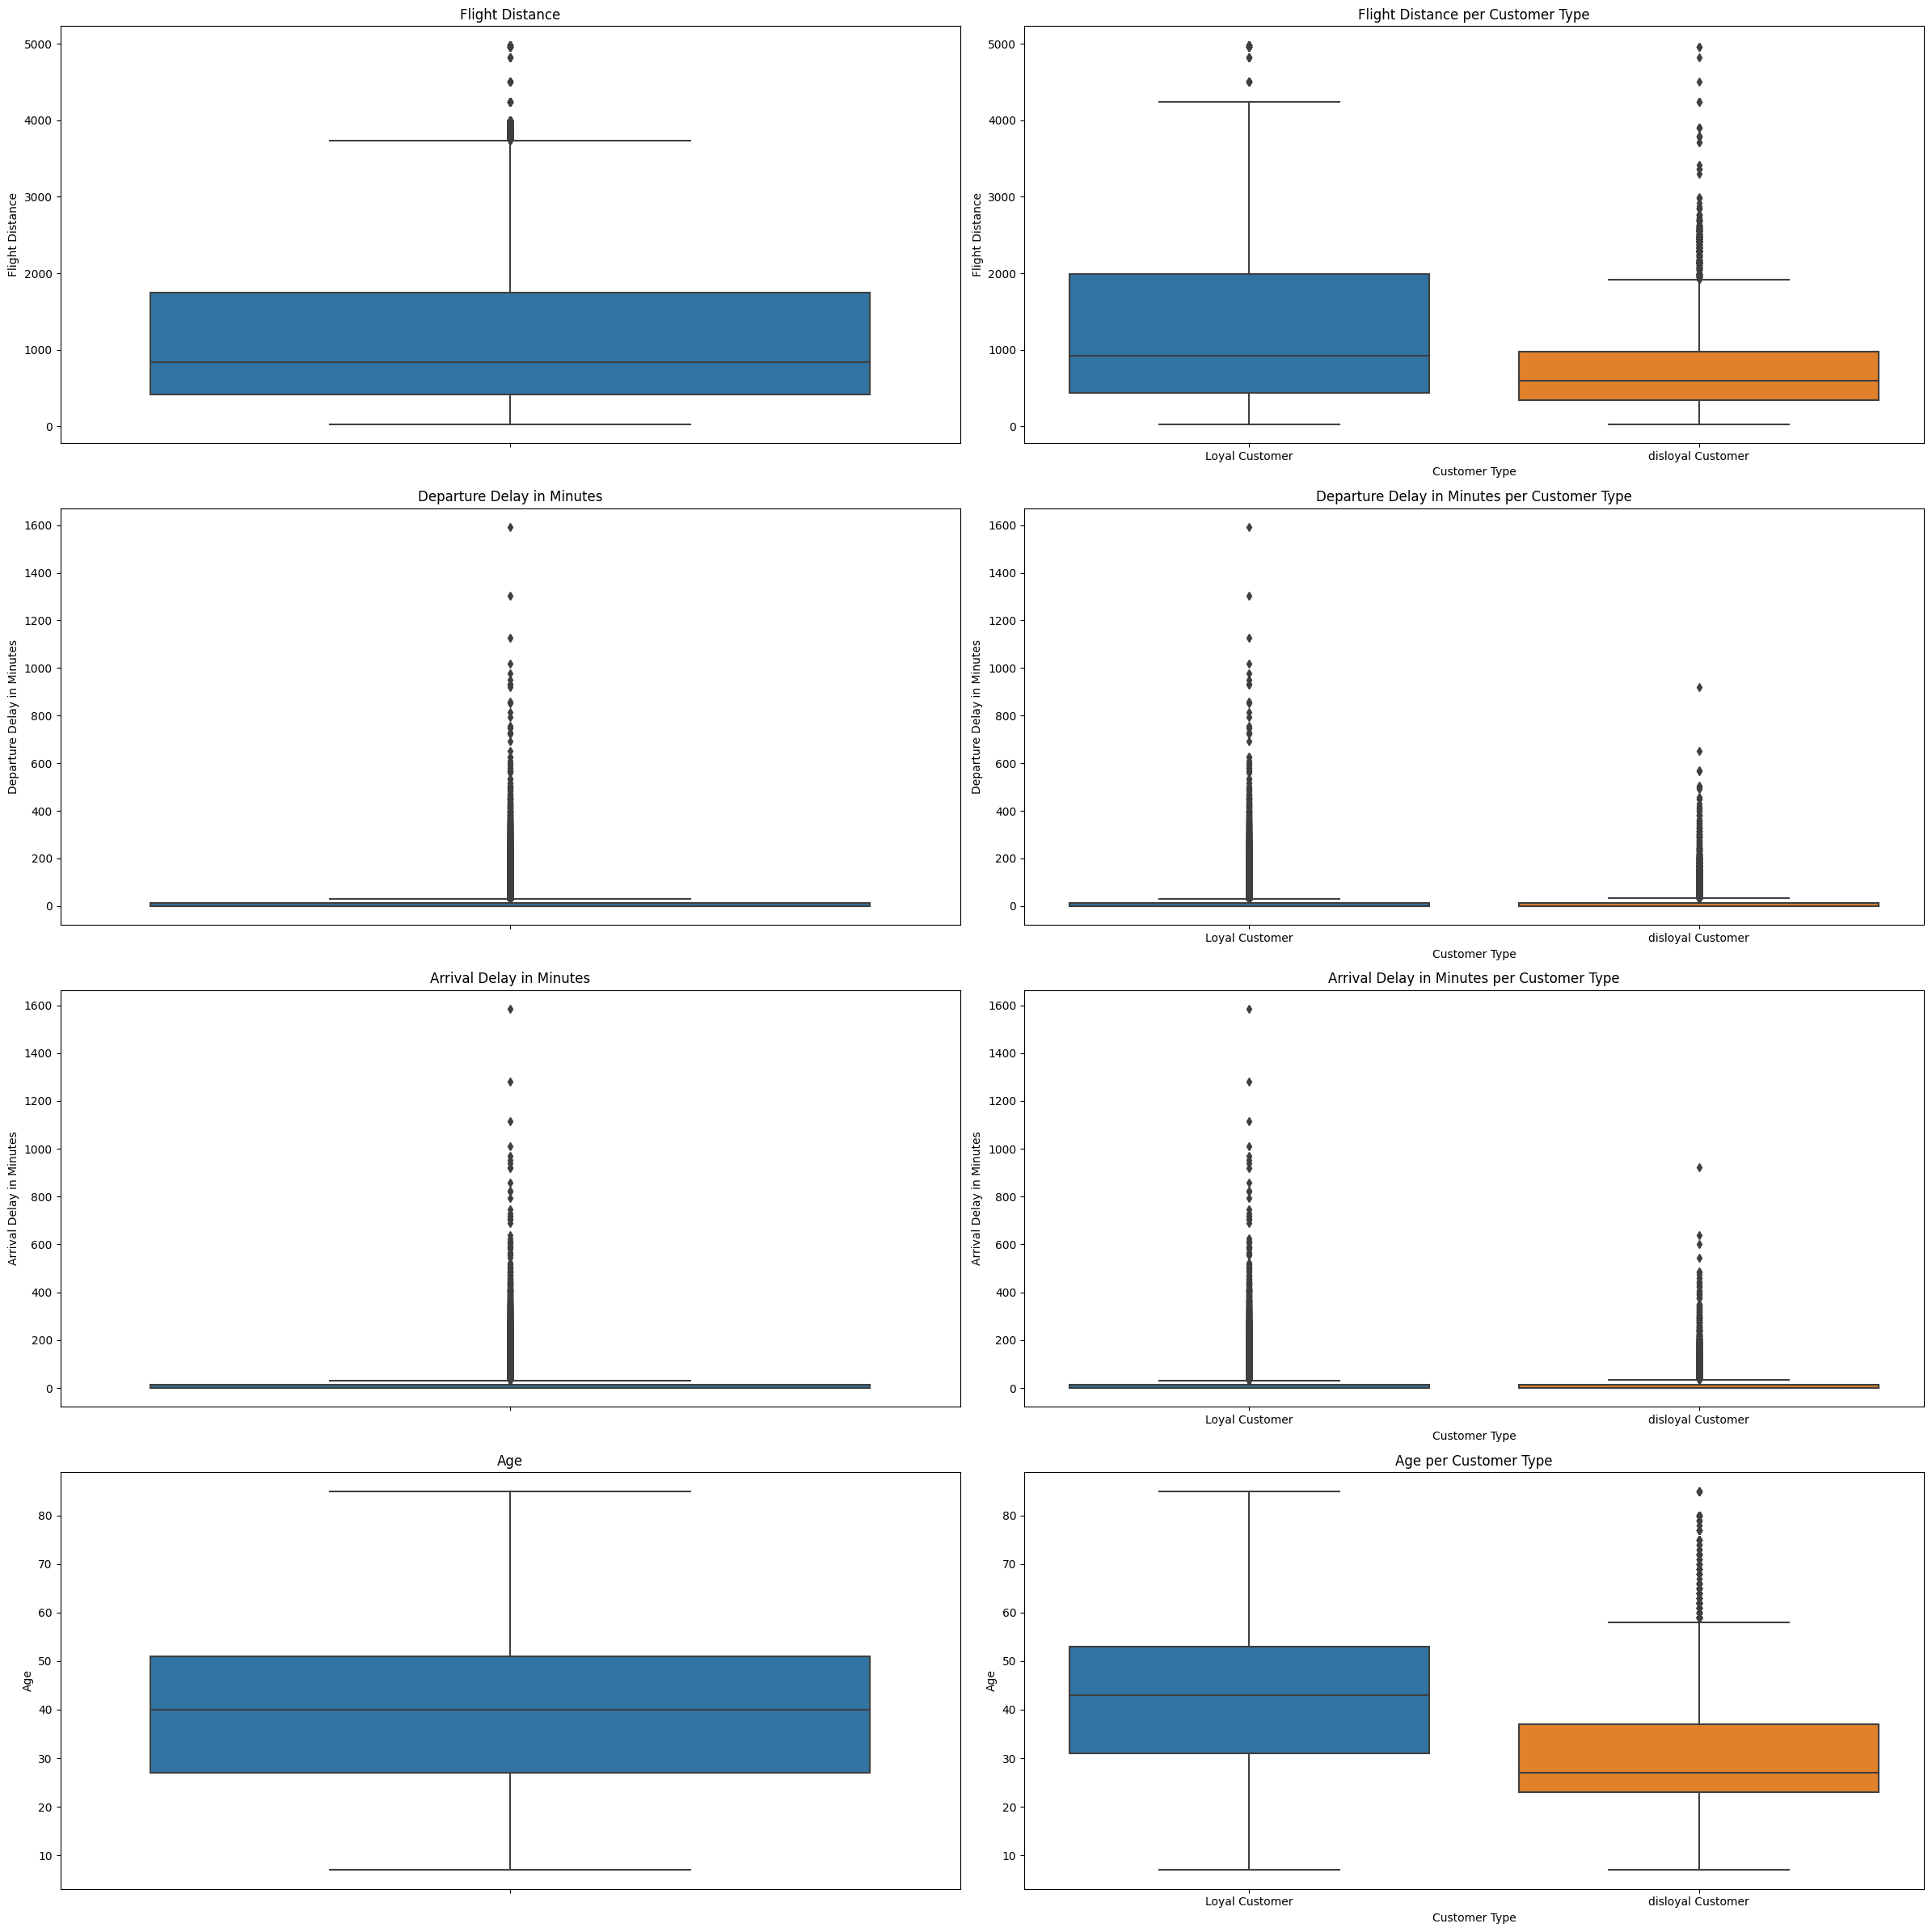

In [ ]:
#Boxplot numerical features
plt.figure(figsize=[24,24])

plt.subplot(4, 2, 1)
sns.boxplot(y=df['Flight Distance'])
plt.title('Flight Distance')
plt.ylabel('Flight Distance')

plt.subplot(4, 2, 2)
sns.boxplot(x=df['Customer Type'], y=df['Flight Distance'])
plt.title('Flight Distance per Customer Type')
plt.ylabel('Flight Distance')

plt.subplot(4, 2, 3)
sns.boxplot(y=df['Departure Delay in Minutes'])
plt.title('Departure Delay in Minutes')
plt.ylabel('Departure Delay in Minutes')

plt.subplot(4, 2, 4)
sns.boxplot(x=df['Customer Type'], y=df['Departure Delay in Minutes'])
plt.title('Departure Delay in Minutes per Customer Type')
plt.ylabel('Departure Delay in Minutes')

plt.subplot(4, 2, 5)
sns.boxplot(y=df['Arrival Delay in Minutes'])
plt.title('Arrival Delay in Minutes')
plt.ylabel('Arrival Delay in Minutes')

plt.subplot(4, 2, 6)
sns.boxplot(x=df['Customer Type'], y=df['Arrival Delay in Minutes'])
plt.title('Arrival Delay in Minutes per Customer Type')
plt.ylabel('Arrival Delay in Minutes')

plt.subplot(4, 2, 7)
sns.boxplot(y=df['Age'])
plt.title('Age')
plt.ylabel('Age')

plt.subplot(4, 2, 8)
sns.boxplot(x=df['Customer Type'], y=df['Age'])
plt.title('Age per Customer Type')
plt.ylabel('Age')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.savefig('/content/drive/My Drive/Thesis/Figures/Boxplot.png', dpi=300)

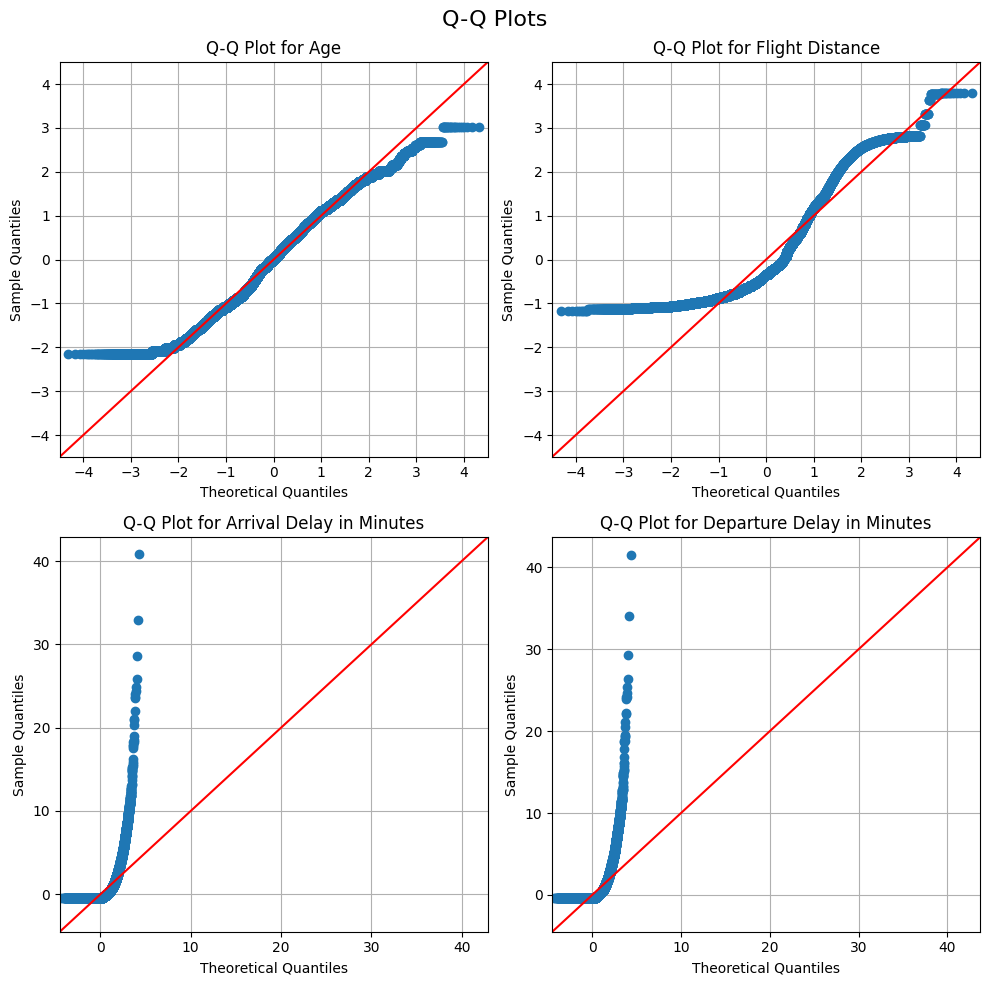

In [ ]:
# List of variables to create Q-Q plots for
variables = ['Age', 'Flight Distance', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']

# Create QQ-plots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Q-Q Plots', fontsize=16)

for i, variable in enumerate(variables):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    # Create the Q-Q plot using statsmodels
    sm.qqplot(df[variable], line='45', fit=True, ax=ax)
    ax.set_title(f'Q-Q Plot for {variable}')
    ax.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/QQ-plot.png', dpi=300)

#Store skewness and kurtosis
df_skewness = df[variables].apply(skew)
df_kurtosis = df[variables].apply(kurtosis)

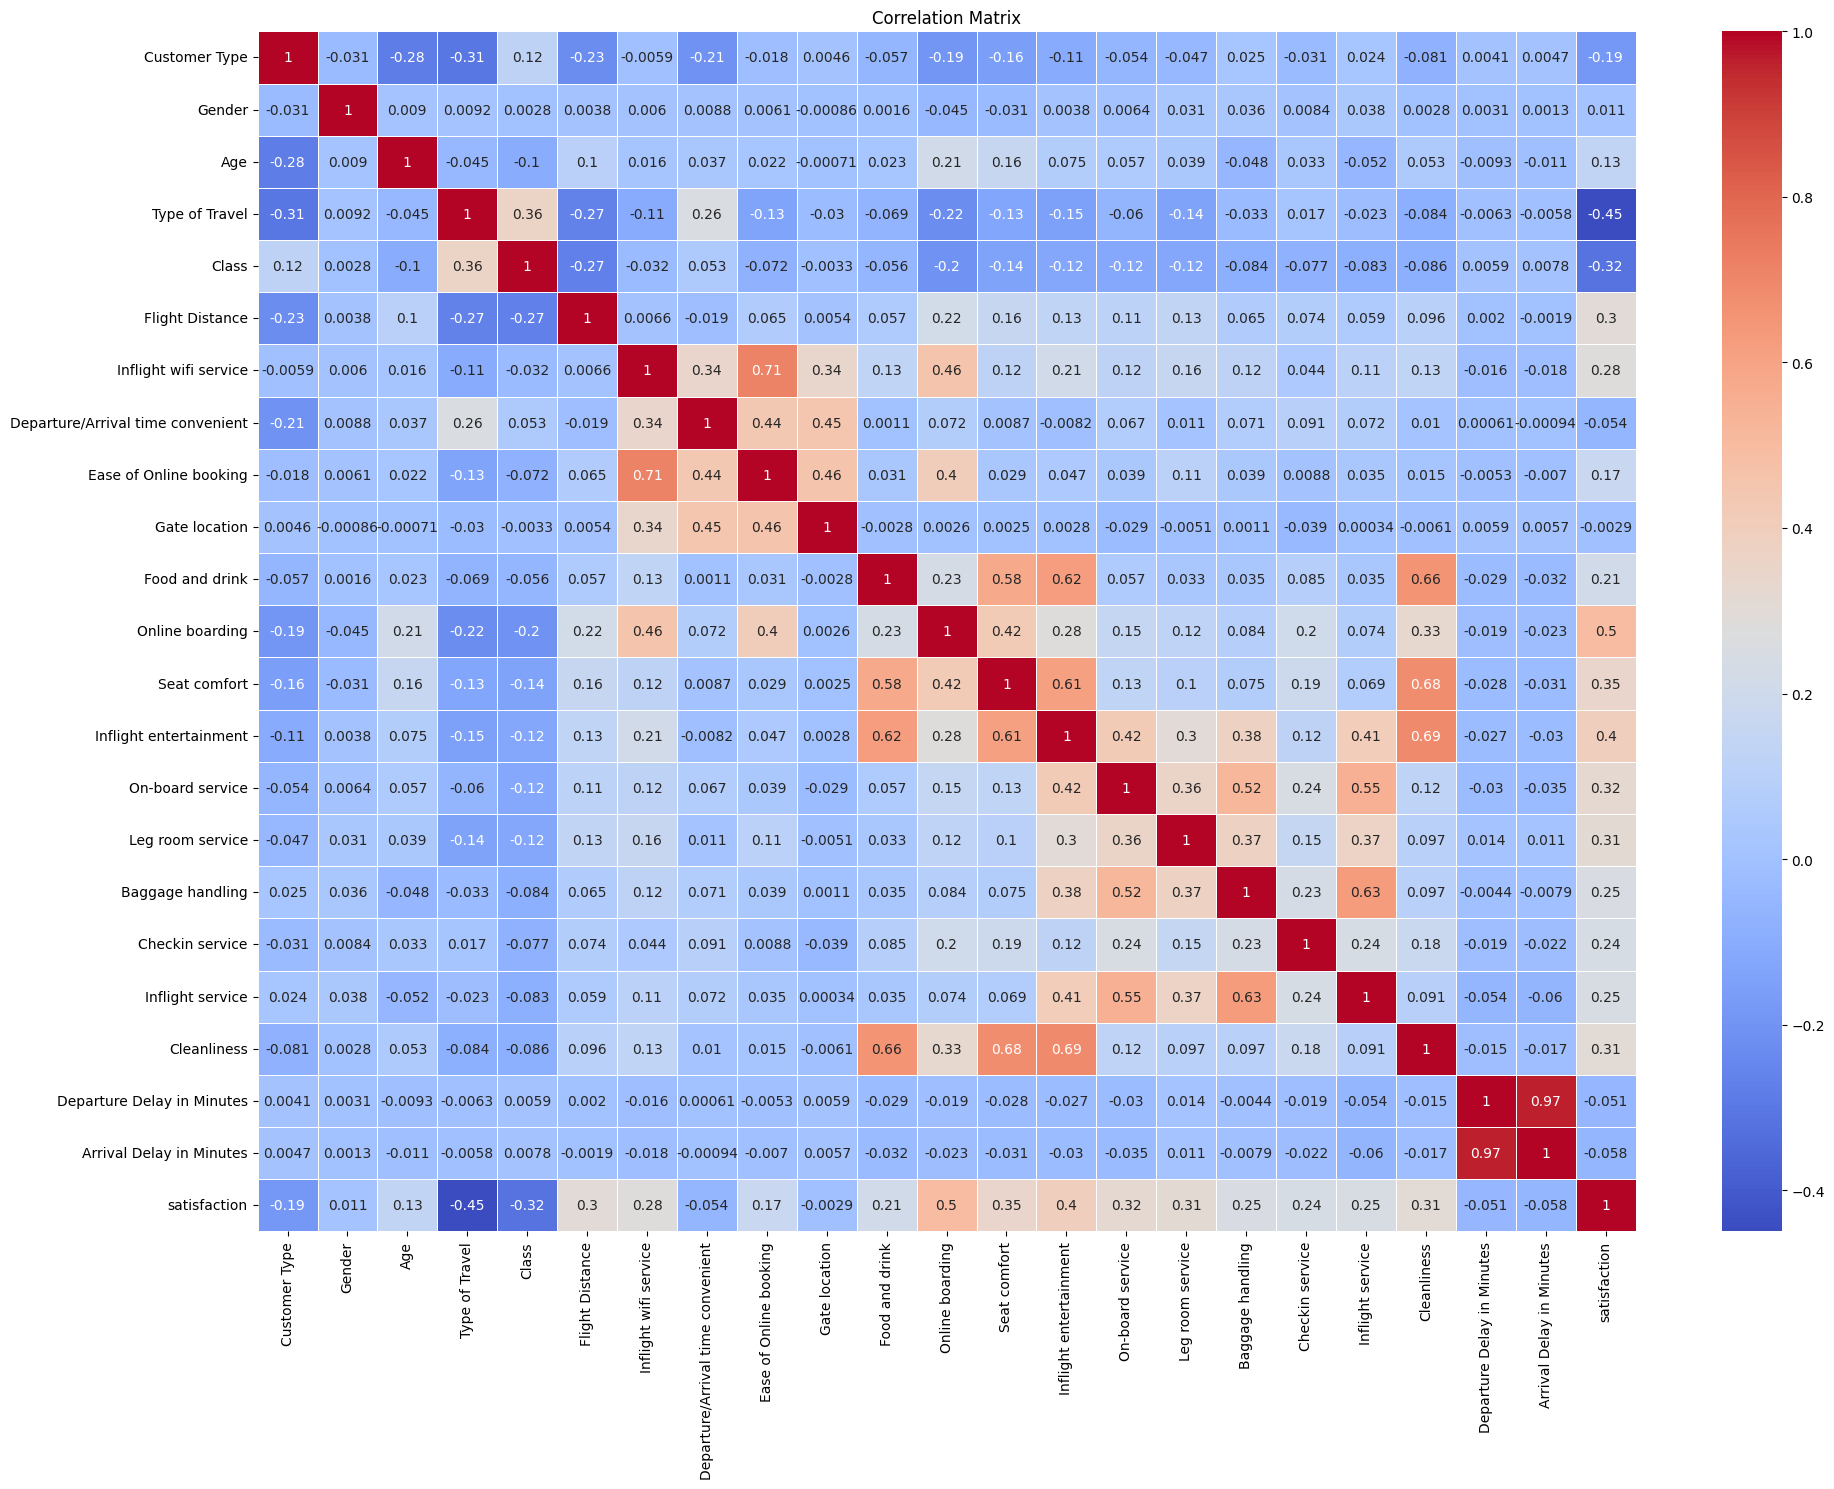

In [ ]:
# Correlation Matrix
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
ax.set_title("Correlation Matrix")

fig.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Correlation.png', dpi=300)

In [ ]:
#df descibe per customer type
churn_yes = df[df['Customer Type'] == 1]
churn_no = df[df['Customer Type'] == 0]
churn_yes.describe()

Age  Flight Distance  Inflight wifi service  \
count  0.0              0.0                    0.0   
mean   NaN              NaN                    NaN   
std    NaN              NaN                    NaN   
min    NaN              NaN                    NaN   
25%    NaN              NaN                    NaN   
50%    NaN              NaN                    NaN   
75%    NaN              NaN                    NaN   
max    NaN              NaN                    NaN   

       Departure/Arrival time convenient  Ease of Online booking  \
count                                0.0                     0.0   
mean                                 NaN                     NaN   
std                                  NaN                     NaN   
min                                  NaN                     NaN   
25%                                  NaN                     NaN   
50%                                  NaN                     NaN   
75%                                  NaN                     NaN   
max                                  NaN                     NaN   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count            0.0             0.0              0.0           0.0   
mean             NaN             NaN              NaN           NaN   
std              NaN             NaN              NaN           NaN   
min              NaN             NaN              NaN           NaN   
25%              NaN             NaN              NaN           NaN   
50%              NaN             NaN              NaN           NaN   
75%              NaN             NaN              NaN           NaN   
max              NaN             NaN              NaN           NaN   

       Inflight entertainment  On-board service  Leg room service  \
count                     0.0               0.0               0.0   
mean                      NaN               NaN               NaN   
std                       NaN               NaN               NaN   
min                       NaN               NaN               NaN   
25%                       NaN               NaN               NaN   
50%                       NaN               NaN               NaN   
75%                       NaN               NaN               NaN   
max                       NaN               NaN               NaN   

       Baggage handling  Checkin service  Inflight service  Cleanliness  \
count               0.0              0.0               0.0          0.0   
mean                NaN              NaN               NaN          NaN   
std                 NaN              NaN               NaN          NaN   
min                 NaN              NaN               NaN          NaN   
25%                 NaN              NaN               NaN          NaN   
50%                 NaN              NaN               NaN          NaN   
75%                 NaN              NaN               NaN          NaN   
max                 NaN              NaN               NaN          NaN   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count                         0.0                       0.0  
mean                          NaN                       NaN  
std                           NaN                       NaN  
min                           NaN                       NaN  
25%                           NaN                       NaN  
50%                           NaN                       NaN  
75%                           NaN                       NaN  
max                           NaN                       NaN

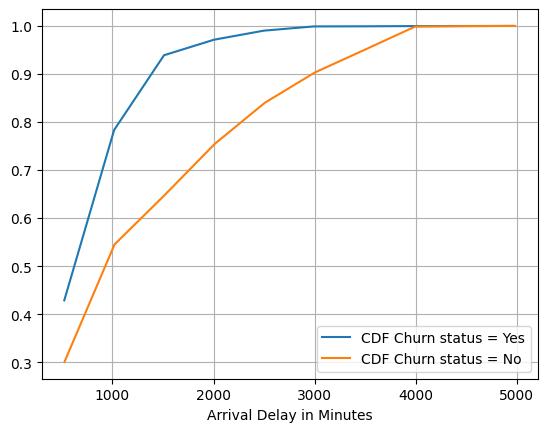

In [ ]:
counts, bin_edges = np.histogram(churn_yes['Flight Distance'], density = True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf, label = 'CDF Churn status = Yes')
counts, bin_edges = np.histogram(churn_no['Flight Distance'], density = True)
pdf = counts/sum(counts)
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf, label = 'CDF Churn status = No')
plt.legend()
plt.xlabel('Arrival Delay in Minutes')
plt.grid()
plt.show()

## Data Preprocessing

In [6]:
#Map Loyal customers to 0 and disloyal customers to 1
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer': 0, 'disloyal Customer': 1})

#One-hot encoding nominal features:
df = pd.get_dummies(df, columns = ['Class'])

#Text to numeric values
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Type of Travel'] = label_encoder.fit_transform(df['Type of Travel'])
df['satisfaction'] = label_encoder.fit_transform(df['satisfaction'])
df

Customer Type  Gender  Age  Type of Travel  Flight Distance  \
0                   0       1   13               1              460   
1                   1       1   25               0              235   
2                   0       0   26               0             1142   
3                   0       0   25               0              562   
4                   0       1   61               0              214   
...               ...     ...  ...             ...              ...   
129875              1       1   34               0              526   
129876              0       1   23               0              646   
129877              0       0   17               1              828   
129878              0       1   14               0             1127   
129879              0       0   42               1              264   

        Inflight wifi service  Departure/Arrival time convenient  \
0                           3                                  4   
1                           3                                  2   
2                           2                                  2   
3                           2                                  5   
4                           3                                  3   
...                       ...                                ...   
129875                      3                                  3   
129876                      4                                  4   
129877                      2                                  5   
129878                      3                                  3   
129879                      2                                  5   

        Ease of Online booking  Gate location  Food and drink  ...  \
0                            3              1               5  ...   
1                            3              3               1  ...   
2                            2              2               5  ...   
3                            5              5               2  ...   
4                            3              3               4  ...   
...                        ...            ...             ...  ...   
129875                       3              1               4  ...   
129876                       4              4               4  ...   
129877                       1              5               2  ...   
129878                       3              3               4  ...   
129879                       2              5               4  ...   

        Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                      4                4                 5            5   
1                      3                1                 4            1   
2                      4                4                 4            5   
3                      3                1                 4            2   
4                      4                3                 3            3   
...                  ...              ...               ...          ...   
129875                 4                4                 5            4   
129876                 5                5                 5            4   
129877                 4                5                 4            2   
129878                 5                4                 5            4   
129879                 1                1                 1            1   

        Departure Delay in Minutes  Arrival Delay in Minutes  satisfaction  \
0                               25                        18             0   
1                                1                         6             0   
2                                0                         0             1   
3                               11                         9             0   
4                                0                         0             1   
...                            ...                       ...           ...   
129875                           0    

In [7]:
#Numerical columns to peform Yeo-Johnson
columns_to_transform = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

lambda_values = {}
yeo_skewness = {}
yeo_kurtosis = {}

for column in columns_to_transform:
    transformed_data, lambda_best_fit = yeojohnson(df[column])
    df[column] = transformed_data
    lambda_values[column] = lambda_best_fit
    yeo_skewness[column] = df[column].skew()
    yeo_kurtosis[column] = df[column].kurtosis()

#Store the old and new kurtosis and skewness in dataframe
# df_ks = pd.DataFrame({'Skewness': df_skewness,
#                       'Yeo Skewness': pd.Series(yeo_skewness),
#                       'Kurtosis': df_kurtosis,
#                       'Yeo Kurtosis': pd.Series(yeo_kurtosis),
#                       'Lambda values': pd.Series(lambda_values)})

# df_ks

### Exploratory Data Analysis (EDA) after Yeo Johnson


In [ ]:
df.describe()

Gender  Customer Type            Age  Type of Travel  \
count  129487.000000  129487.000000  129487.000000   129487.000000   
mean        0.492590       0.183138      28.099277        0.309236   
std         0.499947       0.386781       9.784060        0.462180   
min         0.000000       0.000000       5.946824        0.000000   
25%         0.000000       0.000000      20.194124        0.000000   
50%         0.000000       0.000000      28.700213        0.000000   
75%         1.000000       0.000000      35.640997        1.000000   
max         1.000000       1.000000      56.123836        1.000000   

       Flight Distance  Inflight wifi service  \
count    129487.000000          129487.000000   
mean          9.913894               2.728544   
std           1.872024               1.329235   
min           4.198645               0.000000   
25%           8.478332               2.000000   
50%           9.889935               3.000000   
75%          11.444977               4.000000   
max          13.921107               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129487.000000           129487.000000   
mean                            3.057349                2.756786   
std                             1.526787                1.401662   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       Gate location  Food and drink  ...  Baggage handling  Checkin service  \
count  129487.000000   129487.000000  ...     129487.000000    129487.000000   
mean        2.976909        3.204685  ...          3.631886         3.306239   
std         1.278506        1.329905  ...          1.180082         1.266146   
min         0.000000        0.000000  ...          1.000000         0.000000   
25%         2.000000        2.000000  ...          3.000000         3.000000   
50%         3.000000        3.000000  ...          4.000000         3.000000   
75%         4.000000        4.000000  ...          5.000000         4.000000   
max         5.000000        5.000000  ...          5.000000         5.000000   

       Inflight service    Cleanliness  Departure Delay in Minutes  \
count     129487.000000  129487.000000               129487.000000   
mean           3.642373       3.286222                    0.621836   
std            1.176614       1.313624                    0.745801   
min            0.000000       0.000000                   -0.000000   
25%            3.000000       2.000000                   -0.000000   
50%            4.000000       3.000000                    0.000000   
75%            5.000000       4.000000                    1.454294   
max            5.000000       5.000000                    1.971637   

       Arrival Delay in Minutes   satisfaction  Class_Business      Class_Eco  \
count             129487.000000  129487.000000   129487.000000  129487.000000   
mean                   0.656978       0.434499        0.478735       0.448825   
std                    0.779623       0.495693        0.499550       0.497376   
min                   -0.000000       0.000000        0.000000       0.000000   
25%                   -0.000000       0.000000        0.000000       0.000000   
50%                    0.000000       0.000000        0.000000       0.000000   
75%                    1.519736       1.000000        1.000000       1.000000   
max                    2.079571       1.000000        1.000000       1.000000   

       Class_Eco Plus  
count   129487.000000  
mean         0.072440  
std          0.259216  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000  

[8 rows x 25 columns]

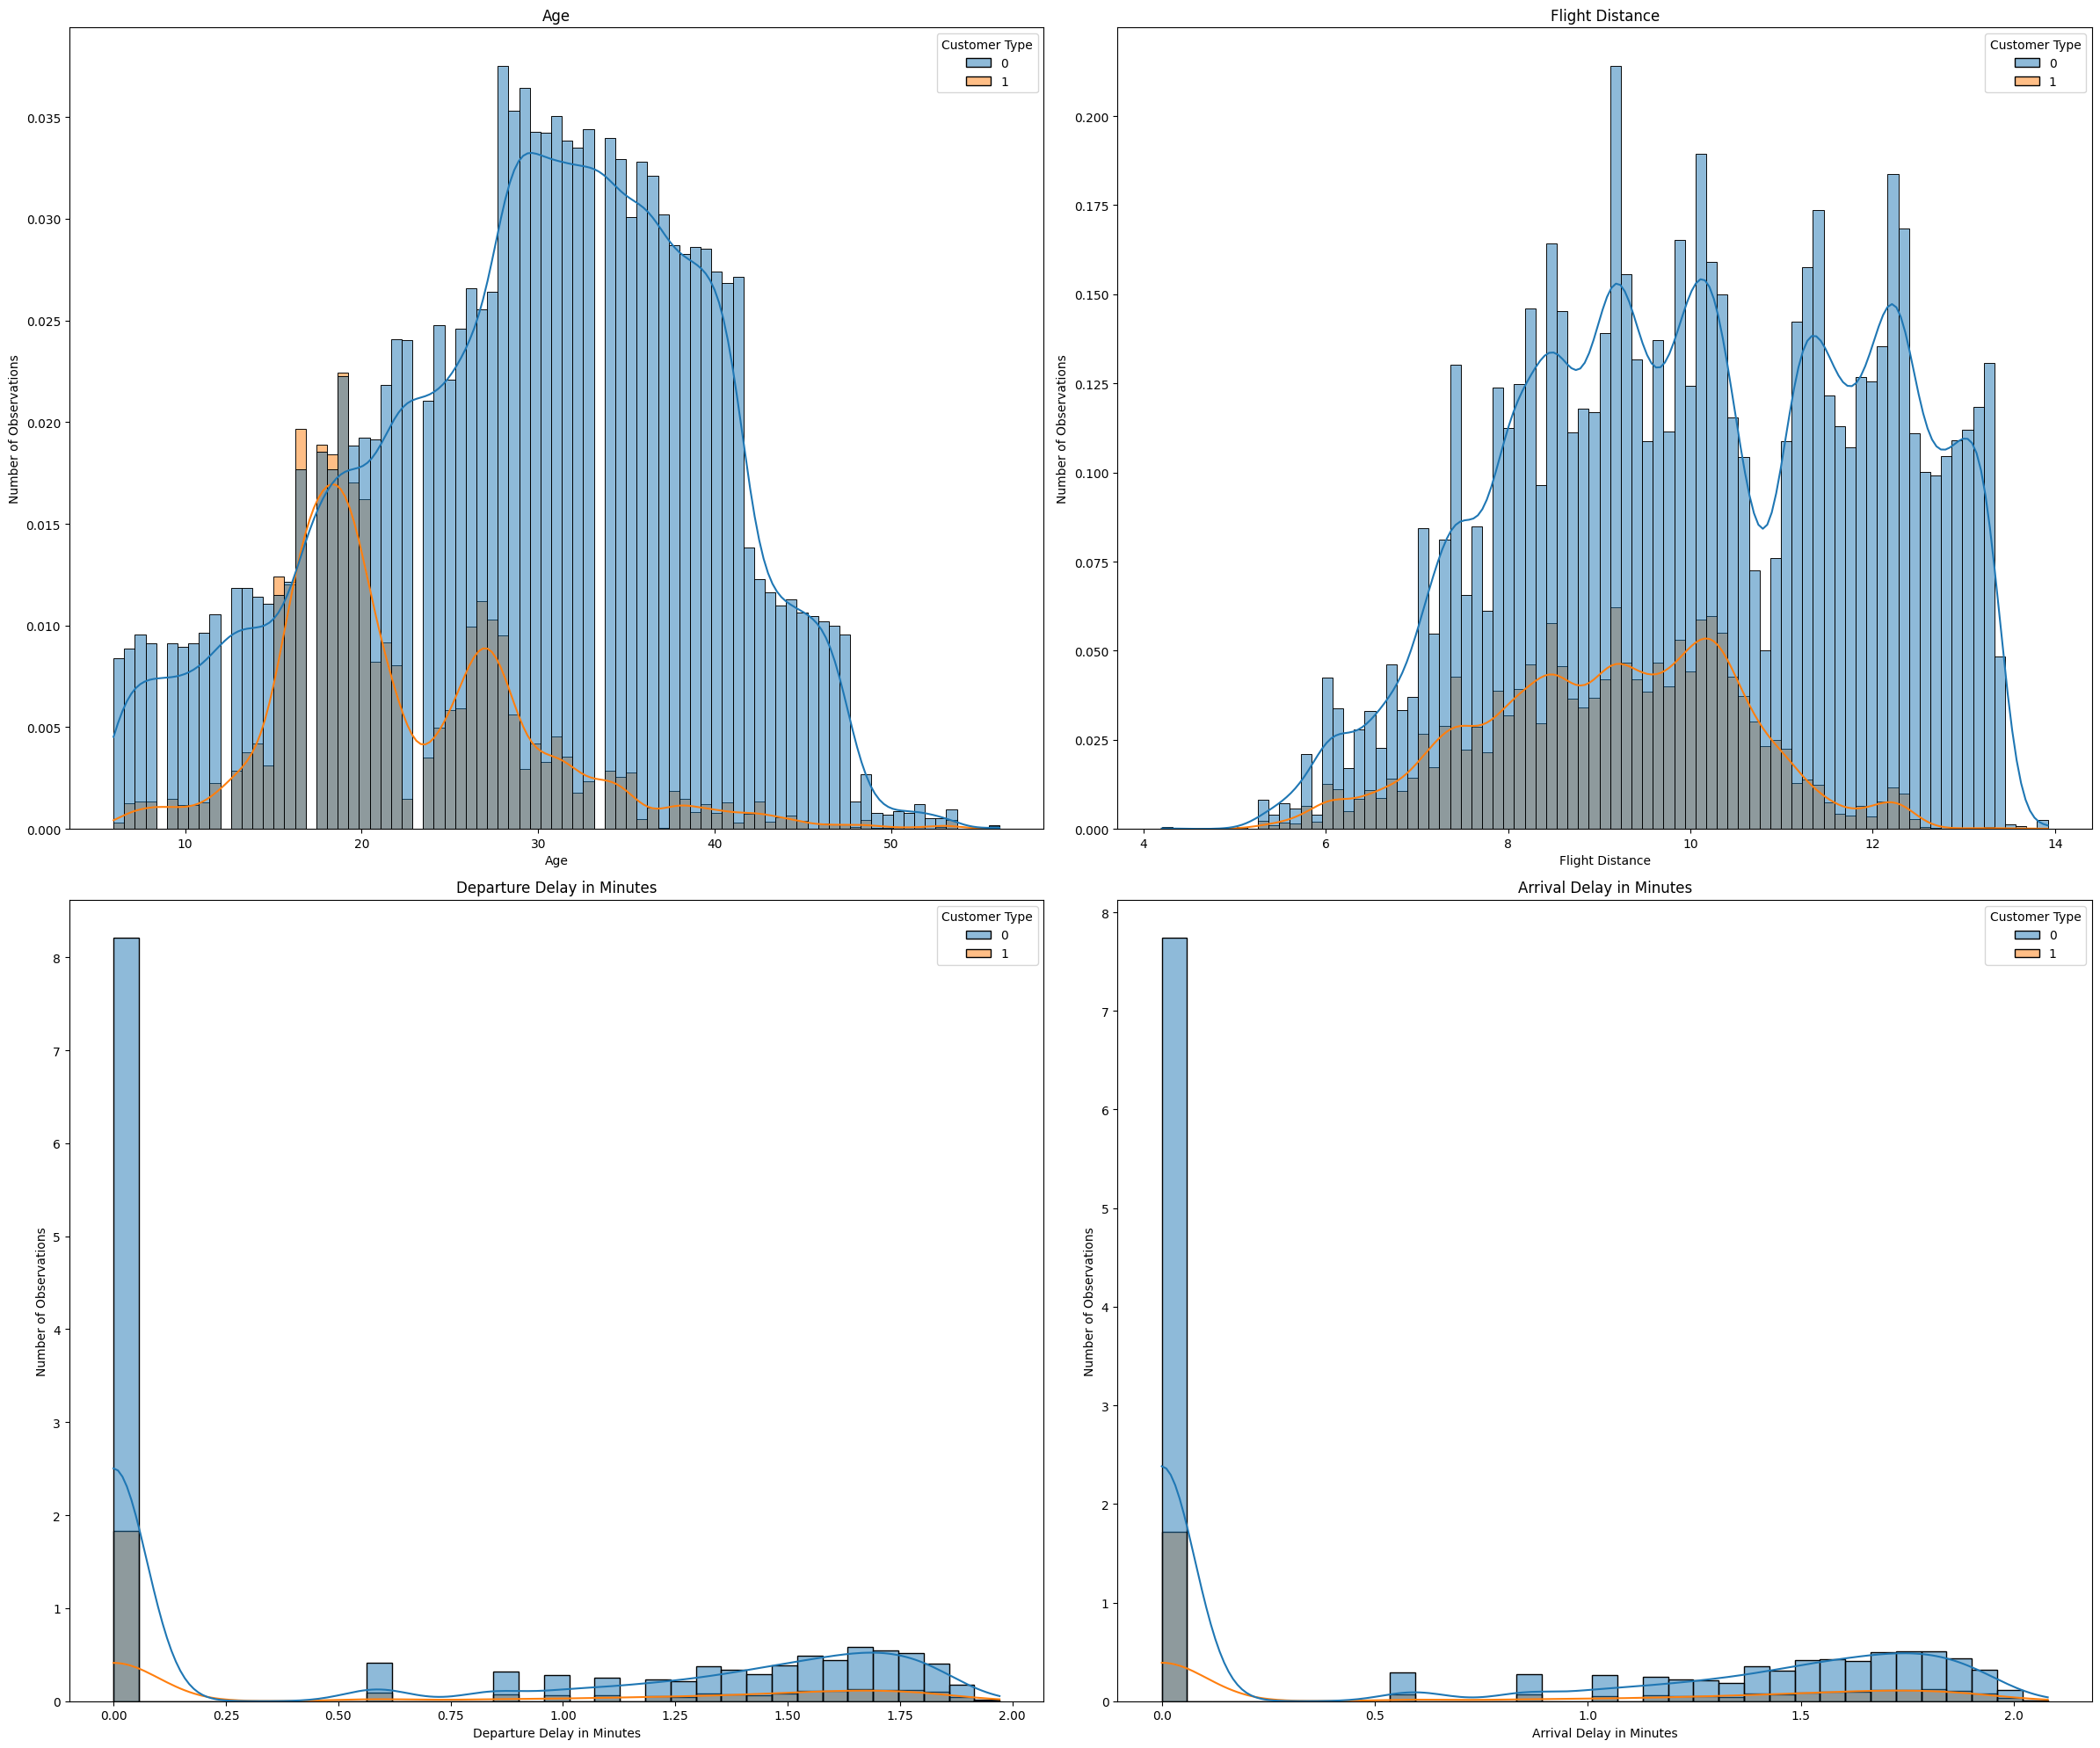

In [ ]:
# Show new Histplots after Yeo-Johnson
fig, axes = plt.subplots(2, 2, figsize=(24, 20))

axes = axes.flatten()

for i, column in enumerate(columns_to_transform):
  sns.histplot(x=column, hue='Customer Type', kde = True, data=df, stat='density', ax=axes[i])
  axes[i].set_ylabel('Number of Observations')
  axes[i].set_title(column)

for j in range(len(columns_to_transform), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Hisplot_after_yeo.png', dpi=300)


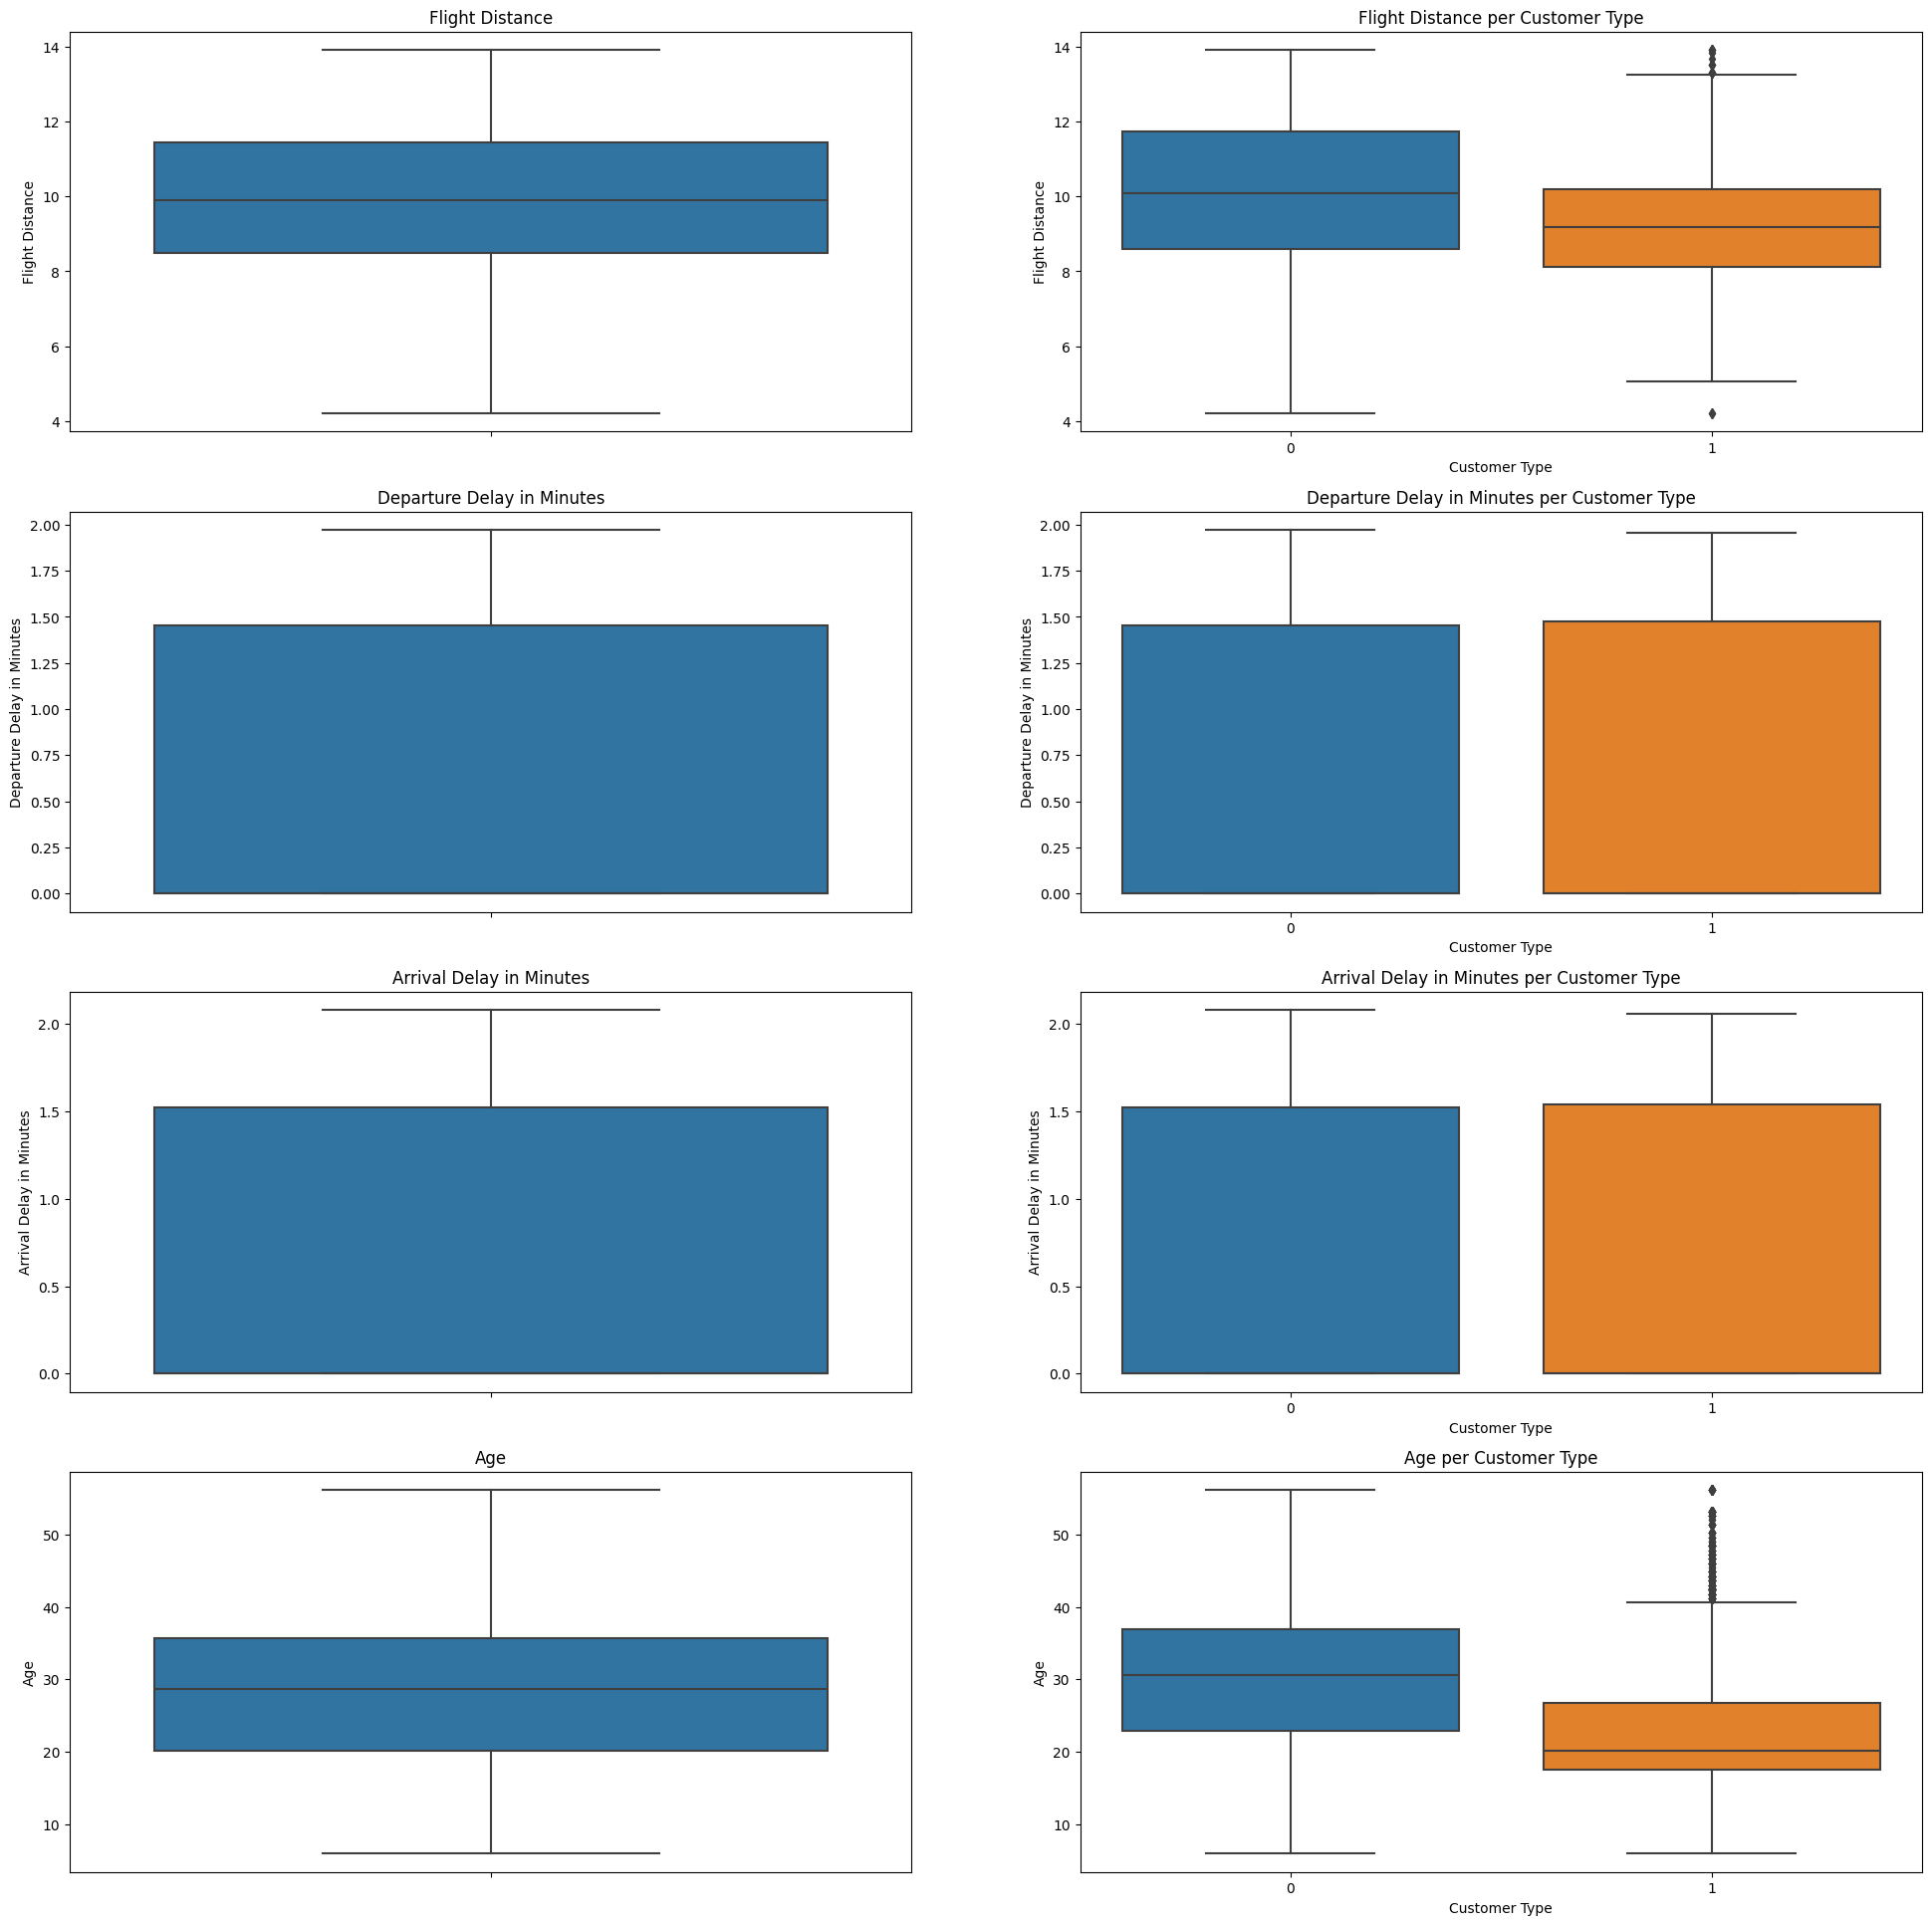

In [ ]:
#Show boxplots after Yeo-johnson
plt.figure(figsize=[24,24])

plt.subplot(4, 2, 1)
sns.boxplot(y=df['Flight Distance'])
plt.title('Flight Distance')
plt.ylabel('Flight Distance')

plt.subplot(4, 2, 2)
sns.boxplot(x=df['Customer Type'], y=df['Flight Distance'])
plt.title('Flight Distance per Customer Type')
plt.ylabel('Flight Distance')

plt.subplot(4, 2, 3)
sns.boxplot(y=df['Departure Delay in Minutes'])
plt.title('Departure Delay in Minutes')
plt.ylabel('Departure Delay in Minutes')

plt.subplot(4, 2, 4)
sns.boxplot(x=df['Customer Type'], y=df['Departure Delay in Minutes'])
plt.title('Departure Delay in Minutes per Customer Type')
plt.ylabel('Departure Delay in Minutes')

plt.subplot(4, 2, 5)
sns.boxplot(y=df['Arrival Delay in Minutes'])
plt.title('Arrival Delay in Minutes')
plt.ylabel('Arrival Delay in Minutes')

plt.subplot(4, 2, 6)
sns.boxplot(x=df['Customer Type'], y=df['Arrival Delay in Minutes'])
plt.title('Arrival Delay in Minutes per Customer Type')
plt.ylabel('Arrival Delay in Minutes')

plt.subplot(4, 2, 7)
sns.boxplot(y=df['Age'])
plt.title('Age')
plt.ylabel('Age')


plt.subplot(4, 2, 8)
sns.boxplot(x=df['Customer Type'], y=df['Age'])
plt.title('Age per Customer Type')
plt.ylabel('Age')

# Adjust subplot layout
fig.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Boxplot_after_yeo.png', dpi=300)

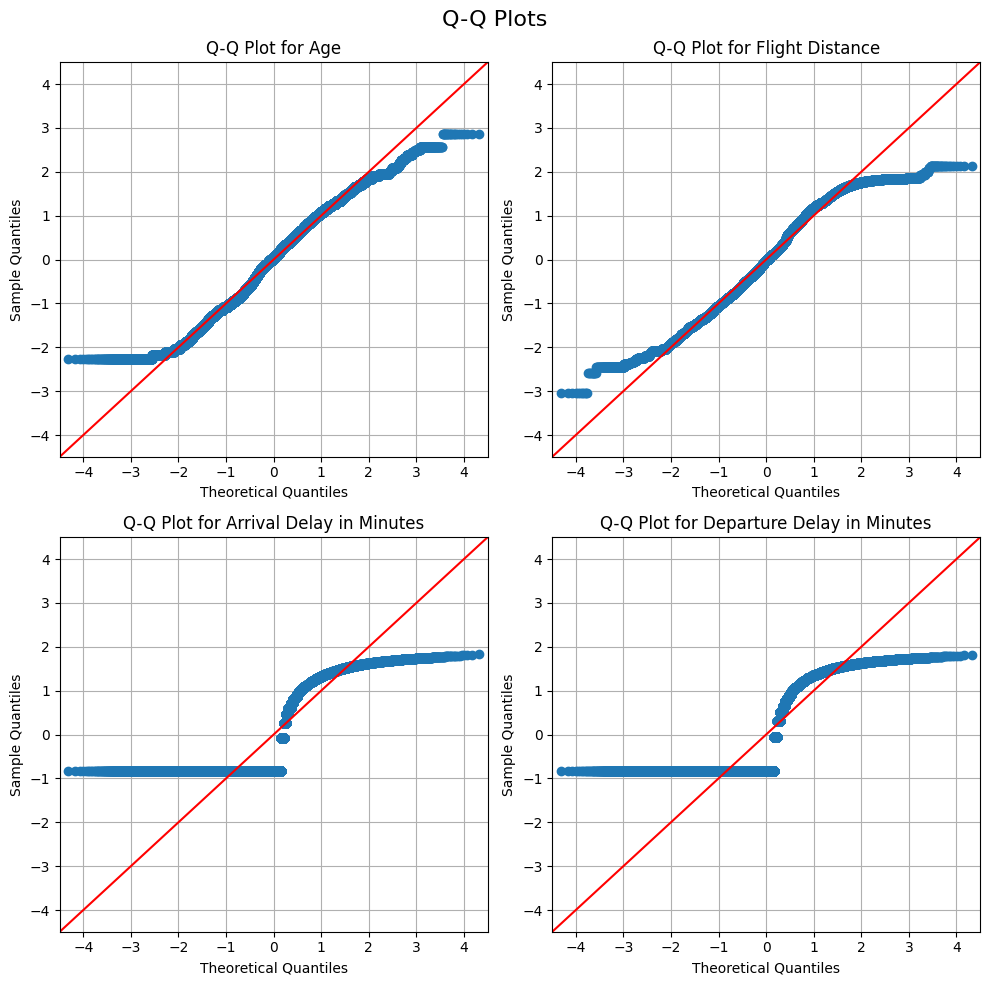

In [ ]:
# List of variables to create Q-Q plots for
variables = ['Age', 'Flight Distance', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']

# Create QQ-plots after Yeo-Johnson
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Q-Q Plots', fontsize=16)

for i, variable in enumerate(variables):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    sm.qqplot(df[variable], line='45', fit=True, ax=ax)
    ax.set_title(f'Q-Q Plot for {variable}')
    ax.grid(True)

fig.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/QQ-plot_after_yeo.png', dpi=300)

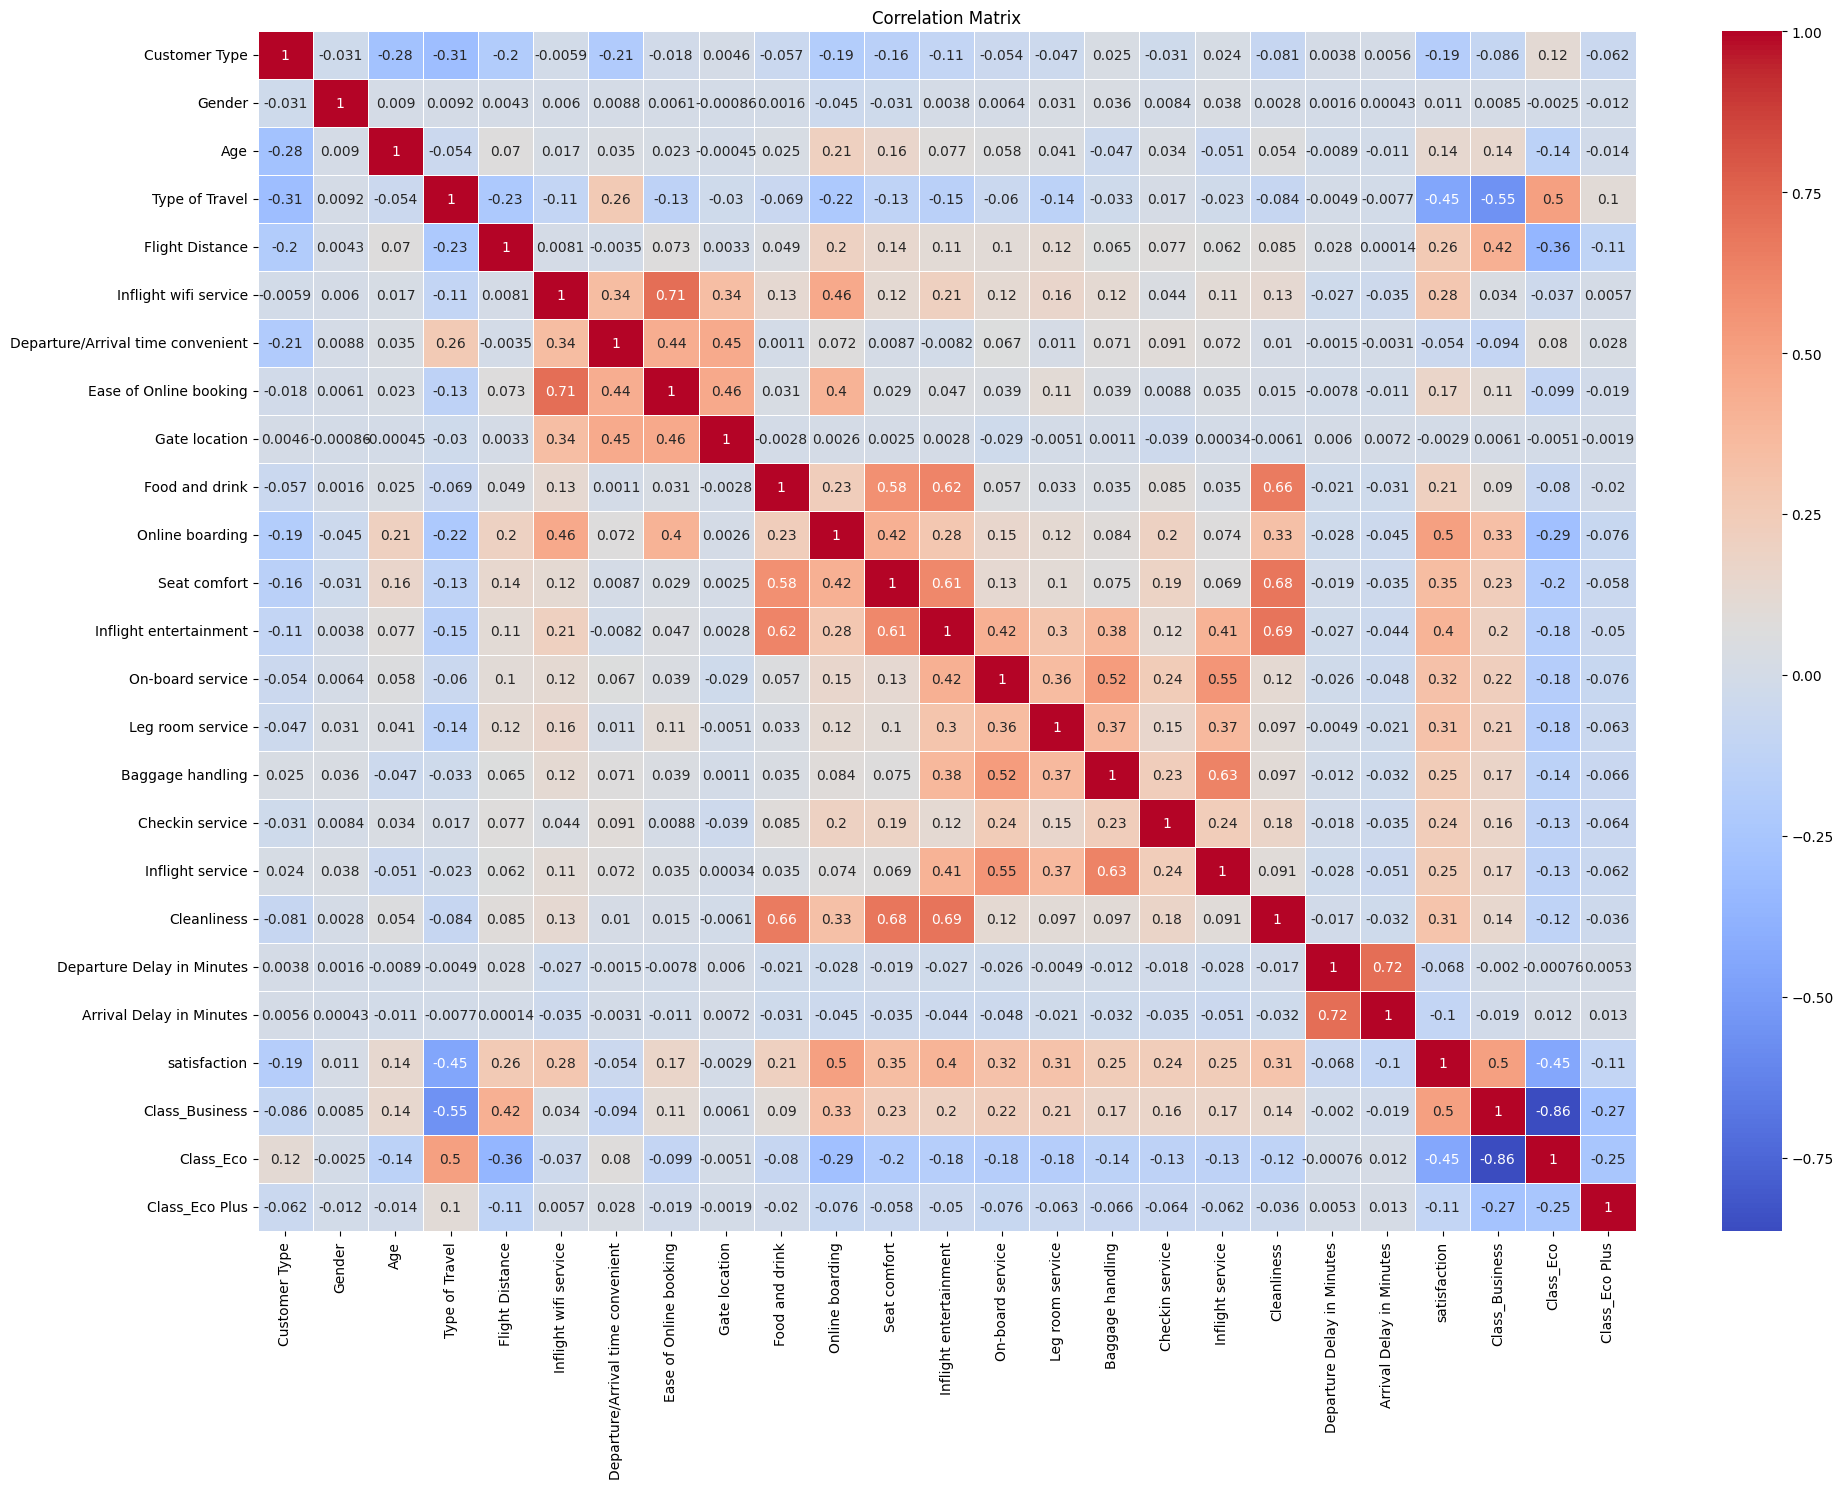

In [ ]:
# Correlation Matrix after Yeo-johnson
correlation_matrix = df.corr()
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
ax.set_title("Correlation Matrix")
# Adjust subplot layout
fig.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Correlation_after_yeo.png', dpi=300)

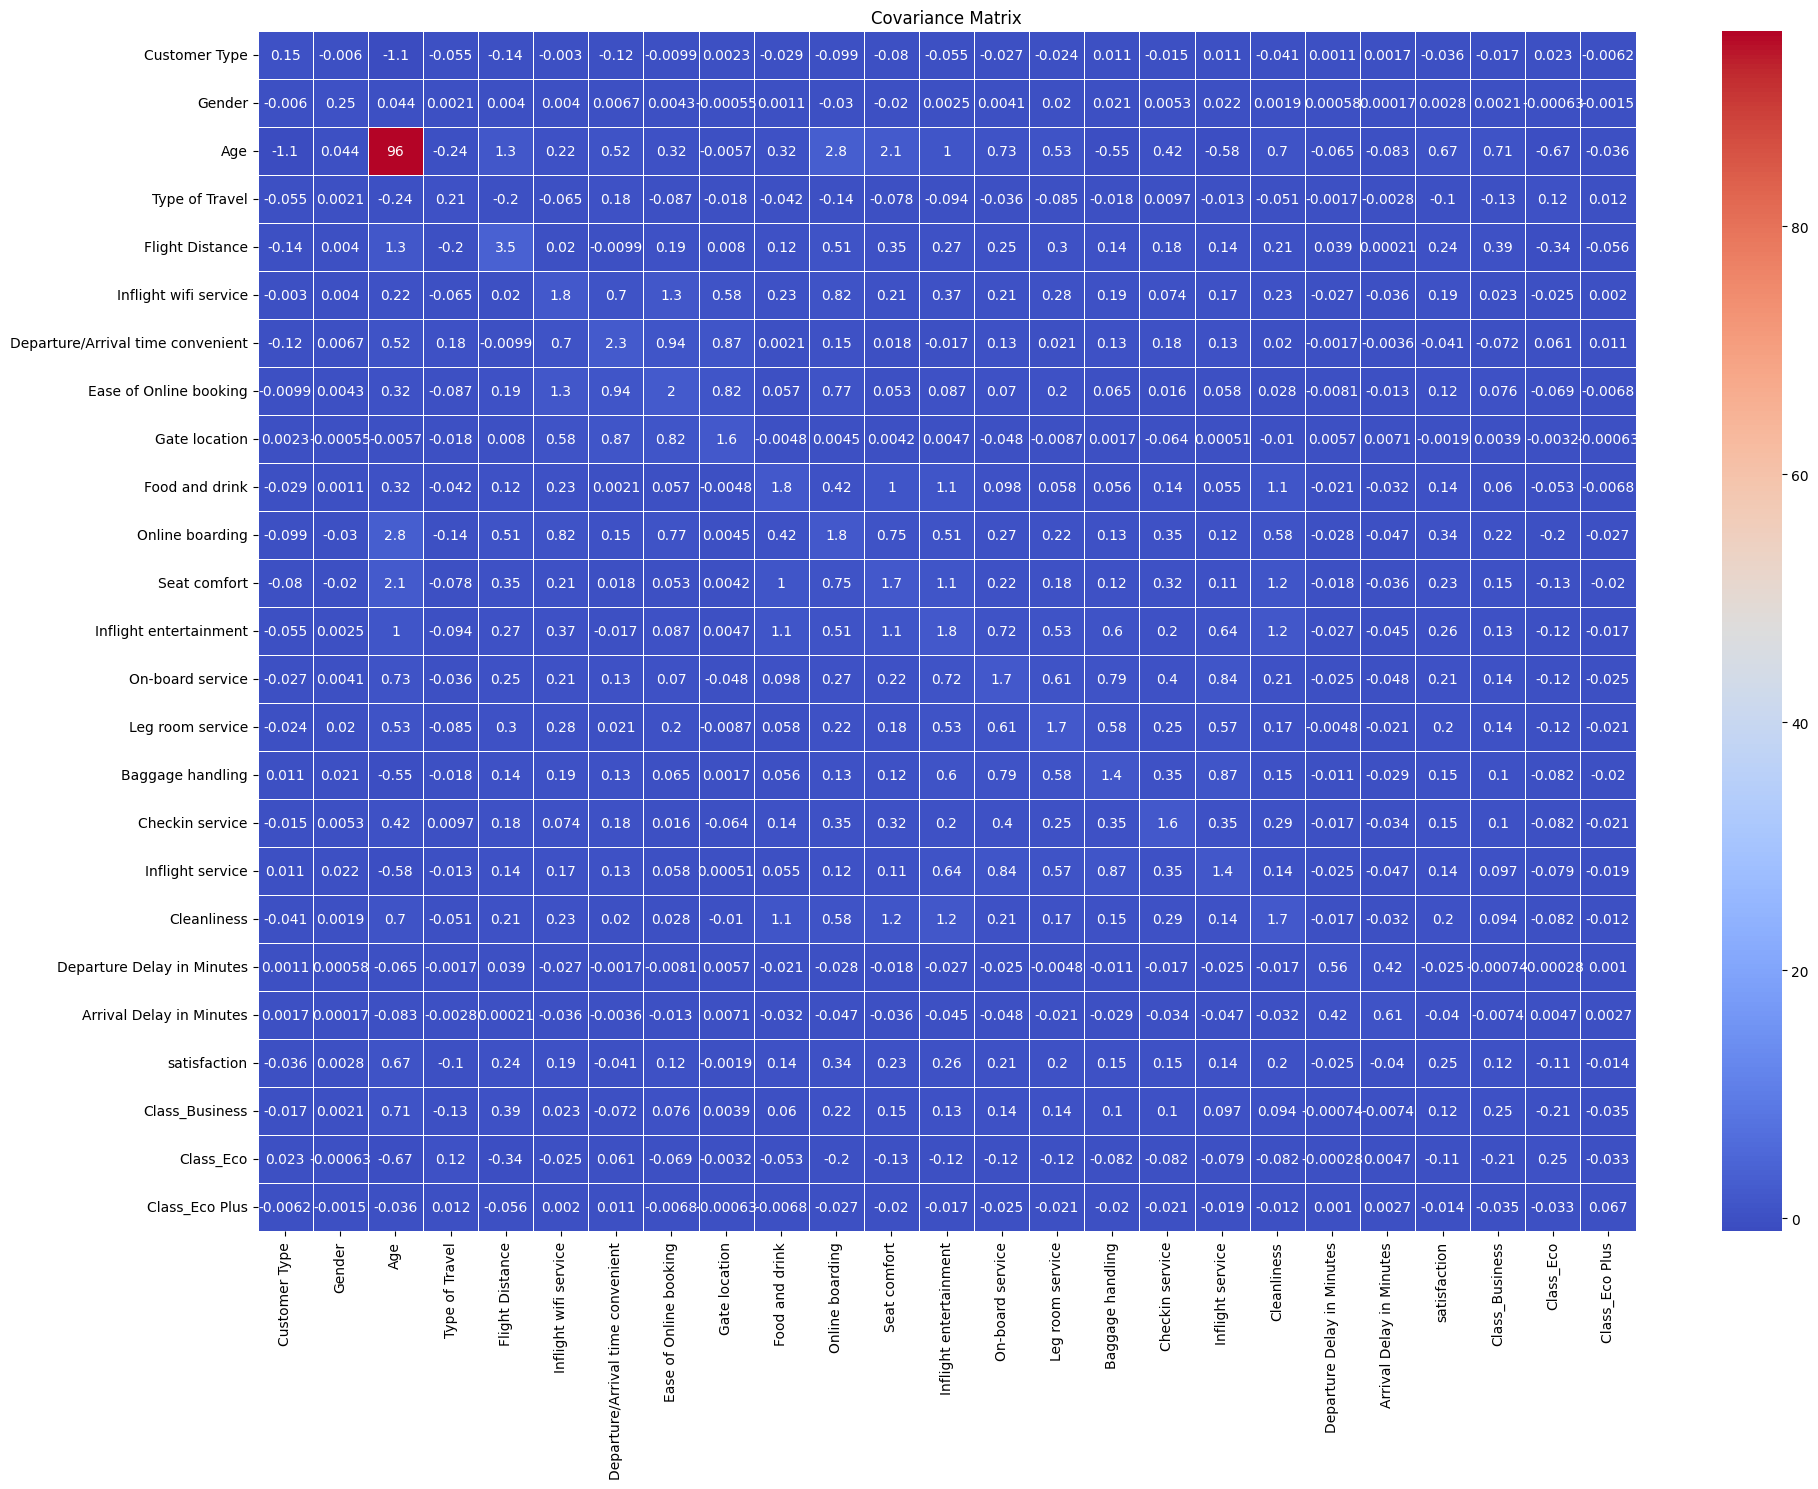

In [ ]:
#Covariance matrix after Yeo-Johnson
covariance_matrix = df.cov()
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(covariance_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
ax.set_title("Covariance Matrix")
# Adjust subplot layout
fig.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Covariance_after_yeo.png', dpi=300)

# Model Selection

In [8]:
#split data in Depentent variable and Indepent variable
X = df.drop('Customer Type', axis = 1)
y = df['Customer Type']
Counter(y)

Counter({0: 105773, 1: 23714})

## Logistic Regression - Baseline model

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.7272390958529095
AUC-PR Score: 0.8083856449139798
G-Mean: 0.5 at threshold 0.7037728684030415
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     63464
           1       0.77      0.69      0.73     14228

    accuracy                           0.91     77692
   macro avg       0.85      0.82      0.83     77692
weighted avg       0.90      0.91      0.90     77692

F1 Score: 0.7333921871551534
AUC-PR Score: 0.8062799391249688
G-Mean: 0.4999999888869373 at threshold 0.7122138000316524
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     21154
           1       0.77      0.70      0.73      4743

    accuracy                           0.91     25897
   macro avg       0.85      0.83      0.84     25897
weighted avg       0.90      0.91      0.90     25897

F1 Score: 0.7300531914893617
AUC-PR Score: 0.8078349816918493
G-Mean: 0.4999999888869373 at threshold 0.709884357592284

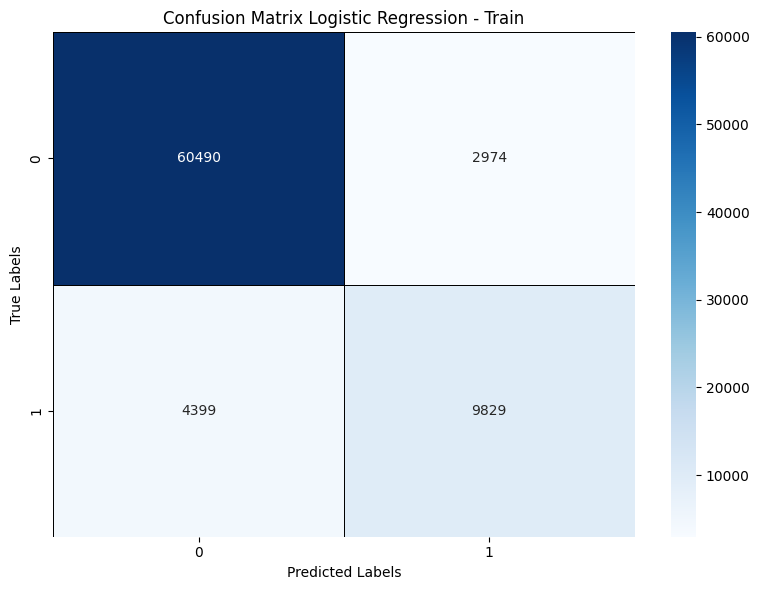

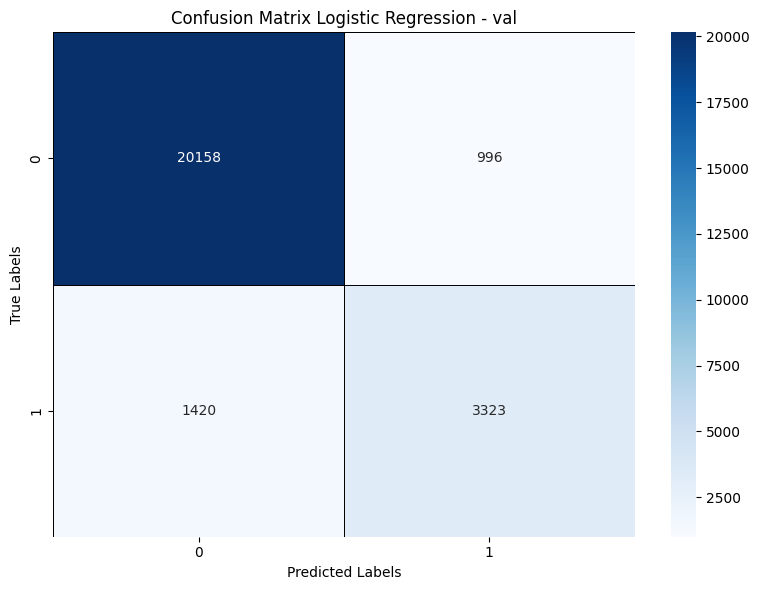

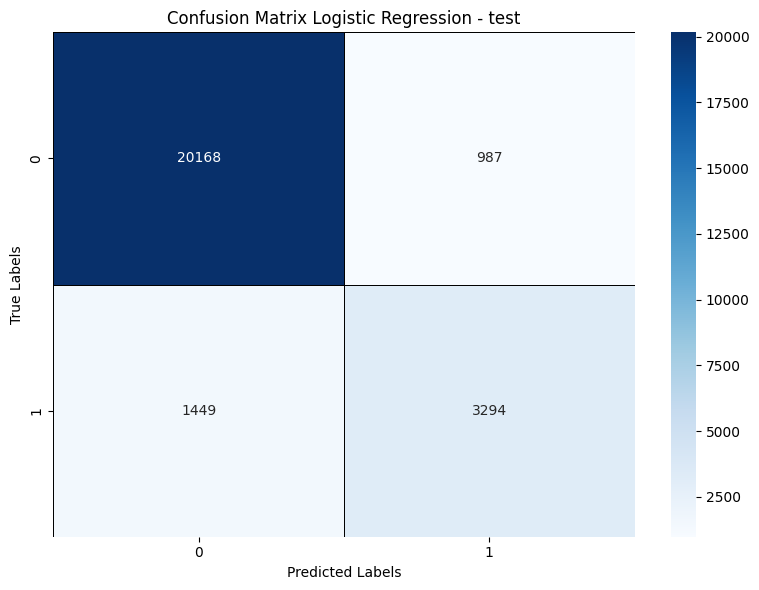

In [9]:
# Split the data into 60% training and 40% temporary for validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=y, random_state=42)

# Split the remaining data (40%) into 50% validation and 50% test - The data is now split in 60% train, 20% validation and, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, stratify=y_temp, random_state=42)

#Scale numerical features
columns_to_scale = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_val[columns_to_scale] = scaler.transform(X_val[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

#Peform Logistic Regression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predictions/probabilities validation
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# predict probabilities
y_probs_train = model.predict_proba(X_train)[:, 1]
y_probs_val = model.predict_proba(X_val)[:, 1]
y_probs_test = model.predict_proba(X_test)[:, 1]

#Evaluation Metrics
f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_val = f1_score(y_val, y_pred_val, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_probs_train)
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_probs_val)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_probs_test)

pr_auc_train = auc(recall_train, precision_train)
pr_auc_val = auc(recall_val, precision_val)
pr_auc_test = auc(recall_test, precision_test)

g_mean_train = np.sqrt(recall_train * (1 - recall_train))
g_mean_val = np.sqrt(recall_val * (1 - recall_val))
g_mean_test = np.sqrt(recall_test * (1 - recall_test))

best_index_train = np.argmax(g_mean_train)
best_index_val = np.argmax(g_mean_val)
best_index_test = np.argmax(g_mean_test)

best_threshold_train = thresholds_train[best_index_train]
best_threshold_val = thresholds_val[best_index_val]
best_threshold_test = thresholds_test[best_index_test]

#Print Train results
print(f"F1 Score: {f1_train}")
print(f"AUC-PR Score: {pr_auc_train}")
print(f"G-Mean: {g_mean_train[best_index_train]} at threshold {best_threshold_train}")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Logistic Regression - Train")
plt.tight_layout()

#Print Validation results
print(f"F1 Score: {f1_val}")
print(f"AUC-PR Score: {pr_auc_val}")
print(f"G-Mean: {g_mean_val[best_index_val]} at threshold {best_threshold_val}")
print(classification_report(y_val, y_pred_val))
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Logistic Regression - val")
plt.tight_layout()

#Print Test results
print(f"F1 Score: {f1_test}")
print(f"AUC-PR Score: {pr_auc_test}")
print(f"G-Mean: {g_mean_test[best_index_test]} at threshold {best_threshold_test}")
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Logistic Regression - test")
plt.tight_layout()

plt.savefig('/content/drive/My Drive/Thesis/Figures/CM_Logistic_Regression_Validation.png', dpi=300)

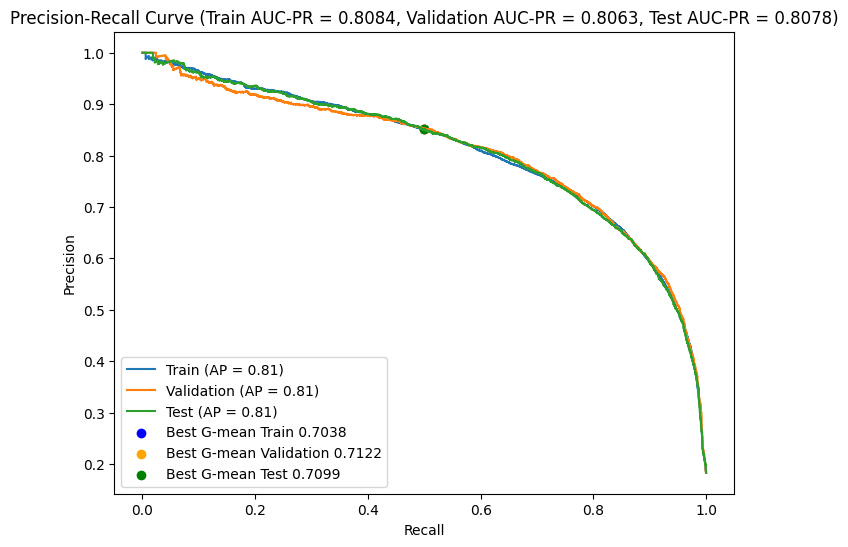

In [ ]:
# Create Precision-Recall curve display
display_train_lg = PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=pr_auc_train)
display_val_lg = PrecisionRecallDisplay(precision=precision_val, recall=recall_val, average_precision=pr_auc_val)
display_test_lg = PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=pr_auc_test)

# Plot both curves on the same plot
plt.figure(figsize=(8, 6))

# Plot training set curve
display_train_lg.plot(ax=plt.gca(), name="Train")
display_val_lg.plot(ax=plt.gca(), name="Validation")
display_test_lg.plot(ax=plt.gca(), name="Test")

# Show AUC-PR values in the plot
plt.title(f'Precision-Recall Curve (Train AUC-PR = {pr_auc_train:.4f}, Validation AUC-PR = {pr_auc_val:.4f}, Test AUC-PR = {pr_auc_test:.4f})')
plt.scatter(recall_train[best_index_train], precision_train[best_index_train], marker='o', color='blue', label=f'Best G-mean Train {best_threshold_train:.4f}')
plt.scatter(recall_val[best_index_val], precision_val[best_index_val], marker='o', color='orange', label=f'Best G-mean Validation {best_threshold_val:.4f}')
plt.scatter(recall_test[best_index_test], precision_test[best_index_test], marker='o', color='green', label=f'Best G-mean Test {best_threshold_test:.4f}')
plt.legend()

# Show the plot
plt.show()

## Feature Selection


In [ ]:
# Define the parameter grid for Random Forest hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

In [ ]:
# Create a StratifiedKFold object for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=10, cv=stratified_cv, scoring='f1', random_state = 42)
random_search.fit(X, y)

# Save the RFECV results to a file
joblib.dump(random_search, 'random_search_results.pkl')

['random_search_results.pkl']

In [ ]:
random_search = joblib.load('random_search_results_thesis.pkl')

# Get the best hyperparameters
best_params = random_search.best_params_

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

print(best_params)

# Check if the best model is a tree-based model (e.g., Random Forest)
if hasattr(best_model, "feature_importances_"):
    # Access feature importances
    feature_importances = best_model.feature_importances_

    # Associate importances with feature names
    feature_scores = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
    print(feature_scores)
else:
    print("The best model does not have feature importances.")

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini'}
Type of Travel                       0.197684
Age                                  0.128790
Departure/Arrival time convenient    0.080126
Flight Distance                      0.070340
Ease of Online booking               0.055694
Online boarding                      0.052096
satisfaction                         0.048679
Gate location                        0.043441
Inflight wifi service                0.041948
Inflight entertainment               0.032575
Inflight service                     0.029067
Seat comfort                         0.027348
Baggage handling                     0.025673
Class_Eco                            0.024474
Class_Business                       0.023460
Cleanliness                          0.021404
Food and drink                       0.018987
On-board service                     0.016937
Checkin service                      0.01

In [ ]:
# Create a StratifiedKFold object for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create an RFECV object with the best RandomForestClassifier and hyperparameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
rfecv = RFECV(estimator=best_rf_classifier, step=1, min_features_to_select = 8, cv=stratified_cv, scoring='f1', verbose = 0)

# Fit the RFECV to your data
rfecv.fit(X, y)

# Print the optimal number of features and their corresponding F1 score
optimal_num_features = rfecv.n_features_
print(f"Optimal Number of Features: {optimal_num_features}")

# Save the RFECV results to a file
joblib.dump(rfecv, 'rfecv_results.pkl')

NameError: ignored

In [ ]:
import joblib

rfecv = joblib.load('rfecv_results_Thesis.pkl')

# Now you can access the attributes of the loaded RFECV object as needed
optimal_num_features = rfecv.n_features_
mean_test_scores = rfecv.cv_results_['mean_test_score']
print(optimal_num_features, mean_test_scores)

sel_wrapper = pd.DataFrame([list(rfecv.support_), list(rfecv.ranking_), list(rfecv.cv_results_['mean_test_score'])], columns=df.columns[1:], index=['Support', 'Ranking', 'Results'])
sel_wrapper.head().T

17 [0.93054638 0.94298527 0.9506401  0.95570808 0.96142014 0.96422206
 0.9663416  0.96696985 0.96888805 0.96986604 0.96940483 0.96898821
 0.96839025 0.967455   0.96735724 0.96598562 0.96691366]


Support Ranking   Results
Gender                              False       8  0.930546
Age                                  True       1  0.942985
Type of Travel                       True       1   0.95064
Flight Distance                      True       1  0.955708
Inflight wifi service                True       1   0.96142
Departure/Arrival time convenient    True       1  0.964222
Ease of Online booking               True       1  0.966342
Gate location                        True       1   0.96697
Food and drink                       True       1  0.968888
Online boarding                      True       1  0.969866
Seat comfort                         True       1  0.969405
Inflight entertainment               True       1  0.968988
On-board service                    False       3   0.96839
Leg room service                    False       4  0.967455
Baggage handling                     True       1  0.967357
Checkin service                     False       2  0.965986
Inflight service                     True       1  0.966914
Cleanliness                          True       1      None
Departure Delay in Minutes          False       6      None
Arrival Delay in Minutes            False       5      None
satisfaction                         True       1      None
Class_Business                       True       1      None
Class_Eco                            True       1      None
Class_Eco Plus                      False       7      None

The optimal number of features: 17


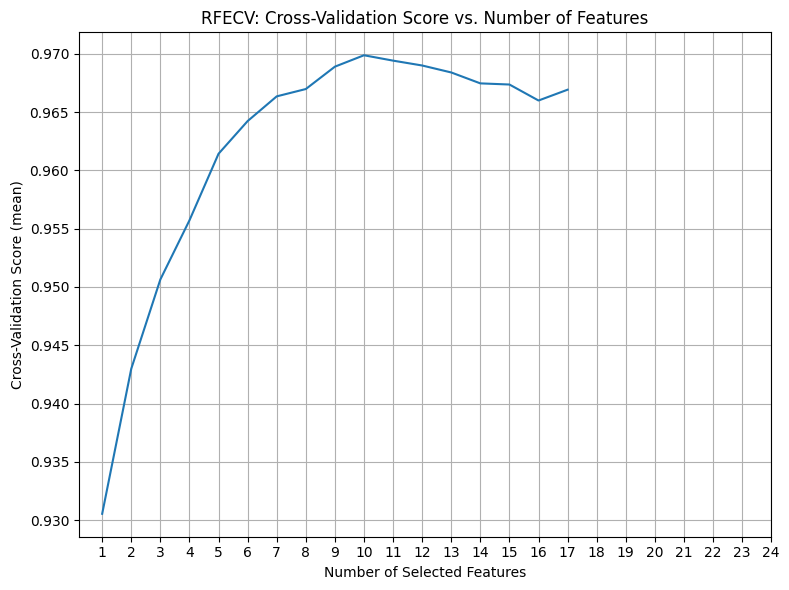

In [ ]:
import matplotlib.pyplot as plt

# Access the cross-validation scores from the RFECV results
scores = rfecv.cv_results_['mean_test_score']

# Plot the scores against the number of selected features
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores)
plt.grid()
plt.xticks(range(1, X.shape[1] + 1))
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validation Score (mean)")
plt.title("RFECV: Cross-Validation Score vs. Number of Features")
plt.tight_layout()

print("The optimal number of features: {}".format(rfecv.n_features_))

plt.savefig('/content/drive/My Drive/Thesis/Figures/Feature_Selection_17.png', dpi=300)

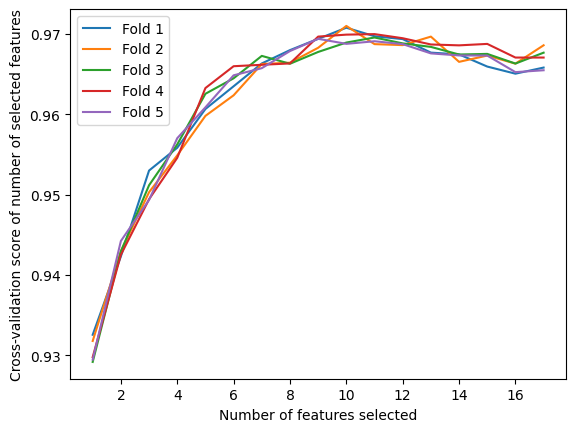

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have computed the cross-validation results and stored them in rfecv.cv_results_

# Extract individual scores for each fold
num_folds = 5  # Replace with your actual number of folds
fold_scores = np.array([rfecv.cv_results_[f'split{i}_test_score'] for i in range(num_folds)])

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score of number of selected features")

# Plot each fold's scores
for i in range(num_folds):
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), fold_scores[i], label=f'Fold {i + 1}')

plt.legend()
plt.show()


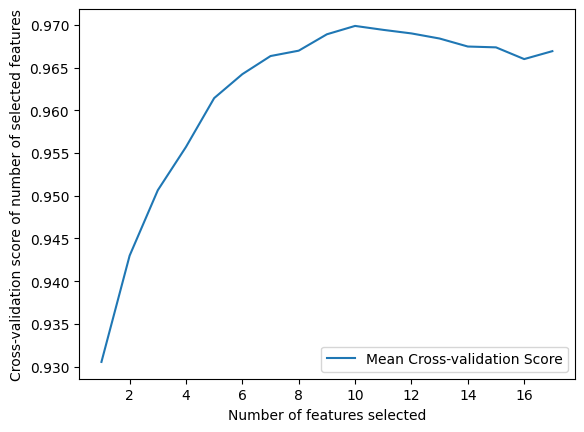

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have computed the cross-validation results and stored them in rfecv.cv_results_

num_features = len(rfecv.cv_results_['mean_test_score'])
selected_features_range = range(1, num_features + 1)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score of number of selected features")

# Plot the mean cross-validation score
plt.plot(selected_features_range, rfecv.cv_results_['mean_test_score'], label='Mean Cross-validation Score')

# Optionally, you can also plot individual fold scores as suggested in the previous response.

plt.legend()
plt.show()


In [ ]:
#Saving dataframe with optimal features
X_rfe = X.iloc[:, rfecv.support_]
X_rfe.shape

(129487, 17)


## Random Forest

In [ ]:
# Assuming X_rfe and y are defined before this code
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [ ]:
# Define the parameter grid for Random Forest hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a StratifiedKFold object for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=10, cv=stratified_cv, scoring='f1', random_state=42)
random_search.fit(X_train, y_train)

# Save the RFECV results to a file
joblib.dump(random_search, 'random_search_RandomForest_results.pkl')

# Get the best hyperparameters
best_params = random_search.best_params_

In [ ]:
random_search = joblib.load('random_search_RandomForest_results.pkl')
best_params = random_search.best_params_
best_params

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini'}

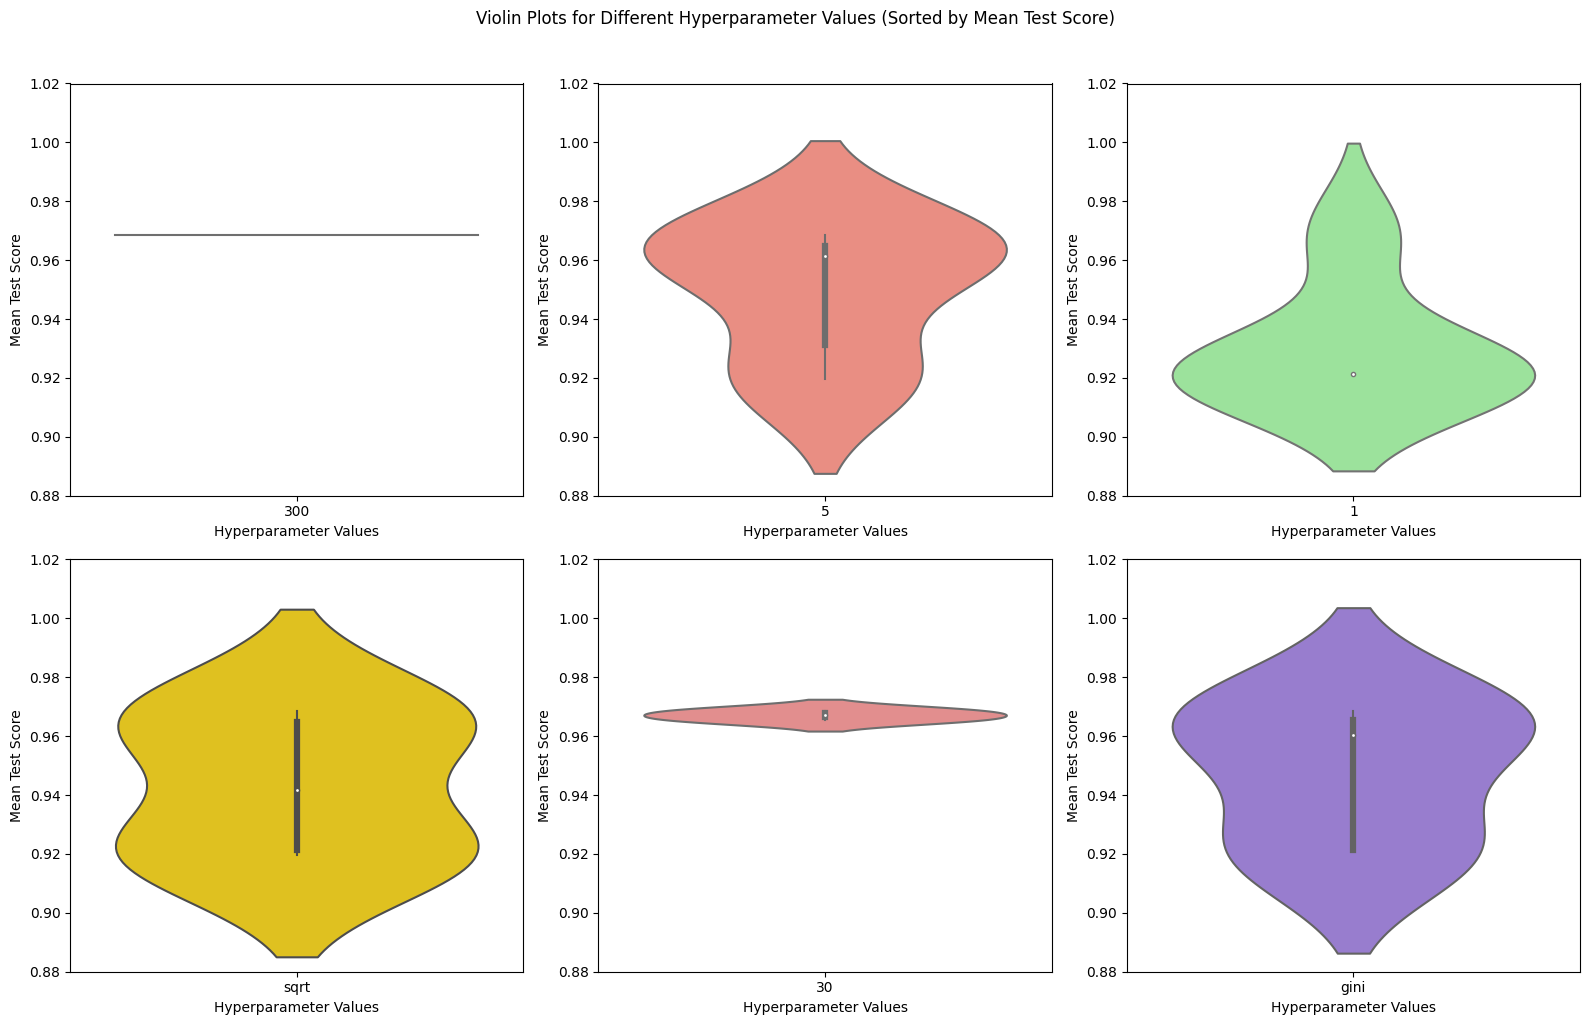

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

# Filter the DataFrame for specific values of each parameter
filtered_n_estimators = results_df_sorted[results_df_sorted['param_n_estimators'] == 300]
filtered_min_samples_split = results_df_sorted[results_df_sorted['param_min_samples_split'] == 5]
filtered_min_samples_leaf = results_df_sorted[results_df_sorted['param_min_samples_leaf'] == 1]
filtered_max_features = results_df_sorted[results_df_sorted['param_max_features'] == 'sqrt']
filtered_max_depth = results_df_sorted[results_df_sorted['param_max_depth'] == 30]
filtered_criterion = results_df_sorted[results_df_sorted['param_criterion'] == 'gini']

# Plot each violin plot in a separate subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten()

sns.violinplot(x='param_n_estimators', y='mean_test_score', data=filtered_n_estimators, color='skyblue', ax=axes[0])
sns.violinplot(x='param_min_samples_split', y='mean_test_score', data=filtered_min_samples_split, color='salmon', ax=axes[1])
sns.violinplot(x='param_min_samples_leaf', y='mean_test_score', data=filtered_min_samples_leaf, color='lightgreen', ax=axes[2])
sns.violinplot(x='param_max_features', y='mean_test_score', data=filtered_max_features, color='gold', ax=axes[3])
sns.violinplot(x='param_max_depth', y='mean_test_score', data=filtered_max_depth, color='lightcoral', ax=axes[4])
sns.violinplot(x='param_criterion', y='mean_test_score', data=filtered_criterion, color='mediumpurple', ax=axes[5])


fig.suptitle('Violin Plots for Different Hyperparameter Values (Sorted by Mean Test Score)', y=1.02)
for ax in axes:
    ax.set_xlabel('Hyperparameter Values')
    ax.set_ylabel('Mean Test Score')
    ax.set_ylim(0.88, 1.02)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Adasyn_hyperparamet_sorted.png', dpi=300)


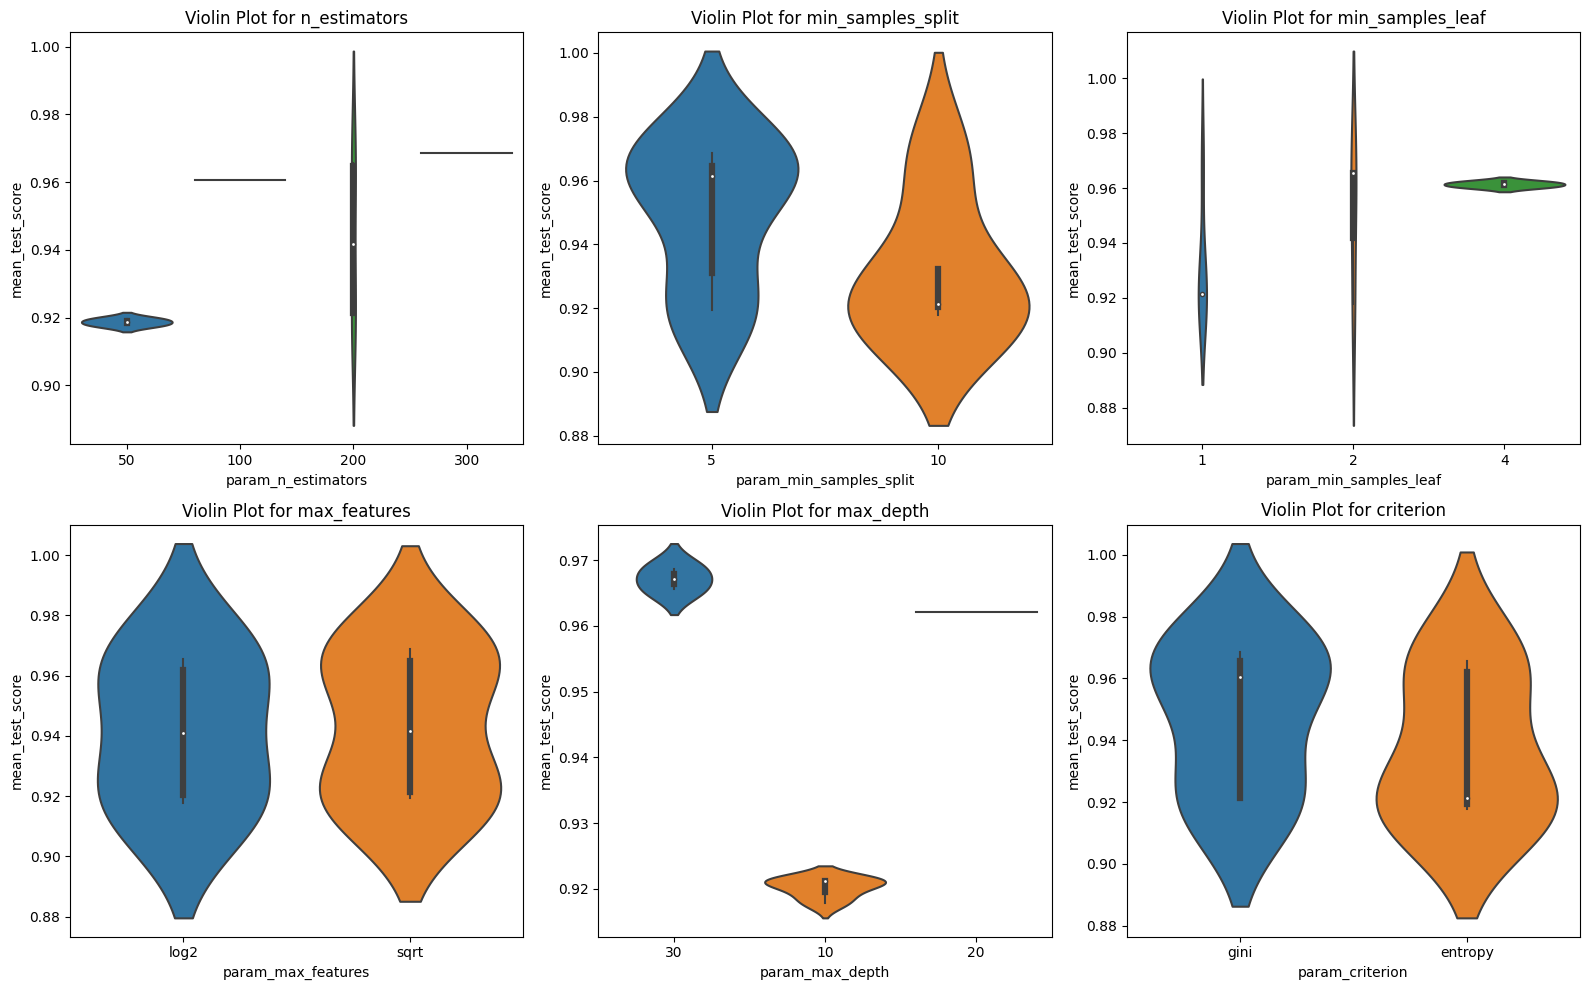

In [ ]:
# Extract the relevant information from the grid search results
results_df = pd.DataFrame(random_search.cv_results_)

# Create violin plots for n_estimators and min_samples_split
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
sns.violinplot(x='param_n_estimators', y='mean_test_score', data=results_df)
plt.title('Violin Plot for n_estimators')

plt.subplot(2, 3, 2)
sns.violinplot(x='param_min_samples_split', y='mean_test_score', data=results_df)
plt.title('Violin Plot for min_samples_split')

plt.subplot(2, 3, 3)
sns.violinplot(x='param_min_samples_leaf', y='mean_test_score', data=results_df)
plt.title('Violin Plot for min_samples_leaf')

plt.subplot(2, 3, 4)
sns.violinplot(x='param_max_features', y='mean_test_score', data=results_df)
plt.title('Violin Plot for max_features')

plt.subplot(2, 3, 5)
sns.violinplot(x='param_max_depth', y='mean_test_score', data=results_df)
plt.title('Violin Plot for max_depth')

plt.subplot(2, 3, 6)
sns.violinplot(x='param_criterion', y='mean_test_score', data=results_df)
plt.title('Violin Plot for criterion')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/Adasyn_hyperparamet.png', dpi=300)

In [ ]:
# Define a range of values for sampling strategy and n_neighbors
param_grid = {
    'adasyn__sampling_strategy': [0.3, 0.5, 0.6, 1],
    'adasyn__n_neighbors': [3, 5, 7,]
}

# Create ADASYN object
adasyn = ADASYN(random_state=42)

# Create a RandomForestClassifier
classifier = RandomForestClassifier(random_state=42, **best_params)

# Create a pipeline with ADASYN and the classifier
pipeline = Pipeline([
    ('adasyn', adasyn),
    ('classifier', classifier)
])

# Create a StratifiedKFold object for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters
#random_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=stratified_cv, scoring='f1')
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10, cv=stratified_cv, scoring='f1', random_state = 42)

# Fit the grid search
random_search.fit(X_rfe, y_train)

# Get the best parameters from the grid search
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Make predictions on the test set
y_pred = random_search.predict(X_test)

# Calculate performance metrics
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


ValueError: ignored

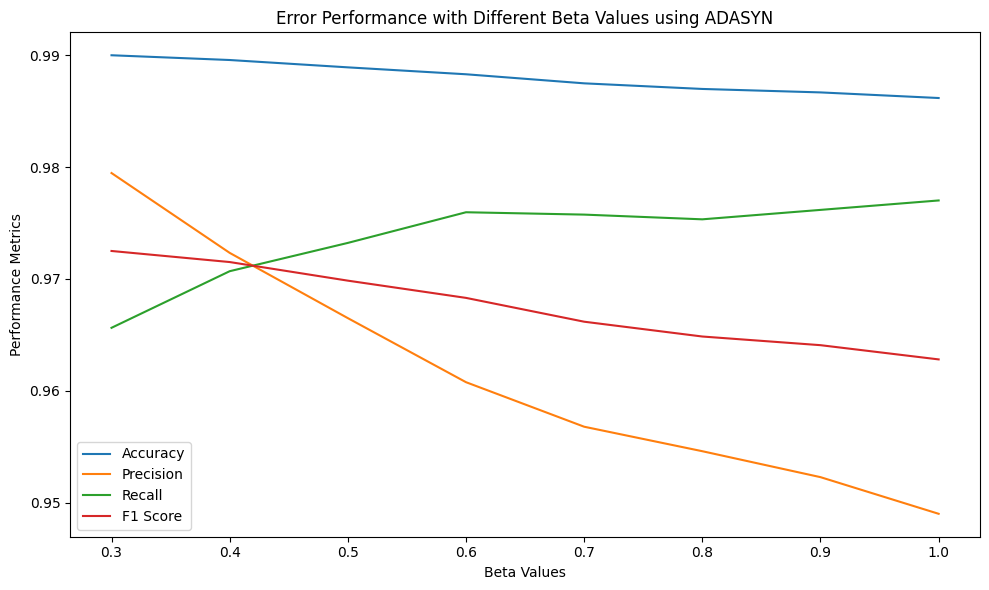

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Define a range of beta values to loop through
beta_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Lists to store performance metrics for each beta value
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through different beta values
for beta in beta_values:
    # Create and fit ADASYN to the training data
    adasyn = ADASYN(sampling_strategy=beta, n_neighbors= 7, random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

    # Train a classifier on the resampled data
    classifier = RandomForestClassifier(**best_params, random_state=42)
    classifier.fit(X_resampled, y_resampled)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(beta_values, accuracy_scores, label='Accuracy')
plt.plot(beta_values, precision_scores, label='Precision')
plt.plot(beta_values, recall_scores, label='Recall')
plt.plot(beta_values, f1_scores, label='F1 Score')
plt.xlabel('Beta Values')
plt.ylabel('Performance Metrics')
plt.title('Error Performance with Different Beta Values using ADASYN')
plt.legend()
plt.tight_layout()


plt.savefig('/content/drive/My Drive/Thesis/Figures/Error Performance with Different Beta Values using ADASYN.png', dpi=300)

### Random Forest ADASYN

In [ ]:
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for 5-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Adasyn with Best beta value and number of neighbours
adasyn = ADASYN(sampling_strategy=0.3, n_neighbors=7, random_state=42)

# Perform Random Forest with the best_params out of the RandomSearchCV
model = RandomForestClassifier(random_state=42, **best_params)

#Empty lists train folds
lst_f1_scores_adasyn_train = []
lst_gmean_adasyn_train = []
lst_treshold_adasyn_train = []
lst_auc_pr_adasyn_train = []
lst_classification_reports_adasyn_train = []
lst_confusion_matrix_adasyn_train = []

#Empty lists validation folds
lst_f1_scores_adasyn_val = []
lst_gmean_adasyn_val = []
lst_treshold_adasyn_val = []
lst_auc_pr_adasyn_val = []
lst_classification_reports_adasyn_val = []
lst_confusion_matrix_adasyn_val = []

#Peform stratified 5-fold cross-validation with Adasyn and Random Forest
for train_index, test_index in stratified_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply ADASYN for oversampling on the training data
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_fold, y_train_fold)

    # Train your model
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions/probabilities validation
    y_pred_train = model.predict(X_train_fold)
    y_pred_val = model.predict(X_val_fold)

    y_probs_train = model.predict_proba(X_train_fold)[:, 1]
    y_probs_val = model.predict_proba(X_val_fold)[:, 1]

    #Evaluation Metrics
    f1_train = f1_score(y_train_fold, y_pred_train, pos_label=1)
    f1_val = f1_score(y_val_fold, y_pred_val, pos_label=1)

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train_fold, y_probs_train)
    precision_val, recall_val, thresholds_val = precision_recall_curve(y_val_fold, y_probs_val)

    pr_auc_train = auc(recall_train, precision_train)
    pr_auc_val = auc(recall_val, precision_val)

    g_mean_train = np.sqrt(recall_train * (1 - recall_train))
    g_mean_val = np.sqrt(recall_val * (1 - recall_val))

    best_index_train = np.argmax(g_mean_train)
    best_index_val = np.argmax(g_mean_val)

    best_threshold_train = thresholds_train[best_index_train]
    best_threshold_val = thresholds_val[best_index_val]

    report_train = classification_report(y_train_fold, y_pred_train, target_names=["Class 0", "Class 1"])
    report_val = classification_report(y_val_fold, y_pred_val, target_names=["Class 0", "Class 1"])

    cm_train = confusion_matrix(y_train_fold, y_pred_train)
    cm_val = confusion_matrix(y_val_fold, y_pred_val)

    #Append list with scores train folds
    lst_f1_scores_adasyn_train.append(f1_train)
    lst_gmean_adasyn_train.append(g_mean_train[best_index_train])
    lst_treshold_adasyn_train.append(best_threshold_train)
    lst_auc_pr_adasyn_train.append(pr_auc_train)
    lst_classification_reports_adasyn_train.append(report_train)
    lst_confusion_matrix_adasyn_train.append(cm_train)

    #Append list with scores test folds
    lst_f1_scores_adasyn_val.append(f1_val)
    lst_gmean_adasyn_val.append(g_mean_val[best_index_val])
    lst_treshold_adasyn_val.append(best_threshold_val)
    lst_auc_pr_adasyn_val.append(pr_auc_val)
    lst_classification_reports_adasyn_val.append(report_val)
    lst_confusion_matrix_adasyn_val.append(cm_val)

# Display scores for each training fold
for i, f1_train in enumerate(lst_f1_scores_adasyn_train):
    print(f"F1 Score - Training Fold {i+1}: {f1_train}")
for i, best_index_train in enumerate(lst_gmean_adasyn_train):
    print(f"G-Mean - Training Fold {i+1}: {best_index_train}")
for i, best_threshold_train in enumerate(lst_treshold_adasyn_train):
    print(f"G-Mean Treshold - Training Fold {i+1}: {best_threshold_train}")
for i, pr_auc_train in enumerate(lst_auc_pr_adasyn_train):
    print(f"AUC-PR - Training Fold {i+1}: {pr_auc_train}")
for i, report_train in enumerate(lst_classification_reports_adasyn_train):
    print(f"Classification Report - Training Fold {i+1}:\n{report_train}")
for i, cm_train in enumerate(lst_confusion_matrix_adasyn_train):
    print(f"Confusion Matrix - Training Fold {i+1}:\n{cm_train}")

# Display scores for each validation fold
for i, f1_val in enumerate(lst_f1_scores_adasyn_val):
    print(f"F1 Score - validation Fold {i+1}: {f1_val}")
for i, best_index_val in enumerate(lst_gmean_adasyn_val):
    print(f"G-Mean - validation Fold {i+1}: {best_index_val}")
for i, best_threshold_val in enumerate(lst_treshold_adasyn_val):
    print(f"G-Mean Treshold - validation Fold {i+1}: {best_threshold_val}")
for i, pr_auc_val in enumerate(lst_auc_pr_adasyn_val):
    print(f"AUC-PR - validation Fold {i+1}: {pr_auc_val}")
for i, report_val in enumerate(lst_classification_reports_adasyn_val):
    print(f"Classification Report - validation Fold {i+1}:\n{report_val}")
for i, cm_val in enumerate(lst_confusion_matrix_adasyn_val):
    print(f"Confusion Matrix - validation Fold {i+1}:\n{cm_val}")

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for training folds
avg_f1_train = np.mean(lst_f1_scores_adasyn_train)
avg_gmean_train = np.mean(lst_gmean_adasyn_train)
avg_treshold_train = np.mean(lst_treshold_adasyn_train)
avg_aucpr_train = np.mean(lst_auc_pr_adasyn_train)
avg_confusion_matrix_train = np.mean(lst_confusion_matrix_adasyn_train, axis=0)

# Create a DataFrame to store the averages of the training folds
average_metrics_df_train = pd.DataFrame({
    'Average F1 Score': [avg_f1_train],
    'Average G-Mean': [avg_gmean_train],
    'Average Treshold': [avg_treshold_train],
    'Average AUC-PR': [avg_aucpr_train],
    'Average Confusion Matrix': [avg_confusion_matrix_train]
})

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for validation folds
avg_f1_val = np.mean(lst_f1_scores_adasyn_val)
avg_gmean_val = np.mean(lst_gmean_adasyn_val)
avg_treshold_val = np.mean(lst_treshold_adasyn_val)
avg_aucpr_val = np.mean(lst_auc_pr_adasyn_val)
avg_confusion_matrix_val = np.mean(lst_confusion_matrix_adasyn_val, axis=0)

# Create a DataFrame to store the averages of the validation folds
average_metrics_df_val = pd.DataFrame({
    'Average F1 Score': [avg_f1_val],
    'Average G-Mean': [avg_gmean_val],
    'Average Treshold': [avg_treshold_val],
    'Average AUC-PR': [avg_aucpr_val],
    'Average Confusion Matrix': [avg_confusion_matrix_val]
})

# Display the DataFrame
print(average_metrics_df_train)
print(average_metrics_df_val)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(np.round(avg_confusion_matrix).astype(int), annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Averaged Confusion Matrix Random Forest - Validation 5-Fold")
# plt.tight_layout()

# plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_RF_Adasyn_validation.png', dpi=300)

F1 Score - Training Fold 1: 0.9926543577526306
F1 Score - Training Fold 2: 0.9933503159427003
F1 Score - Training Fold 3: 0.9927886205755874
F1 Score - Training Fold 4: 0.9932193298713327
F1 Score - Training Fold 5: 0.9931860280497486
G-Mean - Training Fold 1: 0.4999999826321778
G-Mean - Training Fold 2: 0.4999999902318875
G-Mean - Training Fold 3: 0.4999999989146542
G-Mean - Training Fold 4: 0.4999999989146542
G-Mean - Training Fold 5: 0.49999999023188746
G-Mean Treshold - Training Fold 1: 0.9898333333333335
G-Mean Treshold - Training Fold 2: 0.9895555555555557
G-Mean Treshold - Training Fold 3: 0.9893055555555557
G-Mean Treshold - Training Fold 4: 0.9891666666666666
G-Mean Treshold - Training Fold 5: 0.9888888888888888
AUC-PR - Training Fold 1: 0.9998690676396247
AUC-PR - Training Fold 2: 0.9998991629284528
AUC-PR - Training Fold 3: 0.9998818852602123
AUC-PR - Training Fold 4: 0.9998811422286508
AUC-PR - Training Fold 5: 0.9998793677434271
Classification Report - Training Fold 1:
   

Counter({0: 84618, 1: 18971})
Counter({0: 84618, 1: 24218})
F1 Score: 0.9927772045400429
AUC-PR Score: 0.9998907462148747
G-Mean: 0.4999999993053604 at threshold 0.991031746031746
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84618
           1       1.00      0.99      0.99     18971

    accuracy                           1.00    103589
   macro avg       1.00      0.99      1.00    103589
weighted avg       1.00      1.00      1.00    103589

F1 Score: 0.9725023887886187
AUC-PR Score: 0.9923765338798177
G-Mean: 0.4999999888869373 at threshold 0.98425
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21155
           1       0.98      0.97      0.97      4743

    accuracy                           0.99     25898
   macro avg       0.99      0.98      0.98     25898
weighted avg       0.99      0.99      0.99     25898



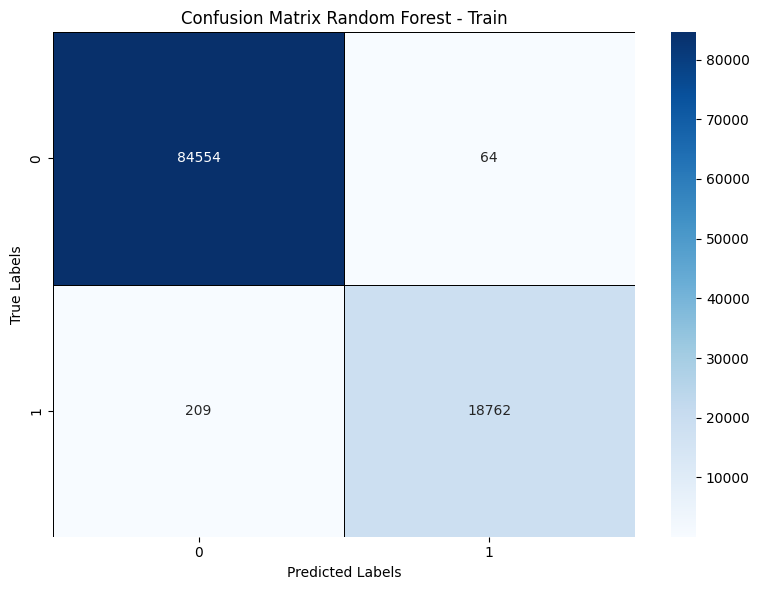

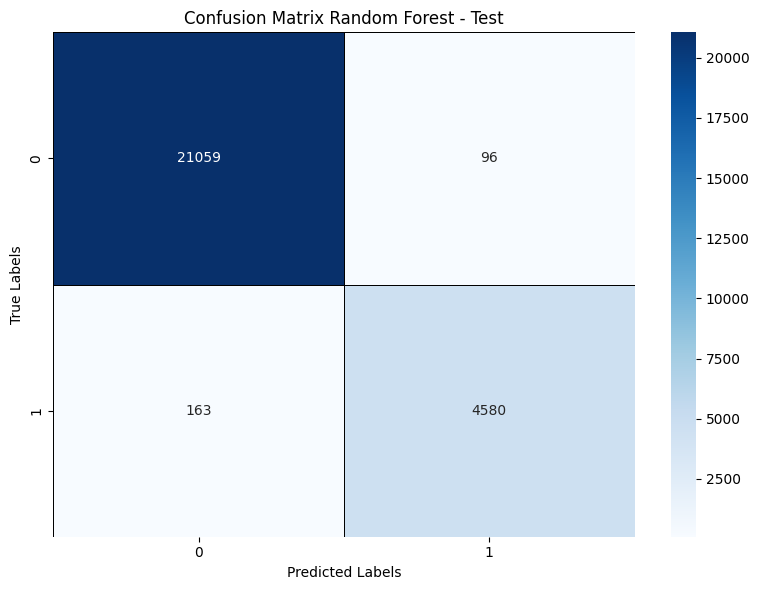

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an ADASYN sampler
adasyn = ADASYN(sampling_strategy=0.3, n_neighbors=7, random_state=42)

# Initialize your machine learning model
model = RandomForestClassifier(random_state=42, **best_params)
print(Counter(y_train))
# Apply ADASYN for oversampling on the training data
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
print(Counter(y_train_resampled))
# Fit the logistic regression model on the training data
model.fit(X_train_resampled, y_train_resampled)

# Predictions/probabilities validation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# predict probabilities
y_probs_train = model.predict_proba(X_train)[:, 1]
y_probs_test = model.predict_proba(X_test)[:, 1]

#Evaluation Metrics
f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_probs_train)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_probs_test)

pr_auc_train = auc(recall_train, precision_train)
pr_auc_test = auc(recall_test, precision_test)

g_mean_train = np.sqrt(recall_train * (1 - recall_train))
g_mean_test = np.sqrt(recall_test * (1 - recall_test))

best_index_train = np.argmax(g_mean_train)
best_index_test = np.argmax(g_mean_test)

best_threshold_train = thresholds_train[best_index_train]
best_threshold_test = thresholds_test[best_index_test]

#Print Train results
print(f"F1 Score: {f1_train}")
print(f"AUC-PR Score: {pr_auc_train}")
print(f"G-Mean: {g_mean_train[best_index_train]} at threshold {best_threshold_train}")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest - Train")
plt.tight_layout()

#Print Test results
print(f"F1 Score: {f1_test}")
print(f"AUC-PR Score: {pr_auc_test}")
print(f"G-Mean: {g_mean_test[best_index_test]} at threshold {best_threshold_test}")
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest - Test")
plt.tight_layout()

# plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_RF_Adasyn_test.png', dpi=300)



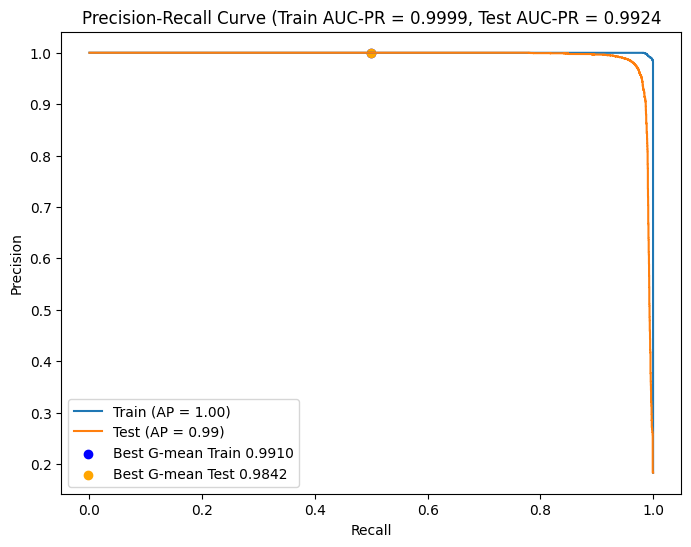

In [ ]:
# Create Precision-Recall curve display
display_train_rf_adasyn = PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=pr_auc_train)
display_test_rf_adasyn = PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=pr_auc_test)

# Plot both curves on the same plot
plt.figure(figsize=(8, 6))

# Plot training set curve
display_train_rf_adasyn.plot(ax=plt.gca(), name="Train")
display_test_rf_adasyn.plot(ax=plt.gca(), name="Test")

# Show AUC-PR values in the plot
plt.title(f'Precision-Recall Curve (Train AUC-PR = {pr_auc_train:.4f}, Test AUC-PR = {pr_auc_test:.4f}')
plt.scatter(recall_train[best_index_train], precision_train[best_index_train], marker='o', color='blue', label=f'Best G-mean Train {best_threshold_train:.4f}')
plt.scatter(recall_test[best_index_test], precision_test[best_index_test], marker='o', color='orange', label=f'Best G-mean Test {best_threshold_test:.4f}')
plt.legend()

# Show the plot
plt.show()

### Random Forest Tomek Links

In [ ]:
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for 5-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tomek Links with Sampling Strategy Majority
tl = TomekLinks(sampling_strategy = 'majority')

# Perform Random Forest with the best_params out of the RandomSearchCV
model = RandomForestClassifier(random_state=42, **best_params)

#Empty lists train folds
lst_f1_scores_tl_train = []
lst_gmean_tl_train = []
lst_treshold_tl_train = []
lst_auc_pr_tl_train = []
lst_classification_reports_tl_train = []
lst_confusion_matrix_tl_train = []

#Empty lists validation folds
lst_f1_scores_tl_val = []
lst_gmean_tl_val = []
lst_treshold_tl_val = []
lst_auc_pr_tl_val = []
lst_classification_reports_tl_val = []
lst_confusion_matrix_tl_val = []

#Peform stratified 5-fold cross-validation with Tomek Links and Random Forest
for train_index, test_index in stratified_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply tl for oversampling on the training data
    X_train_resampled, y_train_resampled = tl.fit_resample(X_train_fold, y_train_fold)

    # Train your model
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions/probabilities validation
    y_pred_train = model.predict(X_train_fold)
    y_pred_val = model.predict(X_val_fold)

    y_probs_train = model.predict_proba(X_train_fold)[:, 1]
    y_probs_val = model.predict_proba(X_val_fold)[:, 1]

    #Evaluation Metrics
    f1_train = f1_score(y_train_fold, y_pred_train, pos_label=1)
    f1_val = f1_score(y_val_fold, y_pred_val, pos_label=1)

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train_fold, y_probs_train)
    precision_val, recall_val, thresholds_val = precision_recall_curve(y_val_fold, y_probs_val)

    pr_auc_train = auc(recall_train, precision_train)
    pr_auc_val = auc(recall_val, precision_val)

    g_mean_train = np.sqrt(recall_train * (1 - recall_train))
    g_mean_val = np.sqrt(recall_val * (1 - recall_val))

    best_index_train = np.argmax(g_mean_train)
    best_index_val = np.argmax(g_mean_val)

    best_threshold_train = thresholds_train[best_index_train]
    best_threshold_val = thresholds_val[best_index_val]

    report_train = classification_report(y_train_fold, y_pred_train, target_names=["Class 0", "Class 1"])
    report_val = classification_report(y_val_fold, y_pred_val, target_names=["Class 0", "Class 1"])

    cm_train = confusion_matrix(y_train_fold, y_pred_train)
    cm_val = confusion_matrix(y_val_fold, y_pred_val)

    #Append list with scores train folds
    lst_f1_scores_tl_train.append(f1_train)
    lst_gmean_tl_train.append(g_mean_train[best_index_train])
    lst_treshold_tl_train.append(best_threshold_train)
    lst_auc_pr_tl_train.append(pr_auc_train)
    lst_classification_reports_tl_train.append(report_train)
    lst_confusion_matrix_tl_train.append(cm_train)

    #Append list with scores test folds
    lst_f1_scores_tl_val.append(f1_val)
    lst_gmean_tl_val.append(g_mean_val[best_index_val])
    lst_treshold_tl_val.append(best_threshold_val)
    lst_auc_pr_tl_val.append(pr_auc_val)
    lst_classification_reports_tl_val.append(report_val)
    lst_confusion_matrix_tl_val.append(cm_val)

# Display scores for each training fold
for i, f1_train in enumerate(lst_f1_scores_tl_train):
    print(f"F1 Score - Training Fold {i+1}: {f1_train}")
for i, best_index_train in enumerate(lst_gmean_tl_train):
    print(f"G-Mean - Training Fold {i+1}: {best_index_train}")
for i, best_threshold_train in enumerate(lst_treshold_tl_train):
    print(f"G-Mean Treshold - Training Fold {i+1}: {best_threshold_train}")
for i, pr_auc_train in enumerate(lst_auc_pr_tl_train):
    print(f"AUC-PR - Training Fold {i+1}: {pr_auc_train}")
for i, report_train in enumerate(lst_classification_reports_tl_train):
    print(f"Classification Report - Training Fold {i+1}:\n{report_train}")
for i, cm_train in enumerate(lst_confusion_matrix_tl_train):
    print(f"Confusion Matrix - Training Fold {i+1}:\n{cm_train}")

# Display scores for each validation fold
for i, f1_val in enumerate(lst_f1_scores_tl_val):
    print(f"F1 Score - validation Fold {i+1}: {f1_val}")
for i, best_index_val in enumerate(lst_gmean_tl_val):
    print(f"G-Mean - validation Fold {i+1}: {best_index_val}")
for i, best_threshold_val in enumerate(lst_treshold_tl_val):
    print(f"G-Mean Treshold - validation Fold {i+1}: {best_threshold_val}")
for i, pr_auc_val in enumerate(lst_auc_pr_tl_val):
    print(f"AUC-PR - validation Fold {i+1}: {pr_auc_val}")
for i, report_val in enumerate(lst_classification_reports_tl_val):
    print(f"Classification Report - validation Fold {i+1}:\n{report_val}")
for i, cm_val in enumerate(lst_confusion_matrix_tl_val):
    print(f"Confusion Matrix - validation Fold {i+1}:\n{cm_val}")

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for training folds
avg_f1_train = np.mean(lst_f1_scores_tl_train)
avg_gmean_train = np.mean(lst_gmean_tl_train)
avg_treshold_train = np.mean(lst_treshold_tl_train)
avg_aucpr_train = np.mean(lst_auc_pr_tl_train)
avg_confusion_matrix_train = np.mean(lst_confusion_matrix_tl_train, axis=0)

# Create a DataFrame to store the averages of the training folds
average_metrics_df_train = pd.DataFrame({
    'Average F1 Score': [avg_f1_train],
    'Average G-Mean': [avg_gmean_train],
    'Average Treshold': [avg_treshold_train],
    'Average AUC-PR': [avg_aucpr_train],
    'Average Confusion Matrix': [avg_confusion_matrix_train]
})

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for validation folds
avg_f1_val = np.mean(lst_f1_scores_tl_val)
avg_gmean_val = np.mean(lst_gmean_tl_val)
avg_treshold_val = np.mean(lst_treshold_tl_val)
avg_aucpr_val = np.mean(lst_auc_pr_tl_val)
avg_confusion_matrix_val = np.mean(lst_confusion_matrix_tl_val, axis=0)

# Create a DataFrame to store the averages of the validation folds
average_metrics_df_val = pd.DataFrame({
    'Average F1 Score': [avg_f1_val],
    'Average G-Mean': [avg_gmean_val],
    'Average Treshold': [avg_treshold_val],
    'Average AUC-PR': [avg_aucpr_val],
    'Average Confusion Matrix': [avg_confusion_matrix_val]
})

# Display the DataFrame
print(average_metrics_df_train)
print(average_metrics_df_val)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(np.round(avg_confusion_matrix).astype(int), annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Averaged Confusion Matrix Random Forest - Validation 5-Fold")
# plt.tight_layout()

# plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_RF_Adasyn_validation.png', dpi=300)

Counter({0: 67695, 1: 15176})
Counter({0: 66869, 1: 15176})
Counter({0: 67694, 1: 15177})
Counter({0: 66919, 1: 15177})
Counter({0: 67694, 1: 15177})


KeyboardInterrupt: ignored

Counter({0: 84618, 1: 18971})
Counter({0: 83668, 1: 18971})
F1 Score: 0.9910296102246566
AUC-PR Score: 0.9997109760527745
G-Mean: 0.4999999937482432 at threshold 0.9877777777777779
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84618
           1       1.00      0.99      0.99     18971

    accuracy                           1.00    103589
   macro avg       1.00      0.99      0.99    103589
weighted avg       1.00      1.00      1.00    103589

F1 Score: 0.9712637538724496
AUC-PR Score: 0.9924688180917176
G-Mean: 0.4999998999824269 at threshold 0.9791666666666666
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     21155
           1       0.98      0.96      0.97      4743

    accuracy                           0.99     25898
   macro avg       0.99      0.98      0.98     25898
weighted avg       0.99      0.99      0.99     25898



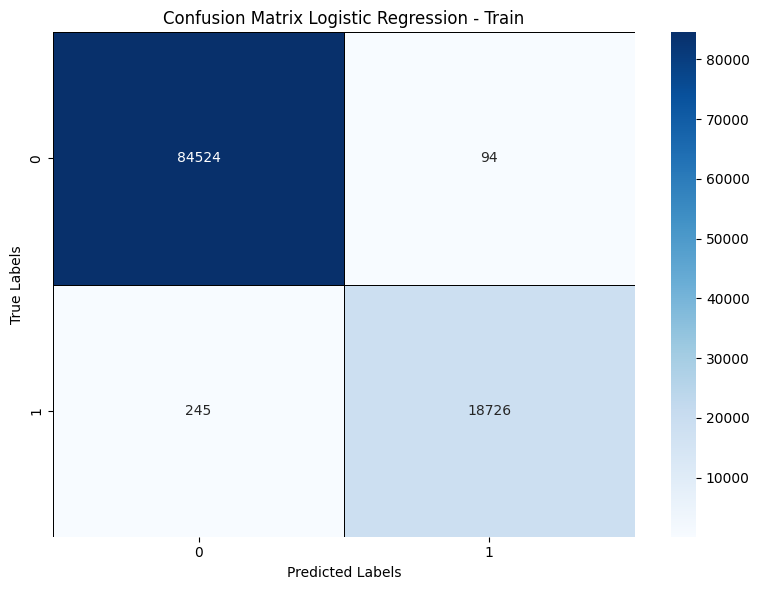

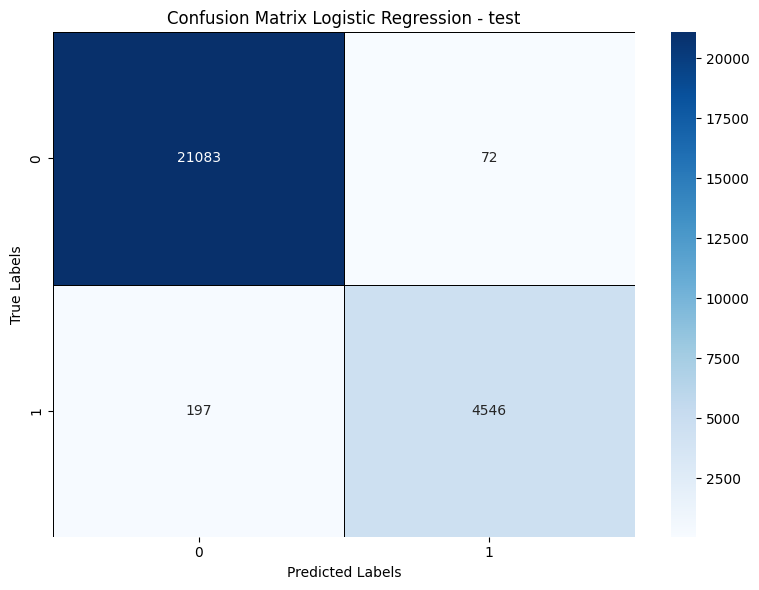

In [ ]:
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for 5-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tomek Links with Sampling Strategy Majority
tl = TomekLinks(sampling_strategy = 'majority')

# Perform Random Forest with the best_params out of the RandomSearchCV
model = RandomForestClassifier(random_state=42, **best_params)
print(Counter(y_train))
# Apply ADASYN for oversampling on the training data
X_train_resampled, y_train_resampled = tl.fit_resample(X_train, y_train)
print(Counter(y_train_resampled))
# Fit the logistic regression model on the training data
model.fit(X_train_resampled, y_train_resampled)

# Predictions/probabilities validation
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# predict probabilities
y_probs_train = model.predict_proba(X_train)[:, 1]
y_probs_test = model.predict_proba(X_test)[:, 1]

#Evaluation Metrics
f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_probs_train)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_probs_test)

pr_auc_train = auc(recall_train, precision_train)
pr_auc_test = auc(recall_test, precision_test)

g_mean_train = np.sqrt(recall_train * (1 - recall_train))
g_mean_test = np.sqrt(recall_test * (1 - recall_test))

best_index_train = np.argmax(g_mean_train)
best_index_test = np.argmax(g_mean_test)

best_threshold_train = thresholds_train[best_index_train]
best_threshold_test = thresholds_test[best_index_test]

#Print Train results
print(f"F1 Score: {f1_train}")
print(f"AUC-PR Score: {pr_auc_train}")
print(f"G-Mean: {g_mean_train[best_index_train]} at threshold {best_threshold_train}")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Logistic Regression - Train")
plt.tight_layout()

#Print Test results
print(f"F1 Score: {f1_test}")
print(f"AUC-PR Score: {pr_auc_test}")
print(f"G-Mean: {g_mean_test[best_index_test]} at threshold {best_threshold_test}")
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Logistic Regression - test")
plt.tight_layout()

# plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_RF_Adasyn_test.png', dpi=300)



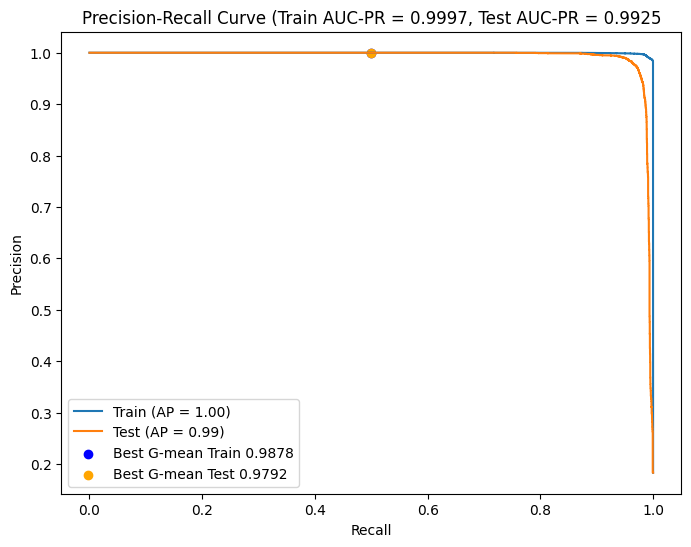

In [ ]:
# Create Precision-Recall curve display
display_train_rf_tl = PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=pr_auc_train)
display_test_rf_tl = PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=pr_auc_test)

# Plot both curves on the same plot
plt.figure(figsize=(8, 6))

# Plot training set curve
display_train_rf_tl.plot(ax=plt.gca(), name="Train")
display_test_rf_tl.plot(ax=plt.gca(), name="Test")

# Show AUC-PR values in the plot
plt.title(f'Precision-Recall Curve (Train AUC-PR = {pr_auc_train:.4f}, Test AUC-PR = {pr_auc_test:.4f}')
plt.scatter(recall_train[best_index_train], precision_train[best_index_train], marker='o', color='blue', label=f'Best G-mean Train {best_threshold_train:.4f}')
plt.scatter(recall_test[best_index_test], precision_test[best_index_test], marker='o', color='orange', label=f'Best G-mean Test {best_threshold_test:.4f}')
plt.legend()

# Show the plot
plt.show()

## Multi-Layer Perceptron

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

#Define functions for recall, precision and, f1 that are supported in mlp
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Define a function for hyperparameter tuning mlp
def build_model(hp):
    model = tf.keras.Sequential()

    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                    activation='relu', input_dim=X_train.shape[1]))

    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                        activation='relu', kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'l2_{i+2}', min_value=1e-6, max_value=1e-2, sampling='log'))))

        # Conditionally add Dropout
        if hp.Boolean(f'use_dropout_{i+2}', default=False):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])

    return model

# Initialize Keras Tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective=keras_tuner.Objective('val_f1_m', direction='max'),
    max_trials=20,
    directory='tuner_directory',
    project_name='binary_classification_tuning')

Reloading Tuner from tuner_directory/binary_classification_tuning/tuner0.json


<ipython-input-131-195f685b8c9c>:64: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(0.85, 1.02, 0.02)


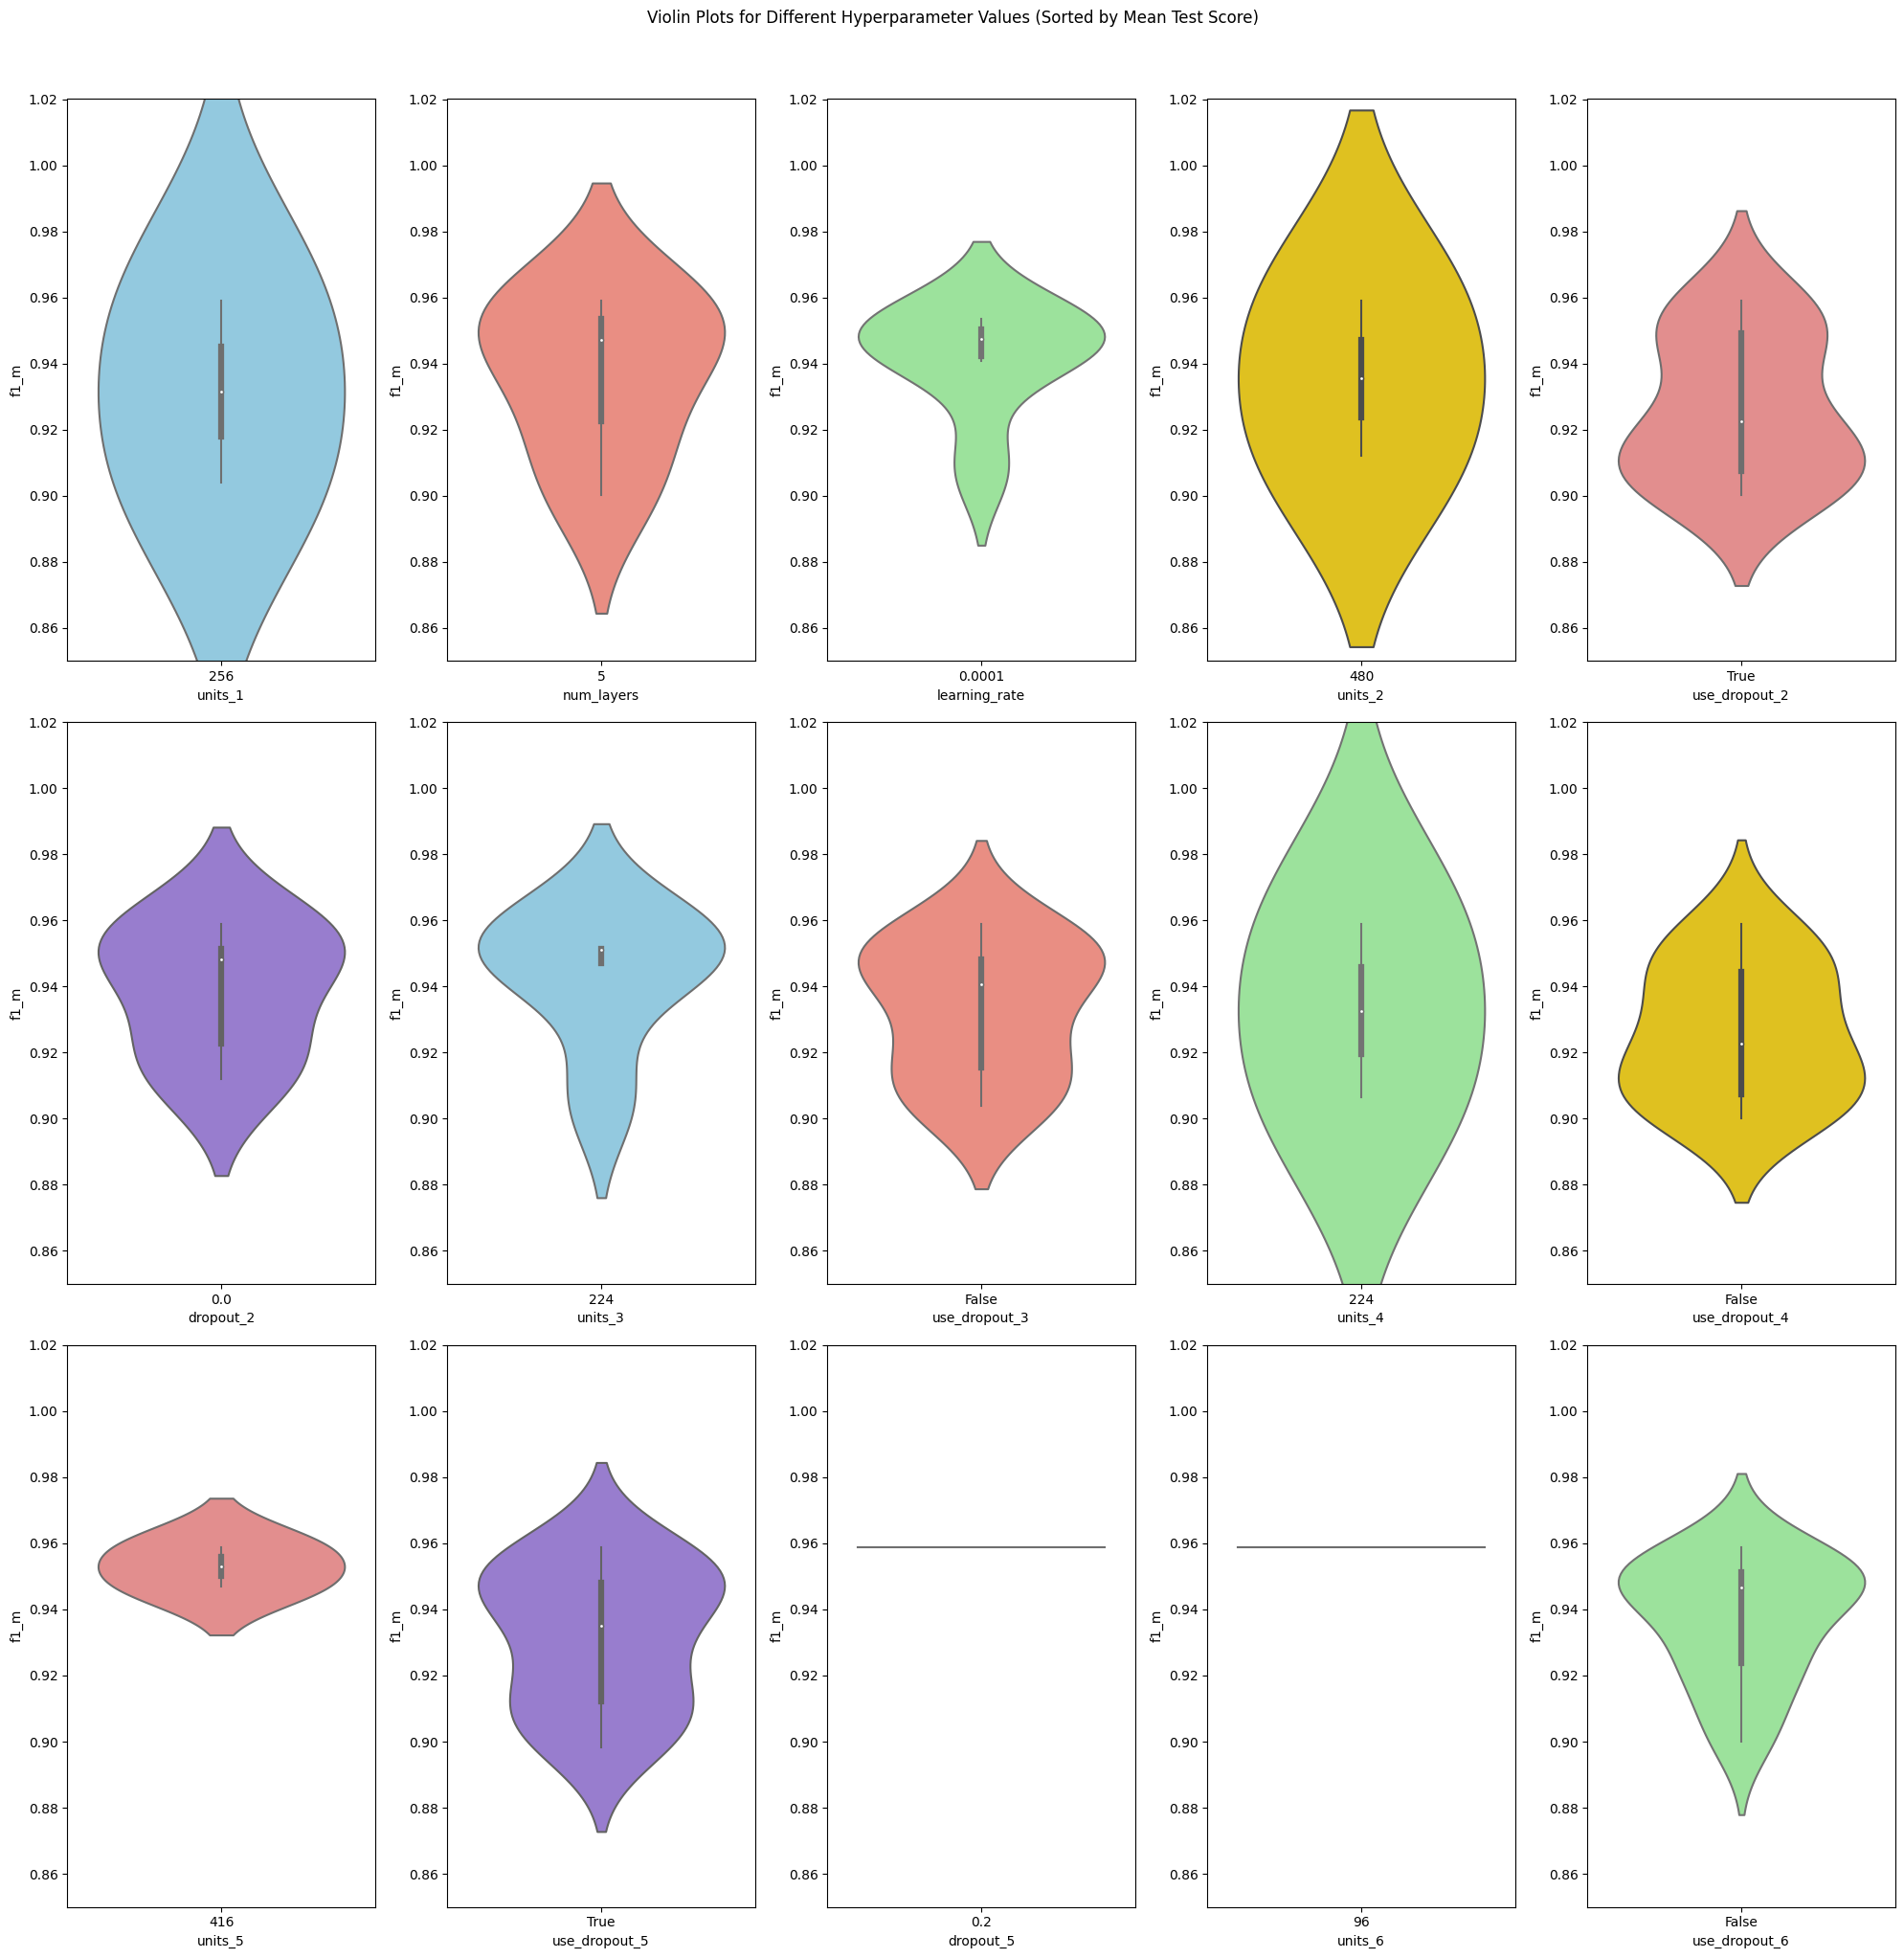

In [ ]:
# Run hyperparameter tuning
tuner.search(X_rfe, y_train, validation_data=(X_test, y_test))

# Get the results
tuner_results = tuner.oracle.get_best_trials(num_trials=20)

# Extract hyperparameter values
hyperparameters = []
for trial in tuner_results:
    hyperparameter_values = trial.hyperparameters.values
    hyperparameter_values['f1_m'] = trial.metrics.get_last_value('val_f1_m')
    hyperparameters.append(hyperparameter_values)

# Create a DataFrame from hyperparameter values
df_hyperparameters = pd.DataFrame(hyperparameters)

# Filter the DataFrame for 'units_1' equals 256
df_units_1_256 = df_hyperparameters[df_hyperparameters['units_1'] == 256]
df_num_layers_5 = df_hyperparameters[df_hyperparameters['num_layers'] == 5]
df_learning_rate = df_hyperparameters[df_hyperparameters['learning_rate'] == 0.0001]
df_units_2 = df_hyperparameters[df_hyperparameters['units_2'] == 480]
df_use_dropout_2 = df_hyperparameters[df_hyperparameters['use_dropout_2'] == True]
df_dropout_2= df_hyperparameters[df_hyperparameters['dropout_2'] == 0.0]
df_units_3 = df_hyperparameters[df_hyperparameters['units_3'] == 224]
df_use_dropout_3 = df_hyperparameters[df_hyperparameters['use_dropout_3'] == False]
df_units_4 = df_hyperparameters[df_hyperparameters['units_4'] == 224]
df_use_dropout_4 = df_hyperparameters[df_hyperparameters['use_dropout_4'] == False]
df_units_5 = df_hyperparameters[df_hyperparameters['units_5'] == 416]
df_use_dropout_5 = df_hyperparameters[df_hyperparameters['use_dropout_5'] == True]
df_dropout_5 = df_hyperparameters[df_hyperparameters['dropout_5'] == 0.2]
df_units_6 = df_hyperparameters[df_hyperparameters['units_6'] == 96]
df_use_dropout_6 = df_hyperparameters[df_hyperparameters['use_dropout_6'] == False]

# Create a figure with subplots for each hyperparameter
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 20))

# Flatten the 2D array of subplots
axes = axes.flatten()

# Plot each violin plot in a separate subplot
sns.violinplot(x='units_1', y='f1_m', data=df_units_1_256, color='skyblue', ax=axes[0])
sns.violinplot(x='num_layers', y='f1_m', data=df_num_layers_5, color='salmon', ax=axes[1])
sns.violinplot(x='learning_rate', y='f1_m', data=df_learning_rate, color='lightgreen', ax=axes[2])
sns.violinplot(x='units_2', y='f1_m', data=df_units_2, color='gold', ax=axes[3])
sns.violinplot(x='use_dropout_2', y='f1_m', data=df_use_dropout_2, color='lightcoral', ax=axes[4])
sns.violinplot(x='dropout_2', y='f1_m', data=df_dropout_2, color='mediumpurple', ax=axes[5])
sns.violinplot(x='units_3', y='f1_m', data=df_units_3, color='skyblue', ax=axes[6])
sns.violinplot(x='use_dropout_3', y='f1_m', data=df_use_dropout_3, color='salmon', ax=axes[7])
sns.violinplot(x='units_4', y='f1_m', data=df_units_4, color='lightgreen', ax=axes[8])
sns.violinplot(x='use_dropout_4', y='f1_m', data=df_use_dropout_4, color='gold', ax=axes[9])
sns.violinplot(x='units_5', y='f1_m', data=df_units_5, color='lightcoral', ax=axes[10])
sns.violinplot(x='use_dropout_5', y='f1_m', data=df_use_dropout_5, color='mediumpurple', ax=axes[11])
sns.violinplot(x='dropout_5', y='f1_m', data=df_dropout_5, color='skyblue', ax=axes[12])
sns.violinplot(x='units_6', y='f1_m', data=df_units_6, color='salmon', ax=axes[13])
sns.violinplot(x='use_dropout_6', y='f1_m', data=df_use_dropout_6, color='lightgreen', ax=axes[14])

# Set title and labels
fig.suptitle('Violin Plots for Different Hyperparameter Values (Sorted by Mean Test Score)', y=1.02)
for ax in axes:
    ax.set_ylim(0.85, 1.02, 0.02)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/hyperparameters mlp.png', dpi=300)


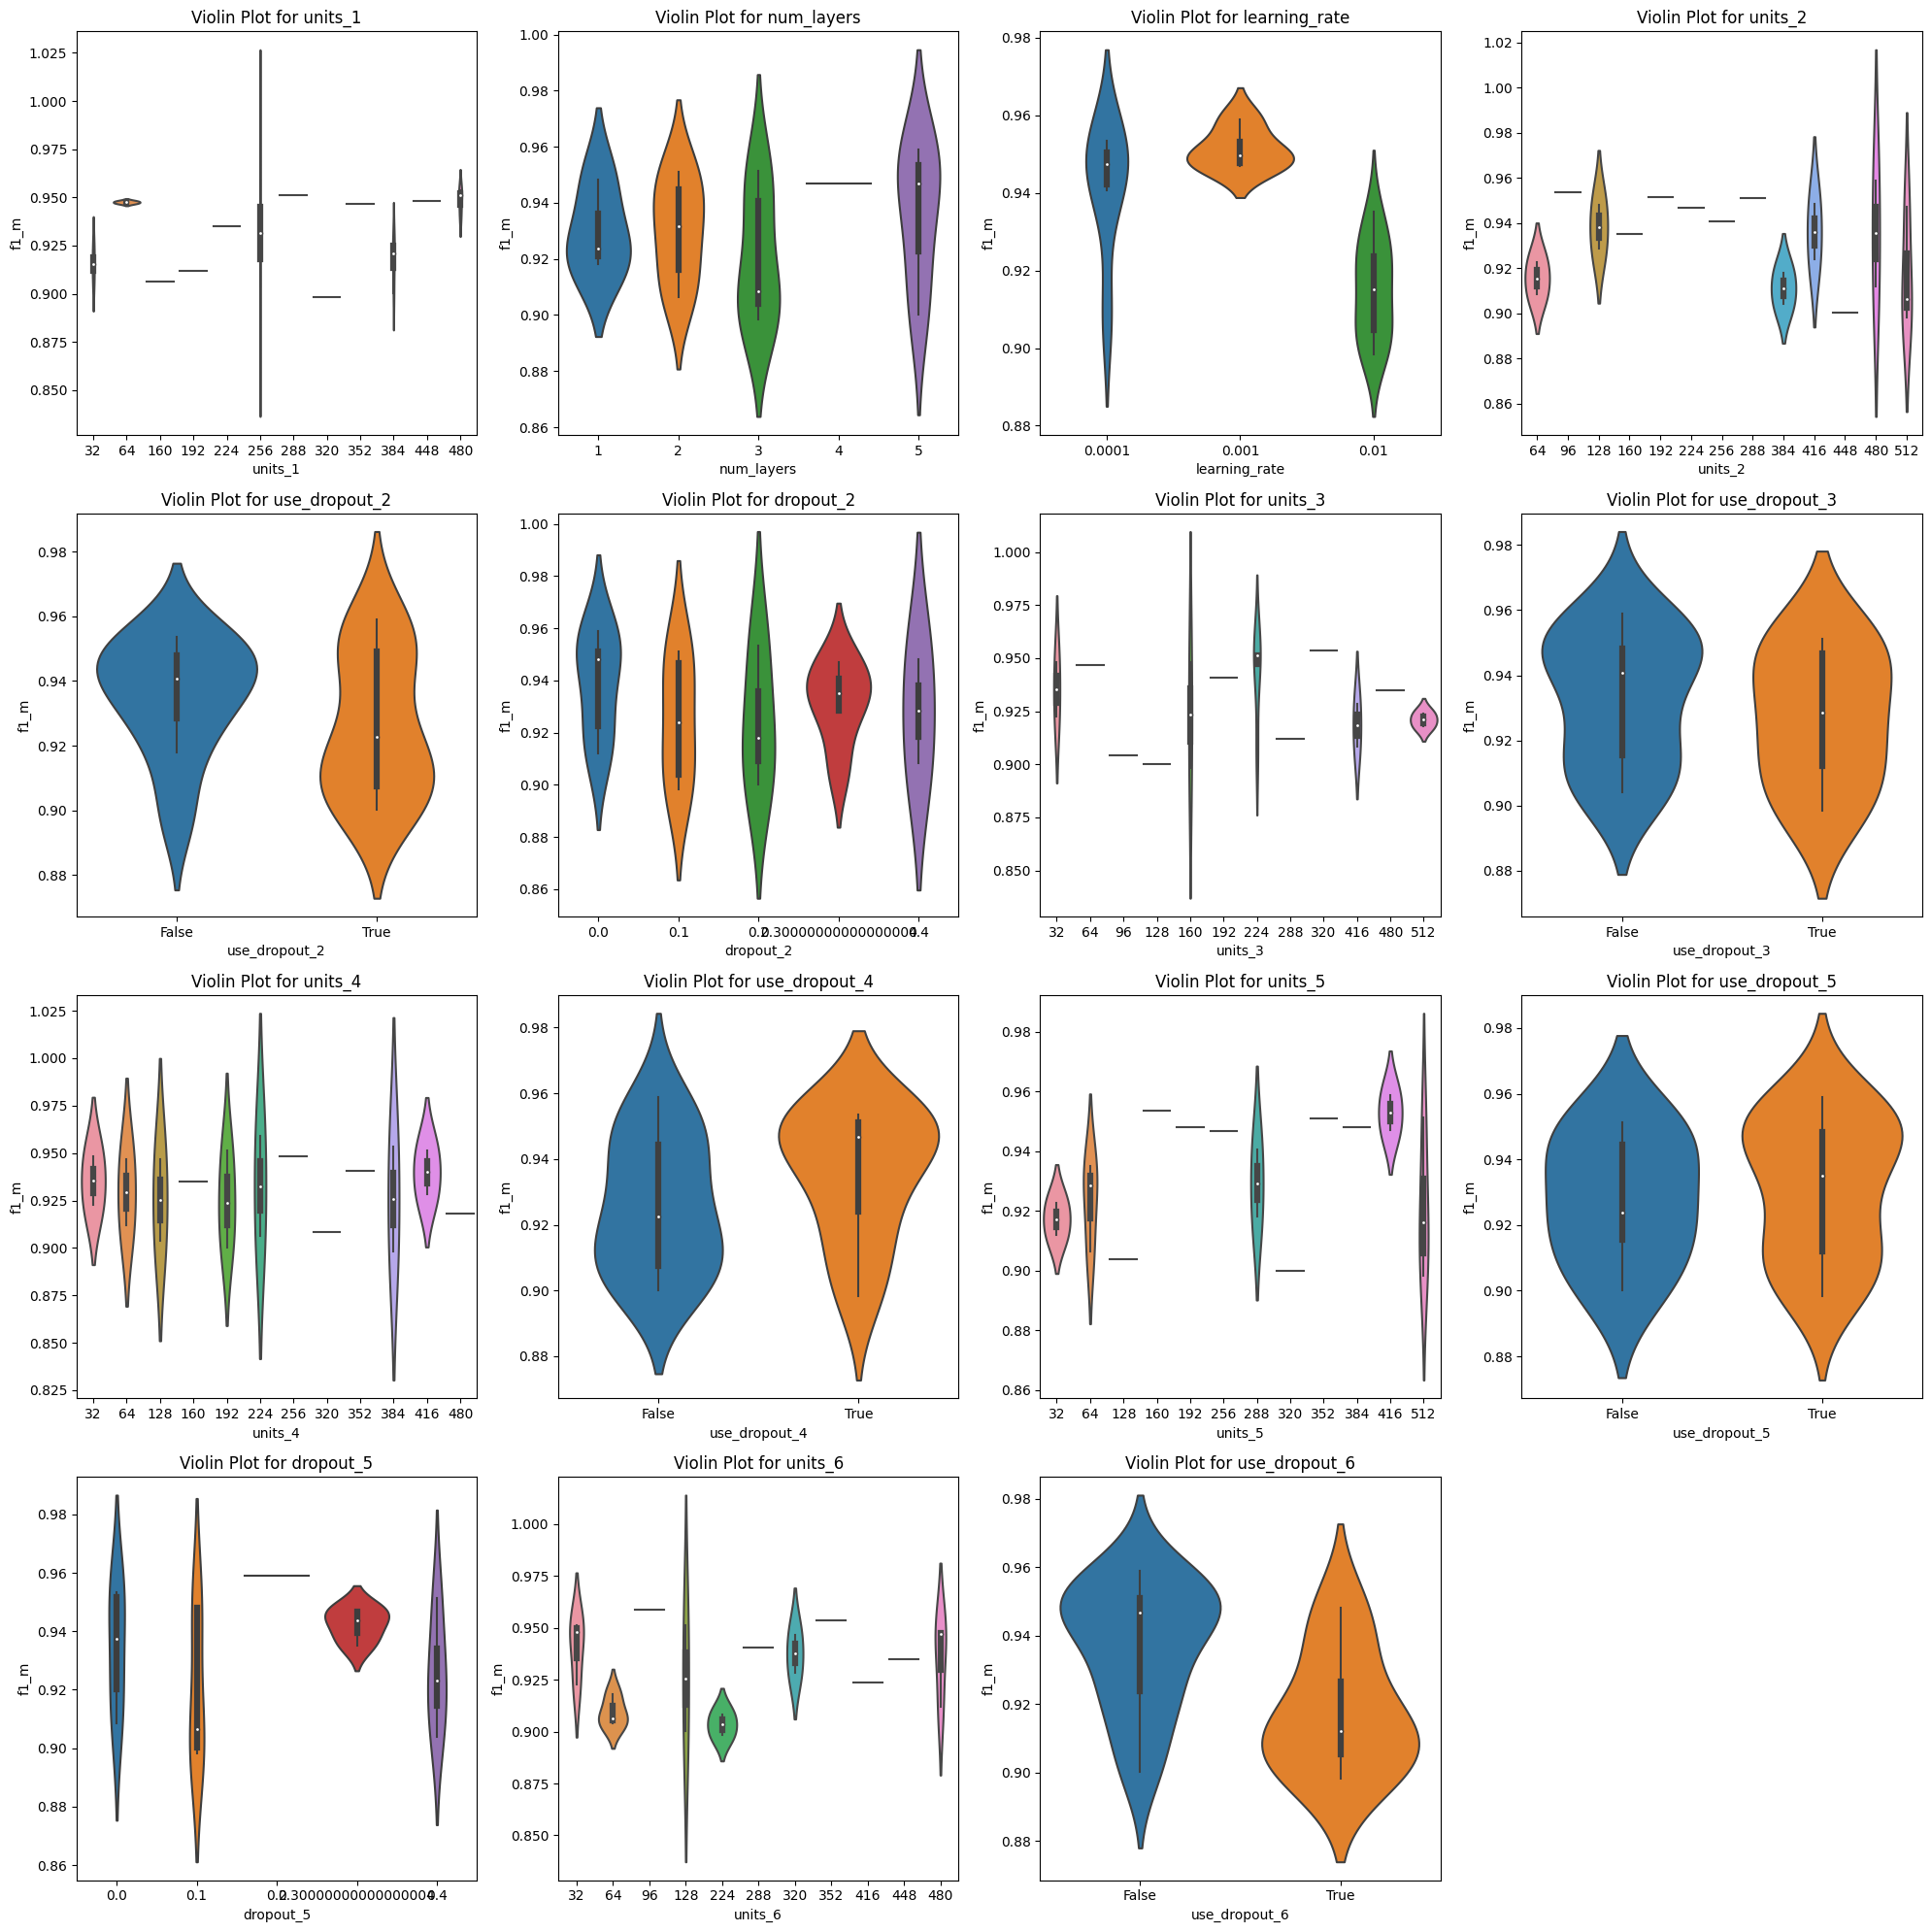

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Run hyperparameter tuning
tuner.search(X_rfe, y_train, validation_data=(X_test, y_test))

# Get the results
tuner_results = tuner.oracle.get_best_trials(num_trials=20)

# Extract hyperparameter values
hyperparameters = []
for trial in tuner_results:
    hyperparameter_values = trial.hyperparameters.values
    hyperparameter_values['f1_m'] = trial.metrics.get_last_value('val_f1_m')
    hyperparameters.append(hyperparameter_values)

# Create a DataFrame from hyperparameter values
df_hyperparameters = pd.DataFrame(hyperparameters)

hyperparameter_names = ['units_1', 'num_layers', 'learning_rate',
                        'units_2', 'use_dropout_2', 'dropout_2',
                        'units_3', 'use_dropout_3',
                        'units_4', 'use_dropout_4',
                        'units_5', 'use_dropout_5', 'dropout_5',
                        'units_6', 'use_dropout_6']
df_hyperparameters_violin = df_hyperparameters[hyperparameter_names + ['f1_m']]

# Create a grid of subplots
num_plots = len(hyperparameter_names)
num_columns = 4  # You can adjust the number of columns based on your preference
num_rows = -(-num_plots // num_columns)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5*num_rows))

# Flatten the axes if there's only one row
axes = axes.flatten()

# Create violin plots
for i, (hyperparameter, ax) in enumerate(zip(hyperparameter_names, axes)):
    sns.violinplot(x=hyperparameter, y='f1_m', data=df_hyperparameters_violin, ax=ax)
    ax.set_title(f'Violin Plot for {hyperparameter}')

# Hide empty subplots
for i in range(num_plots, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Thesis/Figures/hyperparameters mlp.png', dpi=300)


In [ ]:
tuner.results_summary()

Results summary
Results in tuner_directory/binary_classification_tuning
Showing 10 best trials
Objective(name="val_f1_m", direction="max")

Trial 04 summary
Hyperparameters:
units_1: 256
num_layers: 5
units_2: 480
l2_2: 1.1336902110436644e-05
use_dropout_2: True
learning_rate: 0.001
dropout_2: 0.0
units_3: 224
l2_3: 3.961187738157227e-05
use_dropout_3: False
units_4: 224
l2_4: 0.0001675247363869997
use_dropout_4: False
units_5: 416
l2_5: 0.0003792613338893929
use_dropout_5: True
units_6: 96
l2_6: 4.018825070092252e-05
use_dropout_6: False
dropout_3: 0.0
dropout_4: 0.4
dropout_5: 0.2
Score: 0.9589529037475586

Trial 02 summary
Hyperparameters:
units_1: 480
num_layers: 5
units_2: 96
l2_2: 1.0072430689487388e-05
use_dropout_2: False
learning_rate: 0.0001
dropout_2: 0.2
units_3: 320
l2_3: 0.0032883678576397855
use_dropout_3: False
units_4: 384
l2_4: 3.945470335276781e-06
use_dropout_4: True
units_5: 160
l2_5: 0.0007035476732865177
use_dropout_5: True
units_6: 352
l2_6: 0.007775803673143684

### Multi-Layer Perceptron ADASYN

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for 5-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Adasyn with Best beta value and number of neighbours
adasyn = ADASYN(sampling_strategy=0.3, n_neighbors=7, random_state=42)

#Empty lists train folds
lst_f1_scores_adasyn_train = []
lst_gmean_adasyn_train = []
lst_treshold_adasyn_train = []
lst_auc_pr_adasyn_train = []
lst_classification_reports_adasyn_train = []
lst_confusion_matrix_adasyn_train = []

#Empty lists validation folds
lst_f1_scores_adasyn_val = []
lst_gmean_adasyn_val = []
lst_treshold_adasyn_val = []
lst_auc_pr_adasyn_val = []
lst_classification_reports_adasyn_val = []
lst_confusion_matrix_adasyn_val = []

#Peform stratified 5-fold cross-validation with Adasyn and Multi-Layer Perceptron
for train_index, test_index in stratified_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply ADASYN for oversampling on the training data
    X_train_fold, y_train_fold = adasyn.fit_resample(X_train_fold, y_train_fold)

    # Perform the hyperparameter search
    tuner.search(x=X_train_fold, y=y_train_fold, epochs=10, validation_data=(X_val_fold, y_val_fold))

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build and train the final model with the best hyperparameters
    final_model = tuner.hypermodel.build(best_hps)
    final_model.fit(x=X_train_fold, y=y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Predictions/probabilities validation
    y_probs_train = final_model.predict(X_train_fold)
    y_probs_val = final_model.predict(X_val_fold)

    y_pred_train = (y_probs_train > 0.5).astype(int)
    y_pred_val = (y_probs_val > 0.5).astype(int)

    #Evaluation Metrics
    f1_train = f1_score(y_train_fold, y_pred_train, pos_label=1)
    f1_val = f1_score(y_val_fold, y_pred_val, pos_label=1)

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train_fold, y_probs_train)
    precision_val, recall_val, thresholds_val = precision_recall_curve(y_val_fold, y_probs_val)

    pr_auc_train = auc(recall_train, precision_train)
    pr_auc_val = auc(recall_val, precision_val)

    g_mean_train = np.sqrt(recall_train * (1 - recall_train))
    g_mean_val = np.sqrt(recall_val * (1 - recall_val))

    best_index_train = np.argmax(g_mean_train)
    best_index_val = np.argmax(g_mean_val)

    best_threshold_train = thresholds_train[best_index_train]
    best_threshold_val = thresholds_val[best_index_val]

    report_train = classification_report(y_train_fold, y_pred_train, target_names=["Class 0", "Class 1"])
    report_val = classification_report(y_val_fold, y_pred_val, target_names=["Class 0", "Class 1"])

    cm_train = confusion_matrix(y_train_fold, y_pred_train)
    cm_val = confusion_matrix(y_val_fold, y_pred_val)

    #Append list with scores train folds
    lst_f1_scores_adasyn_train.append(f1_train)
    lst_gmean_adasyn_train.append(g_mean_train[best_index_train])
    lst_treshold_adasyn_train.append(best_threshold_train)
    lst_auc_pr_adasyn_train.append(pr_auc_train)
    lst_classification_reports_adasyn_train.append(report_train)
    lst_confusion_matrix_adasyn_train.append(cm_train)

    #Append list with scores test folds
    lst_f1_scores_adasyn_val.append(f1_val)
    lst_gmean_adasyn_val.append(g_mean_val[best_index_val])
    lst_treshold_adasyn_val.append(best_threshold_val)
    lst_auc_pr_adasyn_val.append(pr_auc_val)
    lst_classification_reports_adasyn_val.append(report_val)
    lst_confusion_matrix_adasyn_val.append(cm_val)

# Display scores for each training fold
for i, f1_train in enumerate(lst_f1_scores_adasyn_train):
    print(f"F1 Score - Training Fold {i+1}: {f1_train}")
for i, best_index_train in enumerate(lst_gmean_adasyn_train):
    print(f"G-Mean - Training Fold {i+1}: {best_index_train}")
for i, best_threshold_train in enumerate(lst_treshold_adasyn_train):
    print(f"G-Mean Treshold - Training Fold {i+1}: {best_threshold_train}")
for i, pr_auc_train in enumerate(lst_auc_pr_adasyn_train):
    print(f"AUC-PR - Training Fold {i+1}: {pr_auc_train}")
for i, report_train in enumerate(lst_classification_reports_adasyn_train):
    print(f"Classification Report - Training Fold {i+1}:\n{report_train}")
for i, cm_train in enumerate(lst_confusion_matrix_adasyn_train):
    print(f"Confusion Matrix - Training Fold {i+1}:\n{cm_train}")

# Display scores for each validation fold
for i, f1_val in enumerate(lst_f1_scores_adasyn_val):
    print(f"F1 Score - validation Fold {i+1}: {f1_val}")
for i, best_index_val in enumerate(lst_gmean_adasyn_val):
    print(f"G-Mean - validation Fold {i+1}: {best_index_val}")
for i, best_threshold_val in enumerate(lst_treshold_adasyn_val):
    print(f"G-Mean Treshold - validation Fold {i+1}: {best_threshold_val}")
for i, pr_auc_val in enumerate(lst_auc_pr_adasyn_val):
    print(f"AUC-PR - validation Fold {i+1}: {pr_auc_val}")
for i, report_val in enumerate(lst_classification_reports_adasyn_val):
    print(f"Classification Report - validation Fold {i+1}:\n{report_val}")
for i, cm_val in enumerate(lst_confusion_matrix_adasyn_val):
    print(f"Confusion Matrix - validation Fold {i+1}:\n{cm_val}")

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for training folds
avg_f1_train = np.mean(lst_f1_scores_adasyn_train)
avg_gmean_train = np.mean(lst_gmean_adasyn_train)
avg_treshold_train = np.mean(lst_treshold_adasyn_train)
avg_aucpr_train = np.mean(lst_auc_pr_adasyn_train)
avg_confusion_matrix_train = np.mean(lst_confusion_matrix_adasyn_train, axis=0)

# Create a DataFrame to store the averages of the training folds
average_metrics_df_train = pd.DataFrame({
    'Average F1 Score': [avg_f1_train],
    'Average G-Mean': [avg_gmean_train],
    'Average Treshold': [avg_treshold_train],
    'Average AUC-PR': [avg_aucpr_train],
    'Average Confusion Matrix': [avg_confusion_matrix_train]
})

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for validation folds
avg_f1_val = np.mean(lst_f1_scores_adasyn_val)
avg_gmean_val = np.mean(lst_gmean_adasyn_val)
avg_treshold_val = np.mean(lst_treshold_adasyn_val)
avg_aucpr_val = np.mean(lst_auc_pr_adasyn_val)
avg_confusion_matrix_val = np.mean(lst_confusion_matrix_adasyn_val, axis=0)

# Create a DataFrame to store the averages of the validation folds
average_metrics_df_val = pd.DataFrame({
    'Average F1 Score': [avg_f1_val],
    'Average G-Mean': [avg_gmean_val],
    'Average Treshold': [avg_treshold_val],
    'Average AUC-PR': [avg_aucpr_val],
    'Average Confusion Matrix': [avg_confusion_matrix_val]
})

# Display the DataFrame
print(average_metrics_df_train)
print(average_metrics_df_val)

# plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_MLP_Adasyn_validation.png', dpi=300)

Epoch 1/10
2730/2730 [==============================] - 43s 15ms/step - loss: 0.1882 - accuracy: 0.9379 - f1_m: 0.8252 - val_loss: 0.0983 - val_accuracy: 0.9704 - val_f1_m: 0.9079
Epoch 2/10
2730/2730 [==============================] - 35s 13ms/step - loss: 0.1002 - accuracy: 0.9678 - f1_m: 0.9210 - val_loss: 0.0750 - val_accuracy: 0.9778 - val_f1_m: 0.9341
Epoch 3/10
2730/2730 [==============================] - 34s 12ms/step - loss: 0.0862 - accuracy: 0.9714 - f1_m: 0.9302 - val_loss: 0.0574 - val_accuracy: 0.9830 - val_f1_m: 0.9477
Epoch 4/10
2730/2730 [==============================] - 36s 13ms/step - loss: 0.0762 - accuracy: 0.9753 - f1_m: 0.9394 - val_loss: 0.0592 - val_accuracy: 0.9828 - val_f1_m: 0.9475
Epoch 5/10
2730/2730 [==============================] - 46s 17ms/step - loss: 0.0728 - accuracy: 0.9765 - f1_m: 0.9432 - val_loss: 0.0551 - val_accuracy: 0.9839 - val_f1_m: 0.9502
Epoch 6/10
2730/2730 [==============================] - 39s 14ms/step - loss: 0.0672 - accuracy: 0.9

In [ ]:
final_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               4608      
                                                                 
 dense_29 (Dense)            (None, 480)               123360    
                                                                 
 dropout_8 (Dropout)         (None, 480)               0         
                                                                 
 dense_30 (Dense)            (None, 224)               107744    
                                                                 
 dense_31 (Dense)            (None, 224)               50400     
                                                                 
 dense_32 (Dense)            (None, 416)               93600     
                                                                 
 dropout_9 (Dropout)         (None, 416)              

Counter({0: 84618, 1: 18971})
Counter({0: 84618, 1: 24218})
Epoch 1/10
3402/3402 [==============================] - 46s 13ms/step - loss: 0.1660 - accuracy: 0.9457 - f1_m: 0.8478 - val_loss: 0.0847 - val_accuracy: 0.9760 - val_f1_m: 0.9202
Epoch 2/10
3402/3402 [==============================] - 44s 13ms/step - loss: 0.0928 - accuracy: 0.9699 - f1_m: 0.9253 - val_loss: 0.0660 - val_accuracy: 0.9796 - val_f1_m: 0.9340
Epoch 3/10
3402/3402 [==============================] - 43s 13ms/step - loss: 0.0797 - accuracy: 0.9745 - f1_m: 0.9364 - val_loss: 0.0656 - val_accuracy: 0.9806 - val_f1_m: 0.9378
Epoch 4/10
3402/3402 [==============================] - 42s 12ms/step - loss: 0.0724 - accuracy: 0.9770 - f1_m: 0.9433 - val_loss: 0.0610 - val_accuracy: 0.9814 - val_f1_m: 0.9411
Epoch 5/10
3402/3402 [==============================] - 46s 13ms/step - loss: 0.0676 - accuracy: 0.9787 - f1_m: 0.9473 - val_loss: 0.0914 - val_accuracy: 0.9723 - val_f1_m: 0.9071
Epoch 6/10
3402/3402 [==================

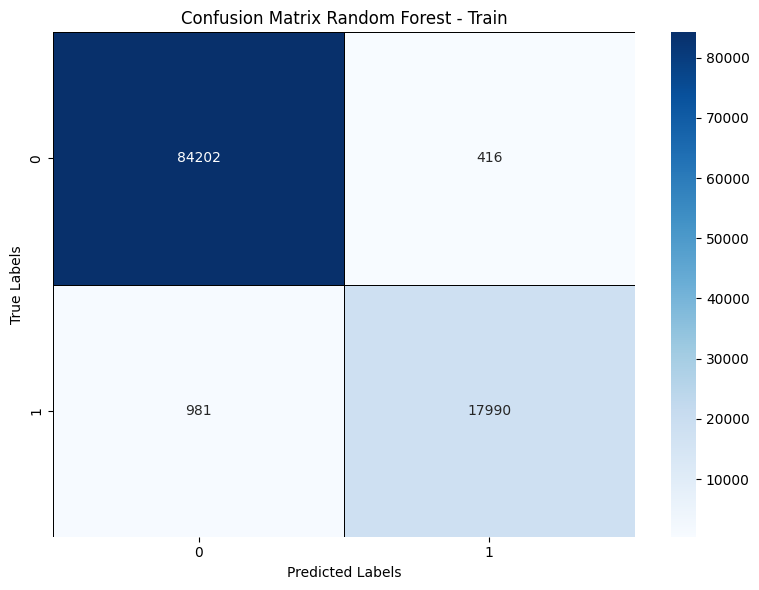

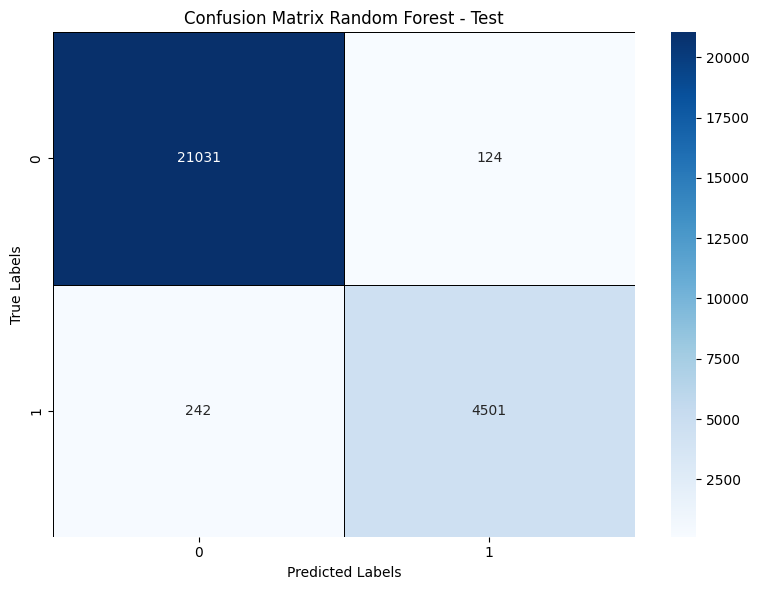

In [ ]:
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for 5-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Adasyn with Best beta value and number of neighbours
adasyn = ADASYN(sampling_strategy=0.3, n_neighbors=7, random_state=42)
print(Counter(y_train))
# Apply ADASYN for oversampling on the training data
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
print(Counter(y_train_resampled))
# Perform the hyperparameter search
tuner.search(x=X_train_resampled, y=y_train_resampled, epochs=10, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(x=X_train_resampled, y=y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predictions/probabilities validation
y_probs_train = final_model.predict(X_train)
y_probs_test = final_model.predict(X_test)

y_pred_train = (y_probs_train > 0.5).astype(int)
y_pred_test = (y_probs_test > 0.5).astype(int)

#Evaluation Metrics
f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_probs_train)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_probs_test)

pr_auc_train = auc(recall_train, precision_train)
pr_auc_test = auc(recall_test, precision_test)

g_mean_train = np.sqrt(recall_train * (1 - recall_train))
g_mean_test = np.sqrt(recall_test * (1 - recall_test))

best_index_train = np.argmax(g_mean_train)
best_index_test = np.argmax(g_mean_test)

best_threshold_train = thresholds_train[best_index_train]
best_threshold_test = thresholds_test[best_index_test]

#Print Train results
print(f"F1 Score: {f1_train}")
print(f"AUC-PR Score: {pr_auc_train}")
print(f"G-Mean: {g_mean_train[best_index_train]} at threshold {best_threshold_train}")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest - Train")
plt.tight_layout()

#Print Test results
print(f"F1 Score: {f1_test}")
print(f"AUC-PR Score: {pr_auc_test}")
print(f"G-Mean: {g_mean_test[best_index_test]} at threshold {best_threshold_test}")
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest - Test")
plt.tight_layout()

#plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_MLP_Adasyn_test.png', dpi=300)



In [ ]:
final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 256)               4608      
                                                                 
 dense_50 (Dense)            (None, 480)               123360    
                                                                 
 dropout_14 (Dropout)        (None, 480)               0         
                                                                 
 dense_51 (Dense)            (None, 224)               107744    
                                                                 
 dense_52 (Dense)            (None, 224)               50400     
                                                                 
 dense_53 (Dense)            (None, 416)               93600     
                                                                 
 dropout_15 (Dropout)        (None, 416)              

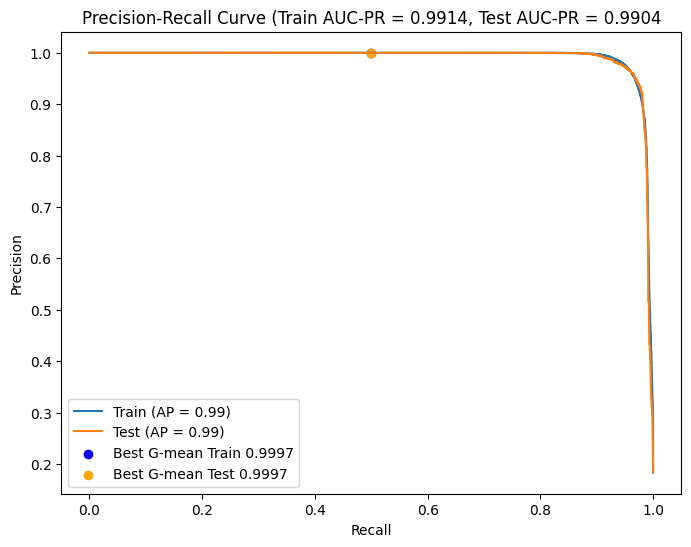

In [ ]:
# Create Precision-Recall curve display
display_train_mlp_adasyn = PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=pr_auc_train)
display_test_mlp_adasyn = PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=pr_auc_test)

# Plot both curves on the same plot
plt.figure(figsize=(8, 6))

# Plot training set curve
display_train_mlp_adasyn.plot(ax=plt.gca(), name="Train")
display_test_mlp_adasyn.plot(ax=plt.gca(), name="Test")

# Show AUC-PR values in the plot
plt.title(f'Precision-Recall Curve (Train AUC-PR = {pr_auc_train:.4f}, Test AUC-PR = {pr_auc_test:.4f}')
plt.scatter(recall_train[best_index_train], precision_train[best_index_train], marker='o', color='blue', label=f'Best G-mean Train {best_threshold_train:.4f}')
plt.scatter(recall_test[best_index_test], precision_test[best_index_test], marker='o', color='orange', label=f'Best G-mean Test {best_threshold_test:.4f}')
plt.legend()

# Show the plot
plt.show()

### Multi-Layer Perceptron Tomek Links

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for 5-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Adasyn with Best beta value and number of neighbours
tl = TomekLinks(sampling_strategy = 'majority')

#Empty lists train folds
lst_f1_scores_adasyn_train = []
lst_gmean_adasyn_train = []
lst_treshold_adasyn_train = []
lst_auc_pr_adasyn_train = []
lst_classification_reports_adasyn_train = []
lst_confusion_matrix_adasyn_train = []

#Empty lists validation folds
lst_f1_scores_adasyn_val = []
lst_gmean_adasyn_val = []
lst_treshold_adasyn_val = []
lst_auc_pr_adasyn_val = []
lst_classification_reports_adasyn_val = []
lst_confusion_matrix_adasyn_val = []

#Peform stratified 5-fold cross-validation with Adasyn and Multi-Layer Perceptron
for train_index, test_index in stratified_cv.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Apply ADASYN for oversampling on the training data
    X_train_fold, y_train_fold = tl.fit_resample(X_train_fold, y_train_fold)

    # Perform the hyperparameter search
    tuner.search(x=X_train_fold, y=y_train_fold, epochs=10, validation_data=(X_val_fold, y_val_fold))

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build and train the final model with the best hyperparameters
    final_model = tuner.hypermodel.build(best_hps)
    final_model.fit(x=X_train_fold, y=y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Predictions/probabilities validation
    y_probs_train = final_model.predict(X_train_fold)
    y_probs_val = final_model.predict(X_val_fold)

    y_pred_train = (y_probs_train > 0.5).astype(int)
    y_pred_val = (y_probs_val > 0.5).astype(int)

    #Evaluation Metrics
    f1_train = f1_score(y_train_fold, y_pred_train, pos_label=1)
    f1_val = f1_score(y_val_fold, y_pred_val, pos_label=1)

    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train_fold, y_probs_train)
    precision_val, recall_val, thresholds_val = precision_recall_curve(y_val_fold, y_probs_val)

    pr_auc_train = auc(recall_train, precision_train)
    pr_auc_val = auc(recall_val, precision_val)

    g_mean_train = np.sqrt(recall_train * (1 - recall_train))
    g_mean_val = np.sqrt(recall_val * (1 - recall_val))

    best_index_train = np.argmax(g_mean_train)
    best_index_val = np.argmax(g_mean_val)

    best_threshold_train = thresholds_train[best_index_train]
    best_threshold_val = thresholds_val[best_index_val]

    report_train = classification_report(y_train_fold, y_pred_train, target_names=["Class 0", "Class 1"])
    report_val = classification_report(y_val_fold, y_pred_val, target_names=["Class 0", "Class 1"])

    cm_train = confusion_matrix(y_train_fold, y_pred_train)
    cm_val = confusion_matrix(y_val_fold, y_pred_val)

    #Append list with scores train folds
    lst_f1_scores_adasyn_train.append(f1_train)
    lst_gmean_adasyn_train.append(g_mean_train[best_index_train])
    lst_treshold_adasyn_train.append(best_threshold_train)
    lst_auc_pr_adasyn_train.append(pr_auc_train)
    lst_classification_reports_adasyn_train.append(report_train)
    lst_confusion_matrix_adasyn_train.append(cm_train)

    #Append list with scores test folds
    lst_f1_scores_adasyn_val.append(f1_val)
    lst_gmean_adasyn_val.append(g_mean_val[best_index_val])
    lst_treshold_adasyn_val.append(best_threshold_val)
    lst_auc_pr_adasyn_val.append(pr_auc_val)
    lst_classification_reports_adasyn_val.append(report_val)
    lst_confusion_matrix_adasyn_val.append(cm_val)

# Display scores for each training fold
for i, f1_train in enumerate(lst_f1_scores_adasyn_train):
    print(f"F1 Score - Training Fold {i+1}: {f1_train}")
for i, best_index_train in enumerate(lst_gmean_adasyn_train):
    print(f"G-Mean - Training Fold {i+1}: {best_index_train}")
for i, best_threshold_train in enumerate(lst_treshold_adasyn_train):
    print(f"G-Mean Treshold - Training Fold {i+1}: {best_threshold_train}")
for i, pr_auc_train in enumerate(lst_auc_pr_adasyn_train):
    print(f"AUC-PR - Training Fold {i+1}: {pr_auc_train}")
for i, report_train in enumerate(lst_classification_reports_adasyn_train):
    print(f"Classification Report - Training Fold {i+1}:\n{report_train}")
for i, cm_train in enumerate(lst_confusion_matrix_adasyn_train):
    print(f"Confusion Matrix - Training Fold {i+1}:\n{cm_train}")

# Display scores for each validation fold
for i, f1_val in enumerate(lst_f1_scores_adasyn_val):
    print(f"F1 Score - validation Fold {i+1}: {f1_val}")
for i, best_index_val in enumerate(lst_gmean_adasyn_val):
    print(f"G-Mean - validation Fold {i+1}: {best_index_val}")
for i, best_threshold_val in enumerate(lst_treshold_adasyn_val):
    print(f"G-Mean Treshold - validation Fold {i+1}: {best_threshold_val}")
for i, pr_auc_val in enumerate(lst_auc_pr_adasyn_val):
    print(f"AUC-PR - validation Fold {i+1}: {pr_auc_val}")
for i, report_val in enumerate(lst_classification_reports_adasyn_val):
    print(f"Classification Report - validation Fold {i+1}:\n{report_val}")
for i, cm_val in enumerate(lst_confusion_matrix_adasyn_val):
    print(f"Confusion Matrix - validation Fold {i+1}:\n{cm_val}")

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for training folds
avg_f1_train = np.mean(lst_f1_scores_adasyn_train)
avg_gmean_train = np.mean(lst_gmean_adasyn_train)
avg_treshold_train = np.mean(lst_treshold_adasyn_train)
avg_aucpr_train = np.mean(lst_auc_pr_adasyn_train)
avg_confusion_matrix_train = np.mean(lst_confusion_matrix_adasyn_train, axis=0)

# Create a DataFrame to store the averages of the training folds
average_metrics_df_train = pd.DataFrame({
    'Average F1 Score': [avg_f1_train],
    'Average G-Mean': [avg_gmean_train],
    'Average Treshold': [avg_treshold_train],
    'Average AUC-PR': [avg_aucpr_train],
    'Average Confusion Matrix': [avg_confusion_matrix_train]
})

# Calculate the average F1 score, G-Mean, AUC-PR, and confusion matrix for validation folds
avg_f1_val = np.mean(lst_f1_scores_adasyn_val)
avg_gmean_val = np.mean(lst_gmean_adasyn_val)
avg_treshold_val = np.mean(lst_treshold_adasyn_val)
avg_aucpr_val = np.mean(lst_auc_pr_adasyn_val)
avg_confusion_matrix_val = np.mean(lst_confusion_matrix_adasyn_val, axis=0)

# Create a DataFrame to store the averages of the validation folds
average_metrics_df_val = pd.DataFrame({
    'Average F1 Score': [avg_f1_val],
    'Average G-Mean': [avg_gmean_val],
    'Average Treshold': [avg_treshold_val],
    'Average AUC-PR': [avg_aucpr_val],
    'Average Confusion Matrix': [avg_confusion_matrix_val]
})

# Display the DataFrame
print(average_metrics_df_train)
print(average_metrics_df_val)

# plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_MLP_Adasyn_validation.png', dpi=300)

Epoch 1/10
2564/2564 [==============================] - 44s 16ms/step - loss: 0.1752 - accuracy: 0.9461 - f1_m: 0.8092 - val_loss: 0.1079 - val_accuracy: 0.9641 - val_f1_m: 0.8889
Epoch 2/10
2564/2564 [==============================] - 39s 15ms/step - loss: 0.0902 - accuracy: 0.9718 - f1_m: 0.9119 - val_loss: 0.1298 - val_accuracy: 0.9551 - val_f1_m: 0.8753
Epoch 3/10
2564/2564 [==============================] - 39s 15ms/step - loss: 0.0761 - accuracy: 0.9766 - f1_m: 0.9280 - val_loss: 0.0666 - val_accuracy: 0.9797 - val_f1_m: 0.9369
Epoch 4/10
2564/2564 [==============================] - 39s 15ms/step - loss: 0.0697 - accuracy: 0.9783 - f1_m: 0.9349 - val_loss: 0.0567 - val_accuracy: 0.9830 - val_f1_m: 0.9483
Epoch 5/10
2564/2564 [==============================] - 40s 16ms/step - loss: 0.0652 - accuracy: 0.9802 - f1_m: 0.9406 - val_loss: 0.0713 - val_accuracy: 0.9786 - val_f1_m: 0.9325
Epoch 6/10
2564/2564 [==============================] - 41s 16ms/step - loss: 0.0610 - accuracy: 0.9

In [ ]:
final_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 256)               4608      
                                                                 
 dense_85 (Dense)            (None, 480)               123360    
                                                                 
 dropout_24 (Dropout)        (None, 480)               0         
                                                                 
 dense_86 (Dense)            (None, 224)               107744    
                                                                 
 dense_87 (Dense)            (None, 224)               50400     
                                                                 
 dense_88 (Dense)            (None, 416)               93600     
                                                                 
 dropout_25 (Dropout)        (None, 416)             

Epoch 1/10
3208/3208 [==============================] - 41s 12ms/step - loss: 0.1515 - accuracy: 0.9545 - f1_m: 0.8452 - val_loss: 0.0930 - val_accuracy: 0.9704 - val_f1_m: 0.9039
Epoch 2/10
3208/3208 [==============================] - 37s 12ms/step - loss: 0.0826 - accuracy: 0.9743 - f1_m: 0.9212 - val_loss: 0.0691 - val_accuracy: 0.9789 - val_f1_m: 0.9314
Epoch 3/10
3208/3208 [==============================] - 38s 12ms/step - loss: 0.0730 - accuracy: 0.9778 - f1_m: 0.9309 - val_loss: 0.0730 - val_accuracy: 0.9796 - val_f1_m: 0.9345
Epoch 4/10
3208/3208 [==============================] - 37s 12ms/step - loss: 0.0651 - accuracy: 0.9802 - f1_m: 0.9386 - val_loss: 0.0733 - val_accuracy: 0.9800 - val_f1_m: 0.9325
Epoch 5/10
3208/3208 [==============================] - 38s 12ms/step - loss: 0.0598 - accuracy: 0.9817 - f1_m: 0.9448 - val_loss: 0.0563 - val_accuracy: 0.9840 - val_f1_m: 0.9463
Epoch 6/10
3208/3208 [==============================] - 41s 13ms/step - loss: 0.0571 - accuracy: 0.9

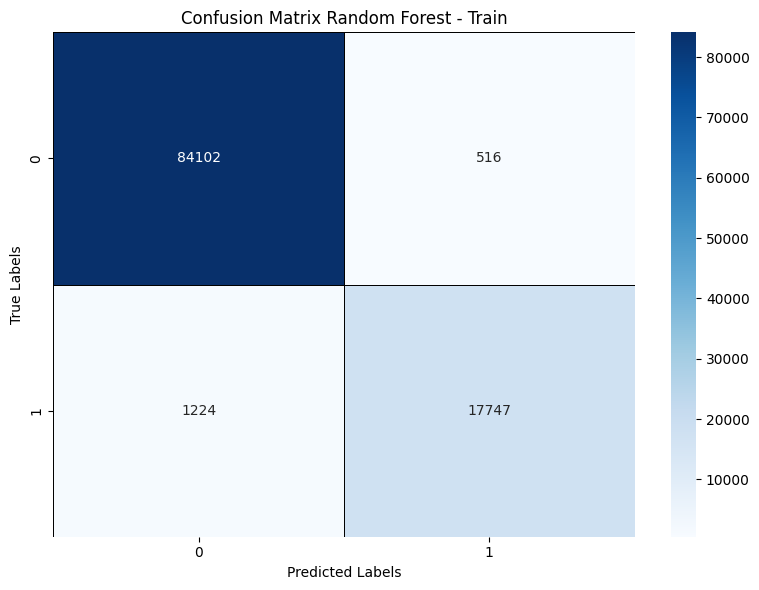

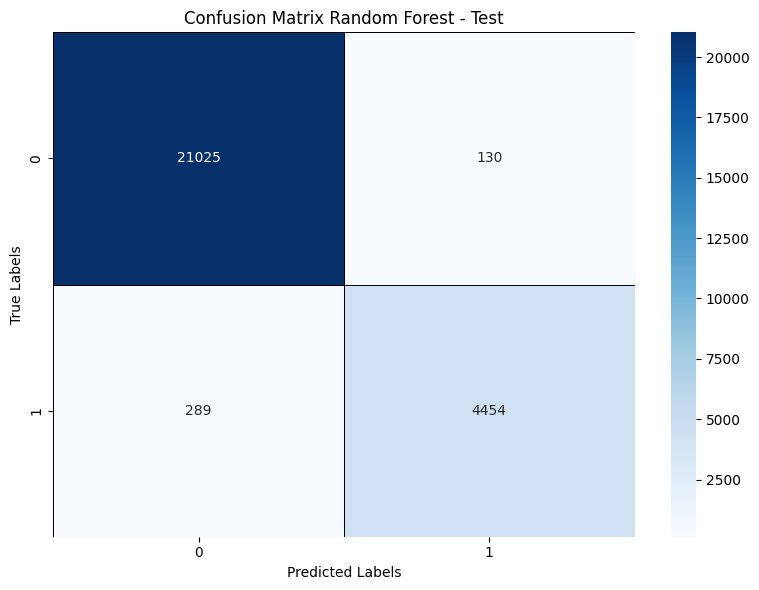

In [ ]:
# Split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

# Create a StratifiedKFold object for 5-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Adasyn with Best beta value and number of neighbours
tl = TomekLinks(sampling_strategy = 'majority')

# Apply ADASYN for oversampling on the training data
X_train_resampled, y_train_resampled = tl.fit_resample(X_train, y_train)

# Perform the hyperparameter search
tuner.search(x=X_train_resampled, y=y_train_resampled, epochs=10, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)
final_model.fit(x=X_train_resampled, y=y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predictions/probabilities validation
y_probs_train = final_model.predict(X_train)
y_probs_test = final_model.predict(X_test)

y_pred_train = (y_probs_train > 0.5).astype(int)
y_pred_test = (y_probs_test > 0.5).astype(int)

#Evaluation Metrics
f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_probs_train)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_probs_test)

pr_auc_train = auc(recall_train, precision_train)
pr_auc_test = auc(recall_test, precision_test)

g_mean_train = np.sqrt(recall_train * (1 - recall_train))
g_mean_test = np.sqrt(recall_test * (1 - recall_test))

best_index_train = np.argmax(g_mean_train)
best_index_test = np.argmax(g_mean_test)

best_threshold_train = thresholds_train[best_index_train]
best_threshold_test = thresholds_test[best_index_test]

#Print Train results
print(f"F1 Score: {f1_train}")
print(f"AUC-PR Score: {pr_auc_train}")
print(f"G-Mean: {g_mean_train[best_index_train]} at threshold {best_threshold_train}")
print(classification_report(y_train, y_pred_train))
cm = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest - Train")
plt.tight_layout()

#Print Test results
print(f"F1 Score: {f1_test}")
print(f"AUC-PR Score: {pr_auc_test}")
print(f"G-Mean: {g_mean_test[best_index_test]} at threshold {best_threshold_test}")
print(classification_report(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest - Test")
plt.tight_layout()

#plt.savefig('/content/drive/My Drive/Thesis/Figures//CM_MLP_Adasyn_test.png', dpi=300)



In [ ]:
final_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 256)               4608      
                                                                 
 dense_141 (Dense)           (None, 480)               123360    
                                                                 
 dropout_40 (Dropout)        (None, 480)               0         
                                                                 
 dense_142 (Dense)           (None, 224)               107744    
                                                                 
 dense_143 (Dense)           (None, 224)               50400     
                                                                 
 dense_144 (Dense)           (None, 416)               93600     
                                                                 
 dropout_41 (Dropout)        (None, 416)             

In [ ]:
# Create Precision-Recall curve display
display_train_mlp_tl = PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=pr_auc_train)
display_test_mlp_tl = PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=pr_auc_test)

# Plot both curves on the same plot
plt.figure(figsize=(8, 6))

# Plot training set curve
display_train_mlp_tl.plot(ax=plt.gca(), name="Train")
display_test_mlp_tl.plot(ax=plt.gca(), name="Test")

# Show AUC-PR values in the plot
plt.title(f'Precision-Recall Curve (Train AUC-PR = {pr_auc_train:.4f}, Test AUC-PR = {pr_auc_test:.4f}')
plt.scatter(recall_train[best_index_train], precision_train[best_index_train], marker='o', color='blue', label=f'Best G-mean Train {best_threshold_train:.4f}')
plt.scatter(recall_test[best_index_test], precision_test[best_index_test], marker='o', color='orange', label=f'Best G-mean Test {best_threshold_test:.4f}')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot training set curve
display_train_lg.plot(ax=plt.gca(), name="Train Logistic Regression")
display_val_lg.plot(ax=plt.gca(), name="Validation Logistic Regression")
display_test_lg.plot(ax=plt.gca(), name="Test Logistic Regression")
display_train_rf_adasyn.plot(ax=plt.gca(), name="Train Random Forest With Adasyn")
display_test_rf_adasyn.plot(ax=plt.gca(), name="Test Random Forest With Adasyn")
display_train_rf_tl.plot(ax=plt.gca(), name="Train Random Forest With Tomek Links")
display_test_rf_tl.plot(ax=plt.gca(), name="Test Random Forest With Tomek Links")
display_train_mlp_adasyn.plot(ax=plt.gca(), name="Train Multi-Layer Perceptron With Adasyn")
display_test_mlp_adasyn.plot(ax=plt.gca(), name="Test Multi-Layer Perceptron With Adasyn")
display_train_mlp_tl.plot(ax=plt.gca(), name="Train Multi-Layer Perceptron With Tomek Links")
display_test_mlp_tl.plot(ax=plt.gca(), name="Test Multi-Layer Perceptron With Tomek Links")